## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u (outputs)


We have to find out u(x) for all x in range [-10,10] 


When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$


Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [4]:
# # We consider Net as our solution u_theta(x,t)

# """
# When forming the network, we have to keep in mind the number of inputs and outputs
# In ur case: #inputs = 1 (x)
# and #outputs = 1 (u)

# You can add ass many hidden layers as you want with as many neurons.
# More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

# Let us create this network:
# min 3 hidden layer with 50 neurons each.
# """

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.hidden_layer1 = nn.Linear(1,50)
#         self.hidden_layer2 = nn.Linear(50,50)
#         self.hidden_layer3 = nn.Linear(50,50)
#         self.output_layer = nn.Linear(50,1)

#     def forward(self, x):
#         inputs = x # combined two arrays of 1 columns each to one array of 2 columns
#         layer1_out = torch.tanh(self.hidden_layer1(inputs))
#         layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
#         layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
#         output = self.output_layer(layer3_out) ## For regression, no activation is used in output layer
#         return output

In [9]:
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)

GPU: True


## PINN

In [4]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x) # the dependent variable u is given by the network based on independent variables x,t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

In [7]:
## Data from Boundary Conditions
## BC just gives us datapoints for training

# BC tells us that for any x=-10 or 10, the value of u is given by analytical solution

# compute u based on BC
# u_bc = np.sin(0.7*x_bc)+np.cos(1.5*x_bc)-0.1*x_bc

In [22]:
def exact_U(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [27]:
class Model:
    def __init__(self, net, iterations, f, x_bc, u_bc, x_col, exact_u):

        self.x_bc_s = None
        self.x_f_s = None
        self.s_collect = []
#         self.s_f_collect = []
        
        self.f = f
        
        
        self.x_bc = x_bc
        self.u_bc = u_bc
        self.x_col = x_col
        self.exact_u=exact_u
        self.net = net
        self.iterations = iterations
        self.Step = []
        self.T_error=[]
        self.T_BC=[]
        self.T_PDE=[]
    
    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)
    
    def epoch_loss(self):
        loss_pde = torch.mean(self.f(self.x_col, self.train_U) ** 2)
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)
        self.T_PDE.append(loss_pde.item())
        self.T_BC.append(loss_bc.item())
        return loss_pde, loss_bc

    def likelihood_loss(self, loss_f, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_f.detach() + self.x_f_s \
               + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss

    def true_loss(self, loss_f, loss_bc):
        return torch.exp(-self.x_f_s.detach()) * loss_f + torch.exp(-self.x_bc_s.detach()) * loss_bc
    
    def evaluate(self):
        pred = self.train_U(self.x_col).cpu().detach().numpy()
        exact = self.exact_u.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def run_AW(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        self.net.iter=0

        optimizer_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        pbar = trange(self.iterations, ncols=100)

        for i in pbar:
            self.s_collect.append([self.x_f_s.item(), self.x_bc_s.item()])
            
            loss_pde, loss_bc = self.epoch_loss()    
            optimizer.zero_grad()
            loss = self.true_loss(loss_pde,loss_bc)
            loss.backward()
            optimizer.step()
            self.net.iter+=1
            pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item())
                                  })
            optimizer_weight.zero_grad()
            loss = self.likelihood_loss(loss_pde,loss_bc)
            loss.backward() 
            optimizer_weight.step()
    
            l2_loss = self.evaluate()
            with torch.autograd.no_grad():
                print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (i, l2_loss, loss_pde, loss_bc))
                print('s_f:%.4f, s_{bc}:%.4f' %(self.x_f_s, self.x_bc_s))
                self.T_error.append(l2_loss.item())
                self.Step.append(i)
    
    def train(self):
        self.x_f_s = torch.tensor(0.)
        self.x_bc_s = torch.tensor(0.)
        self.run_AW()

In [30]:
x_bc = np.array([[-10],[10]])
u_bc = exact_U(x_bc)
x_bc=is_cuda(torch.from_numpy(x_bc).float())
u_bc=is_cuda(torch.from_numpy(u_bc).float())
# Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
exact_u= exact_U(x_collocation)
x_col=is_cuda(torch.from_numpy(x_collocation).float())
exact_u=is_cuda(torch.from_numpy(exact_u).float())
layers = [1, 50, 50, 50, 1]
net = Net(layers)
net = net.to(device)
model = Model(
    net=net, iterations = 5000, f=f, x_bc=x_bc, u_bc=u_bc , x_col=x_col, exact_u=exact_u)

In [31]:
model.train()

  1%|▏                                   | 34/5000 [00:00<00:29, 170.24it/s, Iter=34, Loss=2.52e+00]

[0]-th step loss: 0.9304,  BC: 2.60143, residual: 0.74802
s_f:0.0010, s_{bc}:-0.0010
[1]-th step loss: 0.8896,  BC: 2.61305, residual: 0.56375
s_f:0.0020, s_{bc}:-0.0020
[2]-th step loss: 0.8825,  BC: 2.62168, residual: 0.57431
s_f:0.0030, s_{bc}:-0.0030
[3]-th step loss: 0.8852,  BC: 2.62309, residual: 0.59028
s_f:0.0040, s_{bc}:-0.0040
[4]-th step loss: 0.8979,  BC: 2.61971, residual: 0.54767
s_f:0.0050, s_{bc}:-0.0050
[5]-th step loss: 0.9212,  BC: 2.61422, residual: 0.49600
s_f:0.0060, s_{bc}:-0.0060
[6]-th step loss: 0.9474,  BC: 2.60830, residual: 0.47103
s_f:0.0070, s_{bc}:-0.0070
[7]-th step loss: 0.9649,  BC: 2.60322, residual: 0.47283
s_f:0.0080, s_{bc}:-0.0080
[8]-th step loss: 0.9672,  BC: 2.59984, residual: 0.47617
s_f:0.0090, s_{bc}:-0.0090
[9]-th step loss: 0.9563,  BC: 2.59832, residual: 0.46093
s_f:0.0100, s_{bc}:-0.0101
[10]-th step loss: 0.9381,  BC: 2.59828, residual: 0.42891
s_f:0.0110, s_{bc}:-0.0111
[11]-th step loss: 0.9196,  BC: 2.59913, residual: 0.39461
s_f:0

  1%|▌                                   | 72/5000 [00:00<00:27, 180.47it/s, Iter=72, Loss=2.17e+00]

[34]-th step loss: 1.0625,  BC: 2.54810, residual: 0.04423
s_f:0.0347, s_{bc}:-0.0377
[35]-th step loss: 1.0831,  BC: 2.54522, residual: 0.03636
s_f:0.0357, s_{bc}:-0.0389
[36]-th step loss: 1.1104,  BC: 2.54173, residual: 0.02678
s_f:0.0366, s_{bc}:-0.0401
[37]-th step loss: 1.1359,  BC: 2.53790, residual: 0.01956
s_f:0.0376, s_{bc}:-0.0413
[38]-th step loss: 1.1515,  BC: 2.53414, residual: 0.01616
s_f:0.0386, s_{bc}:-0.0425
[39]-th step loss: 1.1561,  BC: 2.53073, residual: 0.01202
s_f:0.0395, s_{bc}:-0.0437
[40]-th step loss: 1.1564,  BC: 2.52765, residual: 0.00624
s_f:0.0405, s_{bc}:-0.0449
[41]-th step loss: 1.1622,  BC: 2.52458, residual: 0.00317
s_f:0.0414, s_{bc}:-0.0461
[42]-th step loss: 1.1784,  BC: 2.52112, residual: 0.00266
s_f:0.0424, s_{bc}:-0.0473
[43]-th step loss: 1.2023,  BC: 2.51710, residual: 0.00105
s_f:0.0434, s_{bc}:-0.0485
[44]-th step loss: 1.2243,  BC: 2.51265, residual: 0.00005
s_f:0.0443, s_{bc}:-0.0497
[45]-th step loss: 1.2354,  BC: 2.50810, residual: 0.0

  2%|▋                                 | 110/5000 [00:00<00:26, 182.82it/s, Iter=110, Loss=1.76e+00]

[72]-th step loss: 1.2968,  BC: 2.30760, residual: 0.00137
s_f:0.0700, s_{bc}:-0.0824
[73]-th step loss: 1.3067,  BC: 2.29708, residual: 0.00149
s_f:0.0709, s_{bc}:-0.0836
[74]-th step loss: 1.3125,  BC: 2.28640, residual: 0.00174
s_f:0.0717, s_{bc}:-0.0847
[75]-th step loss: 1.3148,  BC: 2.27569, residual: 0.00179
s_f:0.0726, s_{bc}:-0.0858
[76]-th step loss: 1.3189,  BC: 2.26497, residual: 0.00167
s_f:0.0734, s_{bc}:-0.0870
[77]-th step loss: 1.3284,  BC: 2.25411, residual: 0.00164
s_f:0.0743, s_{bc}:-0.0881
[78]-th step loss: 1.3403,  BC: 2.24306, residual: 0.00156
s_f:0.0751, s_{bc}:-0.0892
[79]-th step loss: 1.3491,  BC: 2.23188, residual: 0.00154
s_f:0.0759, s_{bc}:-0.0903
[80]-th step loss: 1.3542,  BC: 2.22072, residual: 0.00143
s_f:0.0767, s_{bc}:-0.0915
[81]-th step loss: 1.3607,  BC: 2.20959, residual: 0.00118
s_f:0.0776, s_{bc}:-0.0926
[82]-th step loss: 1.3719,  BC: 2.19840, residual: 0.00103
s_f:0.0784, s_{bc}:-0.0937
[83]-th step loss: 1.3847,  BC: 2.18711, residual: 0.0

  3%|█                                 | 148/5000 [00:00<00:26, 184.17it/s, Iter=148, Loss=1.62e+00]

[110]-th step loss: 1.6842,  BC: 1.93743, residual: 0.00046
s_f:0.0987, s_{bc}:-0.1246
[111]-th step loss: 1.6999,  BC: 1.93169, residual: 0.00041
s_f:0.0994, s_{bc}:-0.1256
[112]-th step loss: 1.7134,  BC: 1.92621, residual: 0.00036
s_f:0.1000, s_{bc}:-0.1267
[113]-th step loss: 1.7277,  BC: 1.92101, residual: 0.00028
s_f:0.1007, s_{bc}:-0.1278
[114]-th step loss: 1.7437,  BC: 1.91604, residual: 0.00023
s_f:0.1013, s_{bc}:-0.1289
[115]-th step loss: 1.7576,  BC: 1.91126, residual: 0.00020
s_f:0.1019, s_{bc}:-0.1300
[116]-th step loss: 1.7714,  BC: 1.90673, residual: 0.00015
s_f:0.1026, s_{bc}:-0.1311
[117]-th step loss: 1.7868,  BC: 1.90240, residual: 0.00012
s_f:0.1032, s_{bc}:-0.1321
[118]-th step loss: 1.8004,  BC: 1.89823, residual: 0.00011
s_f:0.1038, s_{bc}:-0.1332
[119]-th step loss: 1.8135,  BC: 1.89426, residual: 0.00010
s_f:0.1044, s_{bc}:-0.1343
[120]-th step loss: 1.8280,  BC: 1.89046, residual: 0.00008
s_f:0.1050, s_{bc}:-0.1354
[121]-th step loss: 1.8406,  BC: 1.88680, r

  4%|█▎                                | 186/5000 [00:01<00:26, 184.76it/s, Iter=186, Loss=1.53e+00]

[148]-th step loss: 2.0048,  BC: 1.82157, residual: 0.00012
s_f:0.1213, s_{bc}:-0.1653
[149]-th step loss: 1.9926,  BC: 1.81968, residual: 0.00018
s_f:0.1218, s_{bc}:-0.1664
[150]-th step loss: 2.0040,  BC: 1.81785, residual: 0.00023
s_f:0.1224, s_{bc}:-0.1674
[151]-th step loss: 1.9815,  BC: 1.81596, residual: 0.00043
s_f:0.1229, s_{bc}:-0.1685
[152]-th step loss: 2.0036,  BC: 1.81418, residual: 0.00067
s_f:0.1235, s_{bc}:-0.1695
[153]-th step loss: 1.9699,  BC: 1.81229, residual: 0.00108
s_f:0.1240, s_{bc}:-0.1706
[154]-th step loss: 1.9958,  BC: 1.81055, residual: 0.00125
s_f:0.1246, s_{bc}:-0.1716
[155]-th step loss: 1.9698,  BC: 1.80870, residual: 0.00102
s_f:0.1251, s_{bc}:-0.1727
[156]-th step loss: 1.9734,  BC: 1.80697, residual: 0.00036
s_f:0.1257, s_{bc}:-0.1738
[157]-th step loss: 1.9766,  BC: 1.80518, residual: 0.00006
s_f:0.1262, s_{bc}:-0.1748
[158]-th step loss: 1.9537,  BC: 1.80340, residual: 0.00033
s_f:0.1268, s_{bc}:-0.1759
[159]-th step loss: 1.9704,  BC: 1.80169, r

  4%|█▌                                | 224/5000 [00:01<00:25, 184.39it/s, Iter=224, Loss=1.46e+00]

[186]-th step loss: 1.8494,  BC: 1.75663, residual: 0.00006
s_f:0.1417, s_{bc}:-0.2053
[187]-th step loss: 1.8432,  BC: 1.75519, residual: 0.00005
s_f:0.1422, s_{bc}:-0.2064
[188]-th step loss: 1.8430,  BC: 1.75378, residual: 0.00006
s_f:0.1428, s_{bc}:-0.2074
[189]-th step loss: 1.8352,  BC: 1.75240, residual: 0.00007
s_f:0.1433, s_{bc}:-0.2084
[190]-th step loss: 1.8323,  BC: 1.75105, residual: 0.00005
s_f:0.1438, s_{bc}:-0.2095
[191]-th step loss: 1.8295,  BC: 1.74972, residual: 0.00004
s_f:0.1443, s_{bc}:-0.2105
[192]-th step loss: 1.8222,  BC: 1.74843, residual: 0.00005
s_f:0.1448, s_{bc}:-0.2116
[193]-th step loss: 1.8209,  BC: 1.74715, residual: 0.00006
s_f:0.1453, s_{bc}:-0.2126
[194]-th step loss: 1.8155,  BC: 1.74591, residual: 0.00005
s_f:0.1458, s_{bc}:-0.2137
[195]-th step loss: 1.8103,  BC: 1.74469, residual: 0.00004
s_f:0.1464, s_{bc}:-0.2147
[196]-th step loss: 1.8084,  BC: 1.74349, residual: 0.00005
s_f:0.1469, s_{bc}:-0.2158
[197]-th step loss: 1.8019,  BC: 1.74232, r

  5%|█▊                                | 262/5000 [00:01<00:25, 184.37it/s, Iter=262, Loss=1.40e+00]

[224]-th step loss: 1.6861,  BC: 1.71460, residual: 0.00003
s_f:0.1608, s_{bc}:-0.2449
[225]-th step loss: 1.6825,  BC: 1.71360, residual: 0.00003
s_f:0.1613, s_{bc}:-0.2459
[226]-th step loss: 1.6785,  BC: 1.71261, residual: 0.00003
s_f:0.1618, s_{bc}:-0.2470
[227]-th step loss: 1.6742,  BC: 1.71161, residual: 0.00003
s_f:0.1623, s_{bc}:-0.2480
[228]-th step loss: 1.6708,  BC: 1.71061, residual: 0.00003
s_f:0.1628, s_{bc}:-0.2491
[229]-th step loss: 1.6668,  BC: 1.70960, residual: 0.00003
s_f:0.1633, s_{bc}:-0.2501
[230]-th step loss: 1.6630,  BC: 1.70859, residual: 0.00003
s_f:0.1638, s_{bc}:-0.2511
[231]-th step loss: 1.6596,  BC: 1.70758, residual: 0.00003
s_f:0.1643, s_{bc}:-0.2522
[232]-th step loss: 1.6557,  BC: 1.70656, residual: 0.00003
s_f:0.1647, s_{bc}:-0.2532
[233]-th step loss: 1.6522,  BC: 1.70554, residual: 0.00003
s_f:0.1652, s_{bc}:-0.2542
[234]-th step loss: 1.6489,  BC: 1.70451, residual: 0.00003
s_f:0.1657, s_{bc}:-0.2553
[235]-th step loss: 1.6451,  BC: 1.70348, r

  6%|█▉                                | 281/5000 [00:01<00:25, 183.57it/s, Iter=300, Loss=1.34e+00]

[262]-th step loss: 1.5583,  BC: 1.67380, residual: 0.00006
s_f:0.1789, s_{bc}:-0.2842
[263]-th step loss: 1.5552,  BC: 1.67264, residual: 0.00006
s_f:0.1793, s_{bc}:-0.2852
[264]-th step loss: 1.5523,  BC: 1.67149, residual: 0.00007
s_f:0.1798, s_{bc}:-0.2863
[265]-th step loss: 1.5493,  BC: 1.67033, residual: 0.00007
s_f:0.1802, s_{bc}:-0.2873
[266]-th step loss: 1.5464,  BC: 1.66917, residual: 0.00007
s_f:0.1807, s_{bc}:-0.2883
[267]-th step loss: 1.5435,  BC: 1.66801, residual: 0.00007
s_f:0.1811, s_{bc}:-0.2894
[268]-th step loss: 1.5407,  BC: 1.66685, residual: 0.00007
s_f:0.1816, s_{bc}:-0.2904
[269]-th step loss: 1.5378,  BC: 1.66569, residual: 0.00007
s_f:0.1820, s_{bc}:-0.2914
[270]-th step loss: 1.5350,  BC: 1.66453, residual: 0.00007
s_f:0.1825, s_{bc}:-0.2925
[271]-th step loss: 1.5323,  BC: 1.66337, residual: 0.00007
s_f:0.1829, s_{bc}:-0.2935
[272]-th step loss: 1.5295,  BC: 1.66222, residual: 0.00007
s_f:0.1834, s_{bc}:-0.2945
[273]-th step loss: 1.5268,  BC: 1.66106, r

  6%|██▏                               | 319/5000 [00:01<00:25, 183.29it/s, Iter=337, Loss=1.29e+00]

[299]-th step loss: 1.4606,  BC: 1.63202, residual: 0.00007
s_f:0.1951, s_{bc}:-0.3223
[300]-th step loss: 1.4581,  BC: 1.63094, residual: 0.00007
s_f:0.1955, s_{bc}:-0.3233
[301]-th step loss: 1.4556,  BC: 1.62986, residual: 0.00007
s_f:0.1959, s_{bc}:-0.3243
[302]-th step loss: 1.4530,  BC: 1.62878, residual: 0.00007
s_f:0.1963, s_{bc}:-0.3254
[303]-th step loss: 1.4505,  BC: 1.62770, residual: 0.00007
s_f:0.1967, s_{bc}:-0.3264
[304]-th step loss: 1.4479,  BC: 1.62662, residual: 0.00007
s_f:0.1972, s_{bc}:-0.3274
[305]-th step loss: 1.4453,  BC: 1.62554, residual: 0.00007
s_f:0.1976, s_{bc}:-0.3284
[306]-th step loss: 1.4427,  BC: 1.62447, residual: 0.00007
s_f:0.1980, s_{bc}:-0.3295
[307]-th step loss: 1.4401,  BC: 1.62339, residual: 0.00007
s_f:0.1984, s_{bc}:-0.3305
[308]-th step loss: 1.4374,  BC: 1.62231, residual: 0.00007
s_f:0.1988, s_{bc}:-0.3315
[309]-th step loss: 1.4348,  BC: 1.62123, residual: 0.00007
s_f:0.1992, s_{bc}:-0.3325
[310]-th step loss: 1.4321,  BC: 1.62015, r

  7%|██▍                               | 357/5000 [00:02<00:25, 183.05it/s, Iter=374, Loss=1.22e+00]

[336]-th step loss: 1.3548,  BC: 1.59078, residual: 0.00004
s_f:0.2098, s_{bc}:-0.3602
[337]-th step loss: 1.3515,  BC: 1.58955, residual: 0.00004
s_f:0.2102, s_{bc}:-0.3612
[338]-th step loss: 1.3482,  BC: 1.58831, residual: 0.00003
s_f:0.2106, s_{bc}:-0.3622
[339]-th step loss: 1.3449,  BC: 1.58706, residual: 0.00003
s_f:0.2109, s_{bc}:-0.3633
[340]-th step loss: 1.3415,  BC: 1.58579, residual: 0.00003
s_f:0.2113, s_{bc}:-0.3643
[341]-th step loss: 1.3381,  BC: 1.58451, residual: 0.00003
s_f:0.2117, s_{bc}:-0.3653
[342]-th step loss: 1.3348,  BC: 1.58322, residual: 0.00003
s_f:0.2121, s_{bc}:-0.3663
[343]-th step loss: 1.3314,  BC: 1.58190, residual: 0.00003
s_f:0.2124, s_{bc}:-0.3674
[344]-th step loss: 1.3280,  BC: 1.58057, residual: 0.00003
s_f:0.2128, s_{bc}:-0.3684
[345]-th step loss: 1.3245,  BC: 1.57922, residual: 0.00003
s_f:0.2132, s_{bc}:-0.3694
[346]-th step loss: 1.3211,  BC: 1.57785, residual: 0.00002
s_f:0.2135, s_{bc}:-0.3704
[347]-th step loss: 1.3177,  BC: 1.57646, r

  8%|██▋                               | 395/5000 [00:02<00:25, 183.06it/s, Iter=411, Loss=1.07e+00]

[373]-th step loss: 1.2426,  BC: 1.52713, residual: 0.00003
s_f:0.2228, s_{bc}:-0.3980
[374]-th step loss: 1.2405,  BC: 1.52451, residual: 0.00003
s_f:0.2231, s_{bc}:-0.3990
[375]-th step loss: 1.2385,  BC: 1.52184, residual: 0.00003
s_f:0.2234, s_{bc}:-0.4000
[376]-th step loss: 1.2363,  BC: 1.51910, residual: 0.00003
s_f:0.2237, s_{bc}:-0.4011
[377]-th step loss: 1.2341,  BC: 1.51629, residual: 0.00003
s_f:0.2240, s_{bc}:-0.4021
[378]-th step loss: 1.2319,  BC: 1.51341, residual: 0.00002
s_f:0.2243, s_{bc}:-0.4031
[379]-th step loss: 1.2296,  BC: 1.51047, residual: 0.00002
s_f:0.2246, s_{bc}:-0.4041
[380]-th step loss: 1.2272,  BC: 1.50744, residual: 0.00002
s_f:0.2249, s_{bc}:-0.4051
[381]-th step loss: 1.2248,  BC: 1.50433, residual: 0.00002
s_f:0.2252, s_{bc}:-0.4062
[382]-th step loss: 1.2224,  BC: 1.50113, residual: 0.00002
s_f:0.2255, s_{bc}:-0.4072
[383]-th step loss: 1.2200,  BC: 1.49784, residual: 0.00003
s_f:0.2258, s_{bc}:-0.4082
[384]-th step loss: 1.2177,  BC: 1.49444, r

  9%|██▉                               | 433/5000 [00:02<00:24, 183.09it/s, Iter=448, Loss=8.20e-01]

[410]-th step loss: 1.1947,  BC: 1.34922, residual: 0.00001
s_f:0.2321, s_{bc}:-0.4357
[411]-th step loss: 1.1978,  BC: 1.34100, residual: 0.00002
s_f:0.2323, s_{bc}:-0.4367
[412]-th step loss: 1.1929,  BC: 1.33267, residual: 0.00001
s_f:0.2324, s_{bc}:-0.4378
[413]-th step loss: 1.2050,  BC: 1.32402, residual: 0.00013
s_f:0.2326, s_{bc}:-0.4388
[414]-th step loss: 1.1810,  BC: 1.31551, residual: 0.00034
s_f:0.2327, s_{bc}:-0.4398
[415]-th step loss: 1.2311,  BC: 1.30626, residual: 0.00198
s_f:0.2328, s_{bc}:-0.4408
[416]-th step loss: 1.1496,  BC: 1.29854, residual: 0.00650
s_f:0.2330, s_{bc}:-0.4418
[417]-th step loss: 1.2368,  BC: 1.28883, residual: 0.01494
s_f:0.2331, s_{bc}:-0.4428
[418]-th step loss: 1.1958,  BC: 1.28211, residual: 0.00922
s_f:0.2332, s_{bc}:-0.4439
[419]-th step loss: 1.1566,  BC: 1.27290, residual: 0.00002
s_f:0.2332, s_{bc}:-0.4449
[420]-th step loss: 1.2247,  BC: 1.26441, residual: 0.00869
s_f:0.2333, s_{bc}:-0.4459
[421]-th step loss: 1.2034,  BC: 1.25738, r

  9%|███▏                              | 471/5000 [00:02<00:24, 182.56it/s, Iter=485, Loss=6.32e-01]

[448]-th step loss: 1.2810,  BC: 1.02577, residual: 0.00018
s_f:0.2318, s_{bc}:-0.4743
[449]-th step loss: 1.2791,  BC: 1.01823, residual: 0.00029
s_f:0.2316, s_{bc}:-0.4753
[450]-th step loss: 1.2774,  BC: 1.01004, residual: 0.00004
s_f:0.2314, s_{bc}:-0.4763
[451]-th step loss: 1.2950,  BC: 1.00207, residual: 0.00048
s_f:0.2312, s_{bc}:-0.4773
[452]-th step loss: 1.3061,  BC: 0.99466, residual: 0.00004
s_f:0.2310, s_{bc}:-0.4783
[453]-th step loss: 1.3027,  BC: 0.98722, residual: 0.00015
s_f:0.2307, s_{bc}:-0.4793
[454]-th step loss: 1.3110,  BC: 0.97939, residual: 0.00022
s_f:0.2305, s_{bc}:-0.4804
[455]-th step loss: 1.3287,  BC: 0.97201, residual: 0.00019
s_f:0.2302, s_{bc}:-0.4814
[456]-th step loss: 1.3334,  BC: 0.96505, residual: 0.00011
s_f:0.2300, s_{bc}:-0.4824
[457]-th step loss: 1.3348,  BC: 0.95771, residual: 0.00004
s_f:0.2297, s_{bc}:-0.4834
[458]-th step loss: 1.3497,  BC: 0.95044, residual: 0.00029
s_f:0.2294, s_{bc}:-0.4844
[459]-th step loss: 1.3632,  BC: 0.94362, r

 10%|███▍                              | 509/5000 [00:02<00:24, 182.95it/s, Iter=523, Loss=5.07e-01]

[485]-th step loss: 1.7003,  BC: 0.78143, residual: 0.00018
s_f:0.2186, s_{bc}:-0.5118
[486]-th step loss: 1.7168,  BC: 0.77542, residual: 0.00023
s_f:0.2181, s_{bc}:-0.5128
[487]-th step loss: 1.7339,  BC: 0.76960, residual: 0.00022
s_f:0.2176, s_{bc}:-0.5139
[488]-th step loss: 1.7481,  BC: 0.76386, residual: 0.00019
s_f:0.2170, s_{bc}:-0.5149
[489]-th step loss: 1.7630,  BC: 0.75802, residual: 0.00023
s_f:0.2165, s_{bc}:-0.5159
[490]-th step loss: 1.7799,  BC: 0.75230, residual: 0.00026
s_f:0.2160, s_{bc}:-0.5169
[491]-th step loss: 1.7951,  BC: 0.74675, residual: 0.00022
s_f:0.2154, s_{bc}:-0.5179
[492]-th step loss: 1.8089,  BC: 0.74120, residual: 0.00023
s_f:0.2149, s_{bc}:-0.5189
[493]-th step loss: 1.8244,  BC: 0.73566, residual: 0.00027
s_f:0.2143, s_{bc}:-0.5200
[494]-th step loss: 1.8402,  BC: 0.73031, residual: 0.00025
s_f:0.2137, s_{bc}:-0.5210
[495]-th step loss: 1.8538,  BC: 0.72507, residual: 0.00023
s_f:0.2132, s_{bc}:-0.5220
[496]-th step loss: 1.8676,  BC: 0.71981, r

 11%|███▋                              | 547/5000 [00:03<00:24, 183.46it/s, Iter=561, Loss=4.34e-01]

[523]-th step loss: 2.1844,  BC: 0.61364, residual: 0.00020
s_f:0.1945, s_{bc}:-0.5504
[524]-th step loss: 2.1929,  BC: 0.61054, residual: 0.00019
s_f:0.1937, s_{bc}:-0.5514
[525]-th step loss: 2.2015,  BC: 0.60747, residual: 0.00019
s_f:0.1930, s_{bc}:-0.5524
[526]-th step loss: 2.2095,  BC: 0.60443, residual: 0.00017
s_f:0.1922, s_{bc}:-0.5534
[527]-th step loss: 2.2168,  BC: 0.60141, residual: 0.00016
s_f:0.1915, s_{bc}:-0.5544
[528]-th step loss: 2.2240,  BC: 0.59839, residual: 0.00016
s_f:0.1907, s_{bc}:-0.5554
[529]-th step loss: 2.2308,  BC: 0.59540, residual: 0.00015
s_f:0.1900, s_{bc}:-0.5564
[530]-th step loss: 2.2370,  BC: 0.59243, residual: 0.00013
s_f:0.1892, s_{bc}:-0.5575
[531]-th step loss: 2.2428,  BC: 0.58947, residual: 0.00012
s_f:0.1884, s_{bc}:-0.5585
[532]-th step loss: 2.2484,  BC: 0.58652, residual: 0.00012
s_f:0.1877, s_{bc}:-0.5595
[533]-th step loss: 2.2535,  BC: 0.58360, residual: 0.00011
s_f:0.1869, s_{bc}:-0.5605
[534]-th step loss: 2.2581,  BC: 0.58069, r

 12%|███▉                              | 585/5000 [00:03<00:24, 183.70it/s, Iter=599, Loss=3.75e-01]

[561]-th step loss: 2.3055,  BC: 0.51312, residual: 0.00003
s_f:0.1636, s_{bc}:-0.5889
[562]-th step loss: 2.2992,  BC: 0.51103, residual: 0.00003
s_f:0.1628, s_{bc}:-0.5899
[563]-th step loss: 2.2956,  BC: 0.50534, residual: 0.00003
s_f:0.1619, s_{bc}:-0.5909
[564]-th step loss: 2.2980,  BC: 0.50644, residual: 0.00003
s_f:0.1610, s_{bc}:-0.5919
[565]-th step loss: 2.2931,  BC: 0.50164, residual: 0.00002
s_f:0.1601, s_{bc}:-0.5929
[566]-th step loss: 2.2866,  BC: 0.49992, residual: 0.00003
s_f:0.1592, s_{bc}:-0.5939
[567]-th step loss: 2.2875,  BC: 0.49864, residual: 0.00003
s_f:0.1583, s_{bc}:-0.5949
[568]-th step loss: 2.2840,  BC: 0.49435, residual: 0.00002
s_f:0.1574, s_{bc}:-0.5959
[569]-th step loss: 2.2750,  BC: 0.49420, residual: 0.00002
s_f:0.1566, s_{bc}:-0.5970
[570]-th step loss: 2.2736,  BC: 0.49051, residual: 0.00004
s_f:0.1557, s_{bc}:-0.5980
[571]-th step loss: 2.2715,  BC: 0.48844, residual: 0.00002
s_f:0.1548, s_{bc}:-0.5990
[572]-th step loss: 2.2619,  BC: 0.48700, r

 12%|████▏                             | 623/5000 [00:03<00:23, 184.60it/s, Iter=637, Loss=2.99e-01]

[599]-th step loss: 2.1302,  BC: 0.42488, residual: 0.00004
s_f:0.1285, s_{bc}:-0.6273
[600]-th step loss: 2.1263,  BC: 0.42257, residual: 0.00005
s_f:0.1275, s_{bc}:-0.6283
[601]-th step loss: 2.1230,  BC: 0.42019, residual: 0.00005
s_f:0.1265, s_{bc}:-0.6293
[602]-th step loss: 2.1174,  BC: 0.41768, residual: 0.00004
s_f:0.1255, s_{bc}:-0.6303
[603]-th step loss: 2.1135,  BC: 0.41518, residual: 0.00006
s_f:0.1245, s_{bc}:-0.6314
[604]-th step loss: 2.1099,  BC: 0.41277, residual: 0.00004
s_f:0.1236, s_{bc}:-0.6324
[605]-th step loss: 2.1049,  BC: 0.41018, residual: 0.00005
s_f:0.1226, s_{bc}:-0.6334
[606]-th step loss: 2.1000,  BC: 0.40754, residual: 0.00004
s_f:0.1216, s_{bc}:-0.6344
[607]-th step loss: 2.0967,  BC: 0.40493, residual: 0.00005
s_f:0.1206, s_{bc}:-0.6354
[608]-th step loss: 2.0915,  BC: 0.40231, residual: 0.00004
s_f:0.1196, s_{bc}:-0.6364
[609]-th step loss: 2.0866,  BC: 0.39957, residual: 0.00004
s_f:0.1186, s_{bc}:-0.6374
[610]-th step loss: 2.0827,  BC: 0.39679, r

 13%|████▍                             | 661/5000 [00:03<00:23, 184.25it/s, Iter=675, Loss=2.11e-01]

[637]-th step loss: 1.9744,  BC: 0.32101, residual: 0.00060
s_f:0.0893, s_{bc}:-0.6657
[638]-th step loss: 1.9743,  BC: 0.31801, residual: 0.00012
s_f:0.0882, s_{bc}:-0.6667
[639]-th step loss: 1.9658,  BC: 0.31582, residual: 0.00070
s_f:0.0871, s_{bc}:-0.6677
[640]-th step loss: 1.9668,  BC: 0.31236, residual: 0.00082
s_f:0.0860, s_{bc}:-0.6687
[641]-th step loss: 1.9637,  BC: 0.30930, residual: 0.00007
s_f:0.0849, s_{bc}:-0.6697
[642]-th step loss: 1.9563,  BC: 0.30639, residual: 0.00028
s_f:0.0838, s_{bc}:-0.6707
[643]-th step loss: 1.9573,  BC: 0.30314, residual: 0.00094
s_f:0.0827, s_{bc}:-0.6717
[644]-th step loss: 1.9532,  BC: 0.30057, residual: 0.00042
s_f:0.0816, s_{bc}:-0.6727
[645]-th step loss: 1.9479,  BC: 0.29748, residual: 0.00007
s_f:0.0805, s_{bc}:-0.6738
[646]-th step loss: 1.9476,  BC: 0.29496, residual: 0.00025
s_f:0.0794, s_{bc}:-0.6748
[647]-th step loss: 1.9411,  BC: 0.29271, residual: 0.00035
s_f:0.0783, s_{bc}:-0.6758
[648]-th step loss: 1.9402,  BC: 0.28948, r

 14%|████▊                             | 699/5000 [00:03<00:23, 184.84it/s, Iter=713, Loss=1.33e-01]

[675]-th step loss: 1.8995,  BC: 0.21247, residual: 0.00736
s_f:0.0455, s_{bc}:-0.7040
[676]-th step loss: 1.8978,  BC: 0.20728, residual: 0.00830
s_f:0.0443, s_{bc}:-0.7050
[677]-th step loss: 1.8992,  BC: 0.20282, residual: 0.00425
s_f:0.0431, s_{bc}:-0.7060
[678]-th step loss: 1.9002,  BC: 0.19800, residual: 0.00010
s_f:0.0418, s_{bc}:-0.7070
[679]-th step loss: 1.8979,  BC: 0.19661, residual: 0.00268
s_f:0.0406, s_{bc}:-0.7080
[680]-th step loss: 1.9020,  BC: 0.19713, residual: 0.00566
s_f:0.0394, s_{bc}:-0.7091
[681]-th step loss: 1.9004,  BC: 0.19344, residual: 0.00259
s_f:0.0381, s_{bc}:-0.7101
[682]-th step loss: 1.9012,  BC: 0.19041, residual: 0.00008
s_f:0.0369, s_{bc}:-0.7111
[683]-th step loss: 1.9045,  BC: 0.18828, residual: 0.00225
s_f:0.0357, s_{bc}:-0.7121
[684]-th step loss: 1.9024,  BC: 0.18546, residual: 0.00290
s_f:0.0344, s_{bc}:-0.7131
[685]-th step loss: 1.9052,  BC: 0.18404, residual: 0.00054
s_f:0.0332, s_{bc}:-0.7141
[686]-th step loss: 1.9063,  BC: 0.18307, r

 15%|█████                             | 737/5000 [00:04<00:23, 185.16it/s, Iter=751, Loss=9.90e-02]

[713]-th step loss: 1.9493,  BC: 0.13125, residual: 0.00020
s_f:-0.0025, s_{bc}:-0.7423
[714]-th step loss: 1.9505,  BC: 0.13023, residual: 0.00016
s_f:-0.0038, s_{bc}:-0.7433
[715]-th step loss: 1.9554,  BC: 0.12944, residual: 0.00007
s_f:-0.0051, s_{bc}:-0.7443
[716]-th step loss: 1.9513,  BC: 0.12931, residual: 0.00007
s_f:-0.0064, s_{bc}:-0.7453
[717]-th step loss: 1.9643,  BC: 0.13103, residual: 0.00036
s_f:-0.0077, s_{bc}:-0.7463
[718]-th step loss: 1.9494,  BC: 0.13461, residual: 0.00181
s_f:-0.0090, s_{bc}:-0.7473
[719]-th step loss: 1.9738,  BC: 0.14054, residual: 0.00504
s_f:-0.0103, s_{bc}:-0.7483
[720]-th step loss: 1.9526,  BC: 0.13758, residual: 0.00942
s_f:-0.0116, s_{bc}:-0.7493
[721]-th step loss: 1.9700,  BC: 0.12929, residual: 0.01093
s_f:-0.0129, s_{bc}:-0.7504
[722]-th step loss: 1.9699,  BC: 0.11953, residual: 0.00343
s_f:-0.0142, s_{bc}:-0.7514
[723]-th step loss: 1.9588,  BC: 0.12121, residual: 0.00032
s_f:-0.0155, s_{bc}:-0.7524
[724]-th step loss: 1.9773,  BC:

 16%|█████▎                            | 775/5000 [00:04<00:22, 185.29it/s, Iter=789, Loss=1.21e-01]

[751]-th step loss: 2.0076,  BC: 0.09373, residual: 0.00046
s_f:-0.0523, s_{bc}:-0.7805
[752]-th step loss: 2.0092,  BC: 0.09321, residual: 0.00029
s_f:-0.0537, s_{bc}:-0.7815
[753]-th step loss: 2.0130,  BC: 0.09217, residual: 0.00001
s_f:-0.0550, s_{bc}:-0.7825
[754]-th step loss: 2.0098,  BC: 0.09130, residual: 0.00027
s_f:-0.0563, s_{bc}:-0.7835
[755]-th step loss: 2.0135,  BC: 0.09073, residual: 0.00038
s_f:-0.0576, s_{bc}:-0.7845
[756]-th step loss: 2.0154,  BC: 0.09003, residual: 0.00010
s_f:-0.0589, s_{bc}:-0.7855
[757]-th step loss: 2.0123,  BC: 0.08941, residual: 0.00007
s_f:-0.0603, s_{bc}:-0.7865
[758]-th step loss: 2.0179,  BC: 0.08885, residual: 0.00030
s_f:-0.0616, s_{bc}:-0.7875
[759]-th step loss: 2.0162,  BC: 0.08813, residual: 0.00026
s_f:-0.0629, s_{bc}:-0.7886
[760]-th step loss: 2.0169,  BC: 0.08738, residual: 0.00003
s_f:-0.0642, s_{bc}:-0.7896
[761]-th step loss: 2.0202,  BC: 0.08674, residual: 0.00006
s_f:-0.0656, s_{bc}:-0.7906
[762]-th step loss: 2.0178,  BC:

 16%|█████▌                            | 813/5000 [00:04<00:22, 185.39it/s, Iter=827, Loss=7.31e-02]

[789]-th step loss: 2.0337,  BC: 0.10067, residual: 0.00103
s_f:-0.1025, s_{bc}:-0.8188
[790]-th step loss: 2.0244,  BC: 0.07637, residual: 0.00169
s_f:-0.1038, s_{bc}:-0.8198
[791]-th step loss: 2.0254,  BC: 0.07866, residual: 0.00147
s_f:-0.1051, s_{bc}:-0.8208
[792]-th step loss: 2.0303,  BC: 0.08910, residual: 0.00026
s_f:-0.1064, s_{bc}:-0.8218
[793]-th step loss: 2.0206,  BC: 0.07669, residual: 0.00033
s_f:-0.1077, s_{bc}:-0.8228
[794]-th step loss: 2.0291,  BC: 0.07379, residual: 0.00203
s_f:-0.1090, s_{bc}:-0.8238
[795]-th step loss: 2.0239,  BC: 0.08154, residual: 0.00217
s_f:-0.1103, s_{bc}:-0.8248
[796]-th step loss: 2.0236,  BC: 0.07343, residual: 0.00054
s_f:-0.1116, s_{bc}:-0.8259
[797]-th step loss: 2.0256,  BC: 0.07226, residual: 0.00016
s_f:-0.1129, s_{bc}:-0.8269
[798]-th step loss: 2.0201,  BC: 0.07786, residual: 0.00114
s_f:-0.1142, s_{bc}:-0.8279
[799]-th step loss: 2.0264,  BC: 0.07121, residual: 0.00119
s_f:-0.1155, s_{bc}:-0.8289
[800]-th step loss: 2.0193,  BC:

 17%|█████▊                            | 851/5000 [00:04<00:22, 185.43it/s, Iter=865, Loss=6.62e-02]

[827]-th step loss: 2.0057,  BC: 0.06226, residual: 0.00005
s_f:-0.1520, s_{bc}:-0.8571
[828]-th step loss: 2.0025,  BC: 0.06233, residual: 0.00003
s_f:-0.1533, s_{bc}:-0.8581
[829]-th step loss: 2.0031,  BC: 0.06211, residual: 0.00002
s_f:-0.1546, s_{bc}:-0.8591
[830]-th step loss: 2.0026,  BC: 0.06154, residual: 0.00001
s_f:-0.1559, s_{bc}:-0.8601
[831]-th step loss: 2.0007,  BC: 0.06151, residual: 0.00000
s_f:-0.1572, s_{bc}:-0.8611
[832]-th step loss: 2.0012,  BC: 0.06129, residual: 0.00001
s_f:-0.1585, s_{bc}:-0.8621
[833]-th step loss: 1.9991,  BC: 0.06086, residual: 0.00003
s_f:-0.1598, s_{bc}:-0.8631
[834]-th step loss: 1.9994,  BC: 0.06074, residual: 0.00005
s_f:-0.1611, s_{bc}:-0.8641
[835]-th step loss: 1.9980,  BC: 0.06051, residual: 0.00003
s_f:-0.1624, s_{bc}:-0.8651
[836]-th step loss: 1.9973,  BC: 0.06015, residual: 0.00000
s_f:-0.1637, s_{bc}:-0.8661
[837]-th step loss: 1.9966,  BC: 0.06003, residual: 0.00001
s_f:-0.1650, s_{bc}:-0.8672
[838]-th step loss: 1.9952,  BC:

 18%|██████                            | 889/5000 [00:04<00:22, 185.42it/s, Iter=903, Loss=6.15e-02]

[865]-th step loss: 1.9687,  BC: 0.05405, residual: 0.00000
s_f:-0.2010, s_{bc}:-0.8954
[866]-th step loss: 1.9680,  BC: 0.05385, residual: 0.00000
s_f:-0.2023, s_{bc}:-0.8964
[867]-th step loss: 1.9665,  BC: 0.05365, residual: 0.00000
s_f:-0.2036, s_{bc}:-0.8974
[868]-th step loss: 1.9658,  BC: 0.05345, residual: 0.00001
s_f:-0.2048, s_{bc}:-0.8984
[869]-th step loss: 1.9643,  BC: 0.05327, residual: 0.00000
s_f:-0.2061, s_{bc}:-0.8994
[870]-th step loss: 1.9636,  BC: 0.05306, residual: 0.00001
s_f:-0.2074, s_{bc}:-0.9004
[871]-th step loss: 1.9620,  BC: 0.05287, residual: 0.00000
s_f:-0.2087, s_{bc}:-0.9014
[872]-th step loss: 1.9615,  BC: 0.05268, residual: 0.00000
s_f:-0.2099, s_{bc}:-0.9024
[873]-th step loss: 1.9597,  BC: 0.05250, residual: 0.00000
s_f:-0.2112, s_{bc}:-0.9034
[874]-th step loss: 1.9593,  BC: 0.05230, residual: 0.00001
s_f:-0.2125, s_{bc}:-0.9044
[875]-th step loss: 1.9574,  BC: 0.05211, residual: 0.00000
s_f:-0.2138, s_{bc}:-0.9054
[876]-th step loss: 1.9570,  BC:

 19%|██████▎                           | 927/5000 [00:05<00:21, 185.46it/s, Iter=941, Loss=5.53e-02]

[903]-th step loss: 1.9185,  BC: 0.04834, residual: 0.00038
s_f:-0.2493, s_{bc}:-0.9336
[904]-th step loss: 1.9253,  BC: 0.04936, residual: 0.00031
s_f:-0.2505, s_{bc}:-0.9346
[905]-th step loss: 1.9188,  BC: 0.04918, residual: 0.00011
s_f:-0.2518, s_{bc}:-0.9356
[906]-th step loss: 1.9197,  BC: 0.04770, residual: 0.00001
s_f:-0.2530, s_{bc}:-0.9366
[907]-th step loss: 1.9204,  BC: 0.04651, residual: 0.00001
s_f:-0.2543, s_{bc}:-0.9376
[908]-th step loss: 1.9150,  BC: 0.04664, residual: 0.00005
s_f:-0.2556, s_{bc}:-0.9386
[909]-th step loss: 1.9199,  BC: 0.04743, residual: 0.00009
s_f:-0.2568, s_{bc}:-0.9396
[910]-th step loss: 1.9133,  BC: 0.04767, residual: 0.00009
s_f:-0.2581, s_{bc}:-0.9406
[911]-th step loss: 1.9164,  BC: 0.04684, residual: 0.00008
s_f:-0.2593, s_{bc}:-0.9416
[912]-th step loss: 1.9140,  BC: 0.04586, residual: 0.00003
s_f:-0.2606, s_{bc}:-0.9426
[913]-th step loss: 1.9117,  BC: 0.04551, residual: 0.00001
s_f:-0.2618, s_{bc}:-0.9437
[914]-th step loss: 1.9142,  BC:

 19%|██████▌                           | 965/5000 [00:05<00:21, 185.41it/s, Iter=979, Loss=5.18e-02]

[941]-th step loss: 1.8844,  BC: 0.04104, residual: 0.00000
s_f:-0.2969, s_{bc}:-0.9718
[942]-th step loss: 1.8822,  BC: 0.04090, residual: 0.00000
s_f:-0.2981, s_{bc}:-0.9728
[943]-th step loss: 1.8822,  BC: 0.04074, residual: 0.00000
s_f:-0.2994, s_{bc}:-0.9738
[944]-th step loss: 1.8801,  BC: 0.04057, residual: 0.00000
s_f:-0.3006, s_{bc}:-0.9749
[945]-th step loss: 1.8802,  BC: 0.04040, residual: 0.00000
s_f:-0.3019, s_{bc}:-0.9759
[946]-th step loss: 1.8778,  BC: 0.04023, residual: 0.00000
s_f:-0.3031, s_{bc}:-0.9769
[947]-th step loss: 1.8783,  BC: 0.04006, residual: 0.00000
s_f:-0.3044, s_{bc}:-0.9779
[948]-th step loss: 1.8754,  BC: 0.03992, residual: 0.00000
s_f:-0.3056, s_{bc}:-0.9789
[949]-th step loss: 1.8765,  BC: 0.03977, residual: 0.00002
s_f:-0.3069, s_{bc}:-0.9799
[950]-th step loss: 1.8728,  BC: 0.03967, residual: 0.00002
s_f:-0.3081, s_{bc}:-0.9809
[951]-th step loss: 1.8749,  BC: 0.03958, residual: 0.00004
s_f:-0.3093, s_{bc}:-0.9819
[952]-th step loss: 1.8699,  BC:

 20%|██████▍                         | 1003/5000 [00:05<00:21, 185.43it/s, Iter=1017, Loss=5.00e-02]

[979]-th step loss: 1.8414,  BC: 0.03554, residual: 0.00000
s_f:-0.3439, s_{bc}:-1.0101
[980]-th step loss: 1.8430,  BC: 0.03553, residual: 0.00000
s_f:-0.3451, s_{bc}:-1.0111
[981]-th step loss: 1.8394,  BC: 0.03622, residual: 0.00000
s_f:-0.3463, s_{bc}:-1.0121
[982]-th step loss: 1.8414,  BC: 0.03613, residual: 0.00002
s_f:-0.3476, s_{bc}:-1.0131
[983]-th step loss: 1.8383,  BC: 0.03533, residual: 0.00004
s_f:-0.3488, s_{bc}:-1.0141
[984]-th step loss: 1.8389,  BC: 0.03486, residual: 0.00012
s_f:-0.3500, s_{bc}:-1.0151
[985]-th step loss: 1.8375,  BC: 0.03506, residual: 0.00011
s_f:-0.3513, s_{bc}:-1.0161
[986]-th step loss: 1.8366,  BC: 0.03502, residual: 0.00009
s_f:-0.3525, s_{bc}:-1.0171
[987]-th step loss: 1.8362,  BC: 0.03459, residual: 0.00001
s_f:-0.3537, s_{bc}:-1.0181
[988]-th step loss: 1.8345,  BC: 0.03422, residual: 0.00000
s_f:-0.3550, s_{bc}:-1.0191
[989]-th step loss: 1.8347,  BC: 0.03421, residual: 0.00007
s_f:-0.3562, s_{bc}:-1.0201
[990]-th step loss: 1.8330,  BC:

 21%|██████▋                         | 1041/5000 [00:05<00:21, 185.49it/s, Iter=1055, Loss=4.52e-02]

[1017]-th step loss: 1.8044,  BC: 0.03312, residual: 0.00081
s_f:-0.3905, s_{bc}:-1.0483
[1018]-th step loss: 1.8107,  BC: 0.03362, residual: 0.00104
s_f:-0.3917, s_{bc}:-1.0493
[1019]-th step loss: 1.8017,  BC: 0.03376, residual: 0.00101
s_f:-0.3929, s_{bc}:-1.0503
[1020]-th step loss: 1.8091,  BC: 0.03325, residual: 0.00107
s_f:-0.3941, s_{bc}:-1.0513
[1021]-th step loss: 1.7995,  BC: 0.03239, residual: 0.00079
s_f:-0.3953, s_{bc}:-1.0523
[1022]-th step loss: 1.8064,  BC: 0.03157, residual: 0.00054
s_f:-0.3966, s_{bc}:-1.0533
[1023]-th step loss: 1.7986,  BC: 0.03140, residual: 0.00018
s_f:-0.3978, s_{bc}:-1.0543
[1024]-th step loss: 1.8027,  BC: 0.03168, residual: 0.00002
s_f:-0.3990, s_{bc}:-1.0553
[1025]-th step loss: 1.7984,  BC: 0.03217, residual: 0.00004
s_f:-0.4002, s_{bc}:-1.0563
[1026]-th step loss: 1.7993,  BC: 0.03235, residual: 0.00016
s_f:-0.4014, s_{bc}:-1.0573
[1027]-th step loss: 1.7976,  BC: 0.03186, residual: 0.00029
s_f:-0.4026, s_{bc}:-1.0583
[1028]-th step loss: 

 22%|██████▉                         | 1079/5000 [00:05<00:21, 185.45it/s, Iter=1093, Loss=4.74e-02]

[1055]-th step loss: 1.7750,  BC: 0.02783, residual: 0.00034
s_f:-0.4366, s_{bc}:-1.0865
[1056]-th step loss: 1.7703,  BC: 0.02731, residual: 0.00038
s_f:-0.4378, s_{bc}:-1.0875
[1057]-th step loss: 1.7717,  BC: 0.02705, residual: 0.00041
s_f:-0.4390, s_{bc}:-1.0885
[1058]-th step loss: 1.7699,  BC: 0.02687, residual: 0.00028
s_f:-0.4402, s_{bc}:-1.0895
[1059]-th step loss: 1.7683,  BC: 0.02643, residual: 0.00015
s_f:-0.4414, s_{bc}:-1.0905
[1060]-th step loss: 1.7691,  BC: 0.02598, residual: 0.00002
s_f:-0.4426, s_{bc}:-1.0915
[1061]-th step loss: 1.7654,  BC: 0.02564, residual: 0.00001
s_f:-0.4438, s_{bc}:-1.0925
[1062]-th step loss: 1.7678,  BC: 0.02558, residual: 0.00011
s_f:-0.4450, s_{bc}:-1.0935
[1063]-th step loss: 1.7632,  BC: 0.02579, residual: 0.00024
s_f:-0.4462, s_{bc}:-1.0945
[1064]-th step loss: 1.7661,  BC: 0.02596, residual: 0.00039
s_f:-0.4474, s_{bc}:-1.0955
[1065]-th step loss: 1.7616,  BC: 0.02602, residual: 0.00037
s_f:-0.4486, s_{bc}:-1.0965
[1066]-th step loss: 

 22%|███████▏                        | 1117/5000 [00:06<00:20, 185.43it/s, Iter=1131, Loss=3.22e-02]

[1093]-th step loss: 1.7369,  BC: 0.02611, residual: 0.00096
s_f:-0.4822, s_{bc}:-1.1247
[1094]-th step loss: 1.7371,  BC: 0.02550, residual: 0.00044
s_f:-0.4834, s_{bc}:-1.1257
[1095]-th step loss: 1.7316,  BC: 0.02479, residual: 0.00008
s_f:-0.4846, s_{bc}:-1.1267
[1096]-th step loss: 1.7366,  BC: 0.02388, residual: 0.00003
s_f:-0.4858, s_{bc}:-1.1277
[1097]-th step loss: 1.7293,  BC: 0.02339, residual: 0.00031
s_f:-0.4870, s_{bc}:-1.1287
[1098]-th step loss: 1.7335,  BC: 0.02367, residual: 0.00071
s_f:-0.4882, s_{bc}:-1.1297
[1099]-th step loss: 1.7295,  BC: 0.02406, residual: 0.00077
s_f:-0.4894, s_{bc}:-1.1307
[1100]-th step loss: 1.7295,  BC: 0.02368, residual: 0.00056
s_f:-0.4906, s_{bc}:-1.1317
[1101]-th step loss: 1.7296,  BC: 0.02246, residual: 0.00015
s_f:-0.4918, s_{bc}:-1.1327
[1102]-th step loss: 1.7259,  BC: 0.02154, residual: 0.00000
s_f:-0.4930, s_{bc}:-1.1337
[1103]-th step loss: 1.7284,  BC: 0.02169, residual: 0.00020
s_f:-0.4942, s_{bc}:-1.1347
[1104]-th step loss: 

 23%|███████▍                        | 1155/5000 [00:06<00:20, 185.43it/s, Iter=1169, Loss=2.90e-02]

[1131]-th step loss: 1.7013,  BC: 0.01892, residual: 0.00001
s_f:-0.5276, s_{bc}:-1.1628
[1132]-th step loss: 1.7017,  BC: 0.01877, residual: 0.00001
s_f:-0.5288, s_{bc}:-1.1638
[1133]-th step loss: 1.6996,  BC: 0.01862, residual: 0.00001
s_f:-0.5299, s_{bc}:-1.1648
[1134]-th step loss: 1.6991,  BC: 0.01847, residual: 0.00001
s_f:-0.5311, s_{bc}:-1.1658
[1135]-th step loss: 1.6979,  BC: 0.01835, residual: 0.00000
s_f:-0.5323, s_{bc}:-1.1668
[1136]-th step loss: 1.6965,  BC: 0.01824, residual: 0.00000
s_f:-0.5335, s_{bc}:-1.1678
[1137]-th step loss: 1.6963,  BC: 0.01816, residual: 0.00000
s_f:-0.5347, s_{bc}:-1.1689
[1138]-th step loss: 1.6940,  BC: 0.01809, residual: 0.00001
s_f:-0.5359, s_{bc}:-1.1699
[1139]-th step loss: 1.6945,  BC: 0.01803, residual: 0.00002
s_f:-0.5371, s_{bc}:-1.1709
[1140]-th step loss: 1.6917,  BC: 0.01799, residual: 0.00001
s_f:-0.5383, s_{bc}:-1.1719
[1141]-th step loss: 1.6926,  BC: 0.01796, residual: 0.00002
s_f:-0.5395, s_{bc}:-1.1729
[1142]-th step loss: 

 24%|███████▋                        | 1193/5000 [00:06<00:20, 185.44it/s, Iter=1207, Loss=2.54e-02]

[1169]-th step loss: 1.6610,  BC: 0.01686, residual: 0.00009
s_f:-0.5725, s_{bc}:-1.2010
[1170]-th step loss: 1.6611,  BC: 0.01769, residual: 0.00020
s_f:-0.5737, s_{bc}:-1.2020
[1171]-th step loss: 1.6579,  BC: 0.01707, residual: 0.00027
s_f:-0.5749, s_{bc}:-1.2030
[1172]-th step loss: 1.6609,  BC: 0.01595, residual: 0.00034
s_f:-0.5760, s_{bc}:-1.2040
[1173]-th step loss: 1.6550,  BC: 0.01591, residual: 0.00028
s_f:-0.5772, s_{bc}:-1.2050
[1174]-th step loss: 1.6585,  BC: 0.01644, residual: 0.00020
s_f:-0.5784, s_{bc}:-1.2060
[1175]-th step loss: 1.6543,  BC: 0.01630, residual: 0.00008
s_f:-0.5796, s_{bc}:-1.2070
[1176]-th step loss: 1.6538,  BC: 0.01558, residual: 0.00001
s_f:-0.5807, s_{bc}:-1.2080
[1177]-th step loss: 1.6545,  BC: 0.01536, residual: 0.00001
s_f:-0.5819, s_{bc}:-1.2090
[1178]-th step loss: 1.6504,  BC: 0.01571, residual: 0.00005
s_f:-0.5831, s_{bc}:-1.2100
[1179]-th step loss: 1.6529,  BC: 0.01581, residual: 0.00010
s_f:-0.5843, s_{bc}:-1.2110
[1180]-th step loss: 

 25%|███████▉                        | 1231/5000 [00:06<00:20, 185.51it/s, Iter=1245, Loss=4.06e-02]

[1207]-th step loss: 1.6183,  BC: 0.01422, residual: 0.00007
s_f:-0.6172, s_{bc}:-1.2392
[1208]-th step loss: 1.6219,  BC: 0.01476, residual: 0.00018
s_f:-0.6183, s_{bc}:-1.2402
[1209]-th step loss: 1.6159,  BC: 0.01502, residual: 0.00029
s_f:-0.6195, s_{bc}:-1.2412
[1210]-th step loss: 1.6201,  BC: 0.01492, residual: 0.00035
s_f:-0.6207, s_{bc}:-1.2422
[1211]-th step loss: 1.6145,  BC: 0.01446, residual: 0.00034
s_f:-0.6218, s_{bc}:-1.2432
[1212]-th step loss: 1.6173,  BC: 0.01390, residual: 0.00027
s_f:-0.6230, s_{bc}:-1.2442
[1213]-th step loss: 1.6137,  BC: 0.01344, residual: 0.00017
s_f:-0.6242, s_{bc}:-1.2452
[1214]-th step loss: 1.6140,  BC: 0.01320, residual: 0.00007
s_f:-0.6253, s_{bc}:-1.2462
[1215]-th step loss: 1.6132,  BC: 0.01318, residual: 0.00001
s_f:-0.6265, s_{bc}:-1.2472
[1216]-th step loss: 1.6107,  BC: 0.01329, residual: 0.00000
s_f:-0.6277, s_{bc}:-1.2482
[1217]-th step loss: 1.6125,  BC: 0.01342, residual: 0.00004
s_f:-0.6289, s_{bc}:-1.2492
[1218]-th step loss: 

 25%|████████                        | 1269/5000 [00:06<00:20, 185.49it/s, Iter=1283, Loss=3.38e-02]

[1245]-th step loss: 1.5778,  BC: 0.01581, residual: 0.00037
s_f:-0.6615, s_{bc}:-1.2773
[1246]-th step loss: 1.5799,  BC: 0.01231, residual: 0.00032
s_f:-0.6627, s_{bc}:-1.2783
[1247]-th step loss: 1.5778,  BC: 0.01207, residual: 0.00028
s_f:-0.6638, s_{bc}:-1.2793
[1248]-th step loss: 1.5760,  BC: 0.01430, residual: 0.00026
s_f:-0.6650, s_{bc}:-1.2803
[1249]-th step loss: 1.5766,  BC: 0.01604, residual: 0.00021
s_f:-0.6661, s_{bc}:-1.2813
[1250]-th step loss: 1.5742,  BC: 0.01505, residual: 0.00010
s_f:-0.6673, s_{bc}:-1.2823
[1251]-th step loss: 1.5740,  BC: 0.01263, residual: 0.00002
s_f:-0.6685, s_{bc}:-1.2833
[1252]-th step loss: 1.5730,  BC: 0.01141, residual: 0.00004
s_f:-0.6696, s_{bc}:-1.2843
[1253]-th step loss: 1.5714,  BC: 0.01235, residual: 0.00014
s_f:-0.6708, s_{bc}:-1.2853
[1254]-th step loss: 1.5710,  BC: 0.01366, residual: 0.00021
s_f:-0.6719, s_{bc}:-1.2863
[1255]-th step loss: 1.5701,  BC: 0.01337, residual: 0.00021
s_f:-0.6731, s_{bc}:-1.2873
[1256]-th step loss: 

 26%|████████▎                       | 1307/5000 [00:07<00:19, 185.47it/s, Iter=1321, Loss=1.98e-02]

[1283]-th step loss: 1.5467,  BC: 0.01693, residual: 0.00186
s_f:-0.7055, s_{bc}:-1.3154
[1284]-th step loss: 1.5294,  BC: 0.01955, residual: 0.00260
s_f:-0.7067, s_{bc}:-1.3164
[1285]-th step loss: 1.5440,  BC: 0.02169, residual: 0.00326
s_f:-0.7078, s_{bc}:-1.3174
[1286]-th step loss: 1.5287,  BC: 0.02018, residual: 0.00286
s_f:-0.7090, s_{bc}:-1.3184
[1287]-th step loss: 1.5355,  BC: 0.01560, residual: 0.00173
s_f:-0.7101, s_{bc}:-1.3194
[1288]-th step loss: 1.5323,  BC: 0.01098, residual: 0.00042
s_f:-0.7112, s_{bc}:-1.3204
[1289]-th step loss: 1.5265,  BC: 0.01074, residual: 0.00001
s_f:-0.7124, s_{bc}:-1.3214
[1290]-th step loss: 1.5344,  BC: 0.01373, residual: 0.00051
s_f:-0.7135, s_{bc}:-1.3224
[1291]-th step loss: 1.5231,  BC: 0.01530, residual: 0.00113
s_f:-0.7147, s_{bc}:-1.3234
[1292]-th step loss: 1.5297,  BC: 0.01360, residual: 0.00116
s_f:-0.7158, s_{bc}:-1.3244
[1293]-th step loss: 1.5250,  BC: 0.01101, residual: 0.00061
s_f:-0.7170, s_{bc}:-1.3254
[1294]-th step loss: 

 27%|████████▌                       | 1345/5000 [00:07<00:19, 185.42it/s, Iter=1359, Loss=5.28e-02]

[1321]-th step loss: 1.4959,  BC: 0.00927, residual: 0.00002
s_f:-0.7491, s_{bc}:-1.3535
[1322]-th step loss: 1.4937,  BC: 0.00937, residual: 0.00000
s_f:-0.7503, s_{bc}:-1.3545
[1323]-th step loss: 1.4934,  BC: 0.00936, residual: 0.00001
s_f:-0.7514, s_{bc}:-1.3555
[1324]-th step loss: 1.4914,  BC: 0.00921, residual: 0.00002
s_f:-0.7526, s_{bc}:-1.3565
[1325]-th step loss: 1.4904,  BC: 0.00909, residual: 0.00002
s_f:-0.7537, s_{bc}:-1.3575
[1326]-th step loss: 1.4892,  BC: 0.00911, residual: 0.00002
s_f:-0.7549, s_{bc}:-1.3585
[1327]-th step loss: 1.4877,  BC: 0.00918, residual: 0.00001
s_f:-0.7560, s_{bc}:-1.3596
[1328]-th step loss: 1.4865,  BC: 0.00920, residual: 0.00001
s_f:-0.7572, s_{bc}:-1.3606
[1329]-th step loss: 1.4854,  BC: 0.00912, residual: 0.00001
s_f:-0.7583, s_{bc}:-1.3616
[1330]-th step loss: 1.4834,  BC: 0.00902, residual: 0.00001
s_f:-0.7595, s_{bc}:-1.3626
[1331]-th step loss: 1.4832,  BC: 0.00897, residual: 0.00001
s_f:-0.7606, s_{bc}:-1.3636
[1332]-th step loss: 

 28%|████████▊                       | 1383/5000 [00:07<00:19, 185.43it/s, Iter=1397, Loss=1.82e-02]

[1359]-th step loss: 1.4475,  BC: 0.01096, residual: 0.00111
s_f:-0.7926, s_{bc}:-1.3917
[1360]-th step loss: 1.4440,  BC: 0.00871, residual: 0.00009
s_f:-0.7937, s_{bc}:-1.3927
[1361]-th step loss: 1.4497,  BC: 0.01284, residual: 0.00025
s_f:-0.7949, s_{bc}:-1.3937
[1362]-th step loss: 1.4397,  BC: 0.01584, residual: 0.00110
s_f:-0.7960, s_{bc}:-1.3947
[1363]-th step loss: 1.4466,  BC: 0.01378, residual: 0.00148
s_f:-0.7971, s_{bc}:-1.3957
[1364]-th step loss: 1.4422,  BC: 0.00927, residual: 0.00097
s_f:-0.7982, s_{bc}:-1.3967
[1365]-th step loss: 1.4400,  BC: 0.00939, residual: 0.00022
s_f:-0.7994, s_{bc}:-1.3977
[1366]-th step loss: 1.4431,  BC: 0.01232, residual: 0.00007
s_f:-0.8005, s_{bc}:-1.3987
[1367]-th step loss: 1.4370,  BC: 0.01205, residual: 0.00047
s_f:-0.8016, s_{bc}:-1.3997
[1368]-th step loss: 1.4401,  BC: 0.00939, residual: 0.00071
s_f:-0.8028, s_{bc}:-1.4007
[1369]-th step loss: 1.4382,  BC: 0.00858, residual: 0.00058
s_f:-0.8039, s_{bc}:-1.4017
[1370]-th step loss: 

 28%|█████████                       | 1421/5000 [00:07<00:19, 185.43it/s, Iter=1435, Loss=2.57e-02]

[1397]-th step loss: 1.4093,  BC: 0.00769, residual: 0.00001
s_f:-0.8356, s_{bc}:-1.4297
[1398]-th step loss: 1.4081,  BC: 0.00755, residual: 0.00000
s_f:-0.8368, s_{bc}:-1.4307
[1399]-th step loss: 1.4064,  BC: 0.00761, residual: 0.00000
s_f:-0.8379, s_{bc}:-1.4317
[1400]-th step loss: 1.4057,  BC: 0.00769, residual: 0.00001
s_f:-0.8390, s_{bc}:-1.4327
[1401]-th step loss: 1.4039,  BC: 0.00764, residual: 0.00001
s_f:-0.8401, s_{bc}:-1.4337
[1402]-th step loss: 1.4028,  BC: 0.00752, residual: 0.00001
s_f:-0.8413, s_{bc}:-1.4347
[1403]-th step loss: 1.4017,  BC: 0.00747, residual: 0.00002
s_f:-0.8424, s_{bc}:-1.4357
[1404]-th step loss: 1.4000,  BC: 0.00750, residual: 0.00001
s_f:-0.8435, s_{bc}:-1.4368
[1405]-th step loss: 1.3992,  BC: 0.00752, residual: 0.00001
s_f:-0.8447, s_{bc}:-1.4378
[1406]-th step loss: 1.3975,  BC: 0.00747, residual: 0.00000
s_f:-0.8458, s_{bc}:-1.4388
[1407]-th step loss: 1.3965,  BC: 0.00740, residual: 0.00000
s_f:-0.8469, s_{bc}:-1.4398
[1408]-th step loss: 

 29%|█████████▎                      | 1459/5000 [00:07<00:19, 185.44it/s, Iter=1473, Loss=1.77e-02]

[1435]-th step loss: 1.3566,  BC: 0.01358, residual: 0.00000
s_f:-0.8786, s_{bc}:-1.4679
[1436]-th step loss: 1.3674,  BC: 0.01780, residual: 0.00000
s_f:-0.8797, s_{bc}:-1.4689
[1437]-th step loss: 1.3523,  BC: 0.02202, residual: 0.00001
s_f:-0.8808, s_{bc}:-1.4699
[1438]-th step loss: 1.3636,  BC: 0.02271, residual: 0.00005
s_f:-0.8819, s_{bc}:-1.4709
[1439]-th step loss: 1.3527,  BC: 0.01706, residual: 0.00013
s_f:-0.8830, s_{bc}:-1.4719
[1440]-th step loss: 1.3550,  BC: 0.00931, residual: 0.00025
s_f:-0.8842, s_{bc}:-1.4729
[1441]-th step loss: 1.3558,  BC: 0.00733, residual: 0.00040
s_f:-0.8853, s_{bc}:-1.4739
[1442]-th step loss: 1.3492,  BC: 0.01159, residual: 0.00053
s_f:-0.8864, s_{bc}:-1.4749
[1443]-th step loss: 1.3536,  BC: 0.01444, residual: 0.00060
s_f:-0.8875, s_{bc}:-1.4759
[1444]-th step loss: 1.3495,  BC: 0.01150, residual: 0.00059
s_f:-0.8886, s_{bc}:-1.4769
[1445]-th step loss: 1.3458,  BC: 0.00734, residual: 0.00046
s_f:-0.8897, s_{bc}:-1.4779
[1446]-th step loss: 

 30%|█████████▌                      | 1497/5000 [00:08<00:18, 185.51it/s, Iter=1511, Loss=1.71e-02]

[1473]-th step loss: 1.3164,  BC: 0.00668, residual: 0.00017
s_f:-0.9210, s_{bc}:-1.5060
[1474]-th step loss: 1.3129,  BC: 0.00653, residual: 0.00022
s_f:-0.9221, s_{bc}:-1.5070
[1475]-th step loss: 1.3148,  BC: 0.00659, residual: 0.00033
s_f:-0.9233, s_{bc}:-1.5080
[1476]-th step loss: 1.3099,  BC: 0.00666, residual: 0.00048
s_f:-0.9244, s_{bc}:-1.5090
[1477]-th step loss: 1.3121,  BC: 0.00668, residual: 0.00062
s_f:-0.9255, s_{bc}:-1.5100
[1478]-th step loss: 1.3080,  BC: 0.00676, residual: 0.00075
s_f:-0.9266, s_{bc}:-1.5110
[1479]-th step loss: 1.3095,  BC: 0.00718, residual: 0.00093
s_f:-0.9277, s_{bc}:-1.5120
[1480]-th step loss: 1.3051,  BC: 0.00752, residual: 0.00115
s_f:-0.9289, s_{bc}:-1.5130
[1481]-th step loss: 1.3079,  BC: 0.00796, residual: 0.00147
s_f:-0.9300, s_{bc}:-1.5140
[1482]-th step loss: 1.3014,  BC: 0.00783, residual: 0.00165
s_f:-0.9311, s_{bc}:-1.5150
[1483]-th step loss: 1.3059,  BC: 0.00796, residual: 0.00179
s_f:-0.9322, s_{bc}:-1.5160
[1484]-th step loss: 

 31%|█████████▊                      | 1535/5000 [00:08<00:18, 185.48it/s, Iter=1549, Loss=1.70e-02]

[1511]-th step loss: 1.2729,  BC: 0.00619, residual: 0.00017
s_f:-0.9635, s_{bc}:-1.5440
[1512]-th step loss: 1.2697,  BC: 0.00611, residual: 0.00018
s_f:-0.9646, s_{bc}:-1.5450
[1513]-th step loss: 1.2705,  BC: 0.00606, residual: 0.00019
s_f:-0.9657, s_{bc}:-1.5460
[1514]-th step loss: 1.2673,  BC: 0.00600, residual: 0.00019
s_f:-0.9668, s_{bc}:-1.5470
[1515]-th step loss: 1.2678,  BC: 0.00599, residual: 0.00016
s_f:-0.9679, s_{bc}:-1.5480
[1516]-th step loss: 1.2650,  BC: 0.00597, residual: 0.00014
s_f:-0.9690, s_{bc}:-1.5491
[1517]-th step loss: 1.2652,  BC: 0.00600, residual: 0.00010
s_f:-0.9701, s_{bc}:-1.5501
[1518]-th step loss: 1.2625,  BC: 0.00603, residual: 0.00008
s_f:-0.9712, s_{bc}:-1.5511
[1519]-th step loss: 1.2629,  BC: 0.00610, residual: 0.00006
s_f:-0.9724, s_{bc}:-1.5521
[1520]-th step loss: 1.2598,  BC: 0.00618, residual: 0.00005
s_f:-0.9735, s_{bc}:-1.5531
[1521]-th step loss: 1.2608,  BC: 0.00633, residual: 0.00005
s_f:-0.9746, s_{bc}:-1.5541
[1522]-th step loss: 

 31%|██████████                      | 1573/5000 [00:08<00:18, 185.44it/s, Iter=1587, Loss=2.16e-02]

[1549]-th step loss: 1.2287,  BC: 0.00563, residual: 0.00011
s_f:-1.0056, s_{bc}:-1.5821
[1550]-th step loss: 1.2287,  BC: 0.00568, residual: 0.00001
s_f:-1.0067, s_{bc}:-1.5831
[1551]-th step loss: 1.2257,  BC: 0.00579, residual: 0.00002
s_f:-1.0078, s_{bc}:-1.5841
[1552]-th step loss: 1.2275,  BC: 0.00588, residual: 0.00010
s_f:-1.0089, s_{bc}:-1.5851
[1553]-th step loss: 1.2238,  BC: 0.00583, residual: 0.00021
s_f:-1.0100, s_{bc}:-1.5861
[1554]-th step loss: 1.2252,  BC: 0.00574, residual: 0.00025
s_f:-1.0111, s_{bc}:-1.5871
[1555]-th step loss: 1.2222,  BC: 0.00560, residual: 0.00024
s_f:-1.0122, s_{bc}:-1.5881
[1556]-th step loss: 1.2221,  BC: 0.00550, residual: 0.00016
s_f:-1.0133, s_{bc}:-1.5891
[1557]-th step loss: 1.2208,  BC: 0.00544, residual: 0.00007
s_f:-1.0144, s_{bc}:-1.5901
[1558]-th step loss: 1.2191,  BC: 0.00545, residual: 0.00001
s_f:-1.0155, s_{bc}:-1.5911
[1559]-th step loss: 1.2193,  BC: 0.00547, residual: 0.00000
s_f:-1.0166, s_{bc}:-1.5921
[1560]-th step loss: 

 32%|██████████▎                     | 1611/5000 [00:08<00:18, 185.47it/s, Iter=1625, Loss=1.58e-02]

[1587]-th step loss: 1.1823,  BC: 0.00835, residual: 0.00027
s_f:-1.0476, s_{bc}:-1.6202
[1588]-th step loss: 1.1876,  BC: 0.01013, residual: 0.00037
s_f:-1.0487, s_{bc}:-1.6212
[1589]-th step loss: 1.1791,  BC: 0.01204, residual: 0.00051
s_f:-1.0498, s_{bc}:-1.6222
[1590]-th step loss: 1.1856,  BC: 0.01431, residual: 0.00069
s_f:-1.0509, s_{bc}:-1.6232
[1591]-th step loss: 1.1769,  BC: 0.01456, residual: 0.00085
s_f:-1.0520, s_{bc}:-1.6242
[1592]-th step loss: 1.1820,  BC: 0.01321, residual: 0.00097
s_f:-1.0531, s_{bc}:-1.6252
[1593]-th step loss: 1.1763,  BC: 0.00916, residual: 0.00092
s_f:-1.0542, s_{bc}:-1.6262
[1594]-th step loss: 1.1773,  BC: 0.00604, residual: 0.00076
s_f:-1.0553, s_{bc}:-1.6272
[1595]-th step loss: 1.1758,  BC: 0.00534, residual: 0.00054
s_f:-1.0564, s_{bc}:-1.6282
[1596]-th step loss: 1.1735,  BC: 0.00705, residual: 0.00033
s_f:-1.0575, s_{bc}:-1.6292
[1597]-th step loss: 1.1742,  BC: 0.00879, residual: 0.00021
s_f:-1.0585, s_{bc}:-1.6302
[1598]-th step loss: 

 33%|██████████▌                     | 1649/5000 [00:09<00:18, 185.46it/s, Iter=1663, Loss=1.55e-02]

[1625]-th step loss: 1.1432,  BC: 0.00506, residual: 0.00011
s_f:-1.0892, s_{bc}:-1.6583
[1626]-th step loss: 1.1438,  BC: 0.00491, residual: 0.00016
s_f:-1.0903, s_{bc}:-1.6593
[1627]-th step loss: 1.1409,  BC: 0.00482, residual: 0.00026
s_f:-1.0914, s_{bc}:-1.6603
[1628]-th step loss: 1.1416,  BC: 0.00491, residual: 0.00036
s_f:-1.0925, s_{bc}:-1.6613
[1629]-th step loss: 1.1380,  BC: 0.00500, residual: 0.00048
s_f:-1.0936, s_{bc}:-1.6623
[1630]-th step loss: 1.1400,  BC: 0.00518, residual: 0.00060
s_f:-1.0947, s_{bc}:-1.6633
[1631]-th step loss: 1.1346,  BC: 0.00537, residual: 0.00071
s_f:-1.0958, s_{bc}:-1.6643
[1632]-th step loss: 1.1390,  BC: 0.00582, residual: 0.00086
s_f:-1.0969, s_{bc}:-1.6653
[1633]-th step loss: 1.1310,  BC: 0.00643, residual: 0.00103
s_f:-1.0980, s_{bc}:-1.6663
[1634]-th step loss: 1.1381,  BC: 0.00741, residual: 0.00127
s_f:-1.0991, s_{bc}:-1.6673
[1635]-th step loss: 1.1275,  BC: 0.00833, residual: 0.00150
s_f:-1.1002, s_{bc}:-1.6683
[1636]-th step loss: 

 34%|██████████▊                     | 1687/5000 [00:09<00:17, 185.48it/s, Iter=1701, Loss=2.12e-02]

[1663]-th step loss: 1.1040,  BC: 0.00459, residual: 0.00014
s_f:-1.1308, s_{bc}:-1.6963
[1664]-th step loss: 1.1020,  BC: 0.00448, residual: 0.00009
s_f:-1.1319, s_{bc}:-1.6973
[1665]-th step loss: 1.1011,  BC: 0.00447, residual: 0.00004
s_f:-1.1330, s_{bc}:-1.6983
[1666]-th step loss: 1.1004,  BC: 0.00450, residual: 0.00001
s_f:-1.1341, s_{bc}:-1.6993
[1667]-th step loss: 1.0983,  BC: 0.00457, residual: 0.00000
s_f:-1.1352, s_{bc}:-1.7003
[1668]-th step loss: 1.0985,  BC: 0.00461, residual: 0.00000
s_f:-1.1363, s_{bc}:-1.7013
[1669]-th step loss: 1.0959,  BC: 0.00460, residual: 0.00001
s_f:-1.1374, s_{bc}:-1.7023
[1670]-th step loss: 1.0962,  BC: 0.00456, residual: 0.00002
s_f:-1.1385, s_{bc}:-1.7033
[1671]-th step loss: 1.0937,  BC: 0.00448, residual: 0.00002
s_f:-1.1395, s_{bc}:-1.7043
[1672]-th step loss: 1.0936,  BC: 0.00440, residual: 0.00002
s_f:-1.1406, s_{bc}:-1.7053
[1673]-th step loss: 1.0917,  BC: 0.00435, residual: 0.00002
s_f:-1.1417, s_{bc}:-1.7063
[1674]-th step loss: 

 34%|███████████                     | 1725/5000 [00:09<00:17, 185.45it/s, Iter=1739, Loss=1.32e-02]

[1701]-th step loss: 1.0628,  BC: 0.00532, residual: 0.00002
s_f:-1.1722, s_{bc}:-1.7343
[1702]-th step loss: 1.0590,  BC: 0.00471, residual: 0.00003
s_f:-1.1733, s_{bc}:-1.7353
[1703]-th step loss: 1.0611,  BC: 0.00489, residual: 0.00011
s_f:-1.1743, s_{bc}:-1.7363
[1704]-th step loss: 1.0581,  BC: 0.00565, residual: 0.00014
s_f:-1.1754, s_{bc}:-1.7373
[1705]-th step loss: 1.0590,  BC: 0.00606, residual: 0.00016
s_f:-1.1765, s_{bc}:-1.7383
[1706]-th step loss: 1.0575,  BC: 0.00587, residual: 0.00009
s_f:-1.1776, s_{bc}:-1.7393
[1707]-th step loss: 1.0568,  BC: 0.00503, residual: 0.00003
s_f:-1.1787, s_{bc}:-1.7403
[1708]-th step loss: 1.0566,  BC: 0.00429, residual: 0.00000
s_f:-1.1798, s_{bc}:-1.7413
[1709]-th step loss: 1.0545,  BC: 0.00413, residual: 0.00002
s_f:-1.1808, s_{bc}:-1.7423
[1710]-th step loss: 1.0549,  BC: 0.00453, residual: 0.00005
s_f:-1.1819, s_{bc}:-1.7433
[1711]-th step loss: 1.0524,  BC: 0.00506, residual: 0.00007
s_f:-1.1830, s_{bc}:-1.7443
[1712]-th step loss: 

 35%|███████████▎                    | 1763/5000 [00:09<00:17, 184.81it/s, Iter=1777, Loss=1.70e-02]

[1739]-th step loss: 1.0254,  BC: 0.00398, residual: 0.00000
s_f:-1.2134, s_{bc}:-1.7724
[1740]-th step loss: 1.0219,  BC: 0.00405, residual: 0.00000
s_f:-1.2145, s_{bc}:-1.7734
[1741]-th step loss: 1.0239,  BC: 0.00417, residual: 0.00001
s_f:-1.2156, s_{bc}:-1.7744
[1742]-th step loss: 1.0192,  BC: 0.00434, residual: 0.00002
s_f:-1.2167, s_{bc}:-1.7754
[1743]-th step loss: 1.0226,  BC: 0.00460, residual: 0.00004
s_f:-1.2178, s_{bc}:-1.7764
[1744]-th step loss: 1.0161,  BC: 0.00499, residual: 0.00009
s_f:-1.2189, s_{bc}:-1.7774
[1745]-th step loss: 1.0220,  BC: 0.00561, residual: 0.00020
s_f:-1.2199, s_{bc}:-1.7784
[1746]-th step loss: 1.0124,  BC: 0.00657, residual: 0.00042
s_f:-1.2210, s_{bc}:-1.7794
[1747]-th step loss: 1.0220,  BC: 0.00803, residual: 0.00084
s_f:-1.2221, s_{bc}:-1.7804
[1748]-th step loss: 1.0086,  BC: 0.01004, residual: 0.00157
s_f:-1.2232, s_{bc}:-1.7814
[1749]-th step loss: 1.0220,  BC: 0.01256, residual: 0.00281
s_f:-1.2243, s_{bc}:-1.7824
[1750]-th step loss: 

 36%|███████████▌                    | 1801/5000 [00:09<00:17, 185.56it/s, Iter=1815, Loss=4.52e-02]

[1777]-th step loss: 0.9897,  BC: 0.00412, residual: 0.00019
s_f:-1.2544, s_{bc}:-1.8103
[1778]-th step loss: 0.9893,  BC: 0.00372, residual: 0.00002
s_f:-1.2554, s_{bc}:-1.8113
[1779]-th step loss: 0.9895,  BC: 0.00361, residual: 0.00002
s_f:-1.2565, s_{bc}:-1.8123
[1780]-th step loss: 0.9864,  BC: 0.00383, residual: 0.00013
s_f:-1.2576, s_{bc}:-1.8133
[1781]-th step loss: 0.9877,  BC: 0.00403, residual: 0.00019
s_f:-1.2587, s_{bc}:-1.8143
[1782]-th step loss: 0.9850,  BC: 0.00388, residual: 0.00012
s_f:-1.2598, s_{bc}:-1.8153
[1783]-th step loss: 0.9845,  BC: 0.00364, residual: 0.00002
s_f:-1.2608, s_{bc}:-1.8163
[1784]-th step loss: 0.9842,  BC: 0.00357, residual: 0.00001
s_f:-1.2619, s_{bc}:-1.8173
[1785]-th step loss: 0.9815,  BC: 0.00368, residual: 0.00007
s_f:-1.2630, s_{bc}:-1.8183
[1786]-th step loss: 0.9823,  BC: 0.00379, residual: 0.00012
s_f:-1.2641, s_{bc}:-1.8193
[1787]-th step loss: 0.9797,  BC: 0.00372, residual: 0.00010
s_f:-1.2652, s_{bc}:-1.8203
[1788]-th step loss: 

 37%|███████████▊                    | 1839/5000 [00:10<00:17, 184.87it/s, Iter=1853, Loss=1.25e-02]

[1815]-th step loss: 0.9522,  BC: 0.01646, residual: 0.00010
s_f:-1.2954, s_{bc}:-1.8484
[1816]-th step loss: 0.9522,  BC: 0.01938, residual: 0.00015
s_f:-1.2964, s_{bc}:-1.8494
[1817]-th step loss: 0.9502,  BC: 0.01518, residual: 0.00025
s_f:-1.2975, s_{bc}:-1.8504
[1818]-th step loss: 0.9492,  BC: 0.00787, residual: 0.00029
s_f:-1.2986, s_{bc}:-1.8514
[1819]-th step loss: 0.9478,  BC: 0.00400, residual: 0.00034
s_f:-1.2996, s_{bc}:-1.8524
[1820]-th step loss: 0.9470,  BC: 0.00657, residual: 0.00035
s_f:-1.3007, s_{bc}:-1.8534
[1821]-th step loss: 0.9460,  BC: 0.00892, residual: 0.00039
s_f:-1.3017, s_{bc}:-1.8544
[1822]-th step loss: 0.9445,  BC: 0.00678, residual: 0.00031
s_f:-1.3028, s_{bc}:-1.8554
[1823]-th step loss: 0.9450,  BC: 0.00436, residual: 0.00024
s_f:-1.3039, s_{bc}:-1.8564
[1824]-th step loss: 0.9423,  BC: 0.00492, residual: 0.00045
s_f:-1.3049, s_{bc}:-1.8574
[1825]-th step loss: 0.9427,  BC: 0.00571, residual: 0.00102
s_f:-1.3060, s_{bc}:-1.8584
[1826]-th step loss: 

 38%|████████████                    | 1877/5000 [00:10<00:16, 185.66it/s, Iter=1891, Loss=1.33e-02]

[1853]-th step loss: 0.9193,  BC: 0.00323, residual: 0.00001
s_f:-1.3360, s_{bc}:-1.8865
[1854]-th step loss: 0.9183,  BC: 0.00329, residual: 0.00001
s_f:-1.3371, s_{bc}:-1.8875
[1855]-th step loss: 0.9176,  BC: 0.00323, residual: 0.00002
s_f:-1.3381, s_{bc}:-1.8885
[1856]-th step loss: 0.9165,  BC: 0.00314, residual: 0.00002
s_f:-1.3392, s_{bc}:-1.8895
[1857]-th step loss: 0.9156,  BC: 0.00318, residual: 0.00001
s_f:-1.3403, s_{bc}:-1.8905
[1858]-th step loss: 0.9147,  BC: 0.00325, residual: 0.00002
s_f:-1.3414, s_{bc}:-1.8915
[1859]-th step loss: 0.9141,  BC: 0.00323, residual: 0.00002
s_f:-1.3424, s_{bc}:-1.8925
[1860]-th step loss: 0.9130,  BC: 0.00313, residual: 0.00002
s_f:-1.3435, s_{bc}:-1.8935
[1861]-th step loss: 0.9125,  BC: 0.00313, residual: 0.00004
s_f:-1.3446, s_{bc}:-1.8945
[1862]-th step loss: 0.9113,  BC: 0.00317, residual: 0.00004
s_f:-1.3457, s_{bc}:-1.8955
[1863]-th step loss: 0.9109,  BC: 0.00319, residual: 0.00003
s_f:-1.3467, s_{bc}:-1.8965
[1864]-th step loss: 

 38%|████████████▎                   | 1915/5000 [00:10<00:16, 185.51it/s, Iter=1929, Loss=1.56e-02]

[1891]-th step loss: 0.8859,  BC: 0.00309, residual: 0.00014
s_f:-1.3767, s_{bc}:-1.9245
[1892]-th step loss: 0.8860,  BC: 0.00314, residual: 0.00026
s_f:-1.3778, s_{bc}:-1.9255
[1893]-th step loss: 0.8842,  BC: 0.00349, residual: 0.00025
s_f:-1.3789, s_{bc}:-1.9265
[1894]-th step loss: 0.8851,  BC: 0.00372, residual: 0.00020
s_f:-1.3799, s_{bc}:-1.9275
[1895]-th step loss: 0.8827,  BC: 0.00385, residual: 0.00009
s_f:-1.3810, s_{bc}:-1.9285
[1896]-th step loss: 0.8837,  BC: 0.00371, residual: 0.00002
s_f:-1.3821, s_{bc}:-1.9295
[1897]-th step loss: 0.8813,  BC: 0.00343, residual: 0.00000
s_f:-1.3831, s_{bc}:-1.9305
[1898]-th step loss: 0.8822,  BC: 0.00316, residual: 0.00002
s_f:-1.3842, s_{bc}:-1.9315
[1899]-th step loss: 0.8800,  BC: 0.00303, residual: 0.00006
s_f:-1.3853, s_{bc}:-1.9325
[1900]-th step loss: 0.8807,  BC: 0.00312, residual: 0.00009
s_f:-1.3863, s_{bc}:-1.9335
[1901]-th step loss: 0.8784,  BC: 0.00333, residual: 0.00011
s_f:-1.3874, s_{bc}:-1.9345
[1902]-th step loss: 

 39%|████████████▍                   | 1953/5000 [00:10<00:16, 185.81it/s, Iter=1967, Loss=2.36e-02]

[1929]-th step loss: 0.8540,  BC: 0.00350, residual: 0.00038
s_f:-1.4172, s_{bc}:-1.9625
[1930]-th step loss: 0.8540,  BC: 0.00344, residual: 0.00040
s_f:-1.4183, s_{bc}:-1.9635
[1931]-th step loss: 0.8534,  BC: 0.00334, residual: 0.00033
s_f:-1.4194, s_{bc}:-1.9645
[1932]-th step loss: 0.8517,  BC: 0.00317, residual: 0.00023
s_f:-1.4204, s_{bc}:-1.9655
[1933]-th step loss: 0.8530,  BC: 0.00313, residual: 0.00012
s_f:-1.4215, s_{bc}:-1.9665
[1934]-th step loss: 0.8496,  BC: 0.00316, residual: 0.00006
s_f:-1.4226, s_{bc}:-1.9675
[1935]-th step loss: 0.8519,  BC: 0.00323, residual: 0.00001
s_f:-1.4236, s_{bc}:-1.9685
[1936]-th step loss: 0.8481,  BC: 0.00324, residual: 0.00000
s_f:-1.4247, s_{bc}:-1.9695
[1937]-th step loss: 0.8499,  BC: 0.00313, residual: 0.00000
s_f:-1.4258, s_{bc}:-1.9705
[1938]-th step loss: 0.8473,  BC: 0.00298, residual: 0.00000
s_f:-1.4268, s_{bc}:-1.9715
[1939]-th step loss: 0.8475,  BC: 0.00283, residual: 0.00000
s_f:-1.4279, s_{bc}:-1.9725
[1940]-th step loss: 

 40%|████████████▋                   | 1991/5000 [00:10<00:16, 185.57it/s, Iter=2005, Loss=2.74e-02]

[1967]-th step loss: 0.8261,  BC: 0.00501, residual: 0.00011
s_f:-1.4576, s_{bc}:-2.0005
[1968]-th step loss: 0.8220,  BC: 0.00403, residual: 0.00007
s_f:-1.4587, s_{bc}:-2.0015
[1969]-th step loss: 0.8235,  BC: 0.00308, residual: 0.00003
s_f:-1.4598, s_{bc}:-2.0025
[1970]-th step loss: 0.8222,  BC: 0.00274, residual: 0.00001
s_f:-1.4608, s_{bc}:-2.0035
[1971]-th step loss: 0.8213,  BC: 0.00310, residual: 0.00000
s_f:-1.4619, s_{bc}:-2.0045
[1972]-th step loss: 0.8222,  BC: 0.00369, residual: 0.00001
s_f:-1.4629, s_{bc}:-2.0055
[1973]-th step loss: 0.8202,  BC: 0.00390, residual: 0.00003
s_f:-1.4640, s_{bc}:-2.0065
[1974]-th step loss: 0.8211,  BC: 0.00362, residual: 0.00007
s_f:-1.4651, s_{bc}:-2.0075
[1975]-th step loss: 0.8195,  BC: 0.00309, residual: 0.00011
s_f:-1.4661, s_{bc}:-2.0085
[1976]-th step loss: 0.8191,  BC: 0.00272, residual: 0.00014
s_f:-1.4672, s_{bc}:-2.0095
[1977]-th step loss: 0.8182,  BC: 0.00268, residual: 0.00015
s_f:-1.4682, s_{bc}:-2.0105
[1978]-th step loss: 

 41%|████████████▉                   | 2029/5000 [00:11<00:15, 185.89it/s, Iter=2043, Loss=1.27e-02]

[2005]-th step loss: 0.8016,  BC: 0.00646, residual: 0.00061
s_f:-1.4980, s_{bc}:-2.0386
[2006]-th step loss: 0.7900,  BC: 0.00735, residual: 0.00096
s_f:-1.4991, s_{bc}:-2.0396
[2007]-th step loss: 0.8002,  BC: 0.00793, residual: 0.00151
s_f:-1.5001, s_{bc}:-2.0406
[2008]-th step loss: 0.7891,  BC: 0.00773, residual: 0.00217
s_f:-1.5012, s_{bc}:-2.0416
[2009]-th step loss: 0.7967,  BC: 0.00729, residual: 0.00304
s_f:-1.5022, s_{bc}:-2.0426
[2010]-th step loss: 0.7902,  BC: 0.00627, residual: 0.00344
s_f:-1.5033, s_{bc}:-2.0436
[2011]-th step loss: 0.7914,  BC: 0.00666, residual: 0.00359
s_f:-1.5043, s_{bc}:-2.0446
[2012]-th step loss: 0.7908,  BC: 0.00631, residual: 0.00240
s_f:-1.5054, s_{bc}:-2.0456
[2013]-th step loss: 0.7865,  BC: 0.00653, residual: 0.00106
s_f:-1.5064, s_{bc}:-2.0466
[2014]-th step loss: 0.7894,  BC: 0.00588, residual: 0.00009
s_f:-1.5075, s_{bc}:-2.0476
[2015]-th step loss: 0.7846,  BC: 0.00486, residual: 0.00024
s_f:-1.5085, s_{bc}:-2.0486
[2016]-th step loss: 

 41%|█████████████▏                  | 2067/5000 [00:11<00:15, 186.17it/s, Iter=2081, Loss=1.03e-01]

[2043]-th step loss: 0.7687,  BC: 0.00263, residual: 0.00001
s_f:-1.5381, s_{bc}:-2.0765
[2044]-th step loss: 0.7679,  BC: 0.00245, residual: 0.00001
s_f:-1.5391, s_{bc}:-2.0775
[2045]-th step loss: 0.7664,  BC: 0.00233, residual: 0.00000
s_f:-1.5402, s_{bc}:-2.0785
[2046]-th step loss: 0.7673,  BC: 0.00237, residual: 0.00000
s_f:-1.5412, s_{bc}:-2.0795
[2047]-th step loss: 0.7646,  BC: 0.00249, residual: 0.00001
s_f:-1.5423, s_{bc}:-2.0805
[2048]-th step loss: 0.7658,  BC: 0.00255, residual: 0.00002
s_f:-1.5433, s_{bc}:-2.0815
[2049]-th step loss: 0.7634,  BC: 0.00249, residual: 0.00002
s_f:-1.5444, s_{bc}:-2.0825
[2050]-th step loss: 0.7636,  BC: 0.00238, residual: 0.00001
s_f:-1.5455, s_{bc}:-2.0835
[2051]-th step loss: 0.7626,  BC: 0.00229, residual: 0.00000
s_f:-1.5465, s_{bc}:-2.0845
[2052]-th step loss: 0.7615,  BC: 0.00229, residual: 0.00000
s_f:-1.5476, s_{bc}:-2.0855
[2053]-th step loss: 0.7617,  BC: 0.00234, residual: 0.00000
s_f:-1.5486, s_{bc}:-2.0865
[2054]-th step loss: 

 42%|█████████████▍                  | 2105/5000 [00:11<00:15, 186.33it/s, Iter=2119, Loss=1.08e-02]

[2081]-th step loss: 0.7470,  BC: 0.01782, residual: 0.00387
s_f:-1.5783, s_{bc}:-2.1146
[2082]-th step loss: 0.7354,  BC: 0.01340, residual: 0.00282
s_f:-1.5793, s_{bc}:-2.1156
[2083]-th step loss: 0.7395,  BC: 0.00663, residual: 0.00128
s_f:-1.5803, s_{bc}:-2.1166
[2084]-th step loss: 0.7380,  BC: 0.00261, residual: 0.00013
s_f:-1.5814, s_{bc}:-2.1175
[2085]-th step loss: 0.7330,  BC: 0.00459, residual: 0.00026
s_f:-1.5824, s_{bc}:-2.1185
[2086]-th step loss: 0.7393,  BC: 0.00861, residual: 0.00118
s_f:-1.5834, s_{bc}:-2.1195
[2087]-th step loss: 0.7325,  BC: 0.00827, residual: 0.00171
s_f:-1.5845, s_{bc}:-2.1205
[2088]-th step loss: 0.7352,  BC: 0.00489, residual: 0.00127
s_f:-1.5855, s_{bc}:-2.1215
[2089]-th step loss: 0.7339,  BC: 0.00258, residual: 0.00036
s_f:-1.5865, s_{bc}:-2.1225
[2090]-th step loss: 0.7301,  BC: 0.00413, residual: 0.00003
s_f:-1.5876, s_{bc}:-2.1235
[2091]-th step loss: 0.7328,  BC: 0.00607, residual: 0.00044
s_f:-1.5886, s_{bc}:-2.1245
[2092]-th step loss: 

 43%|█████████████▋                  | 2143/5000 [00:11<00:15, 184.59it/s, Iter=2157, Loss=1.07e-02]

[2119]-th step loss: 0.7183,  BC: 0.00220, residual: 0.00005
s_f:-1.6180, s_{bc}:-2.1525
[2120]-th step loss: 0.7183,  BC: 0.00233, residual: 0.00004
s_f:-1.6190, s_{bc}:-2.1535
[2121]-th step loss: 0.7174,  BC: 0.00226, residual: 0.00004
s_f:-1.6201, s_{bc}:-2.1545
[2122]-th step loss: 0.7167,  BC: 0.00212, residual: 0.00001
s_f:-1.6212, s_{bc}:-2.1555
[2123]-th step loss: 0.7170,  BC: 0.00207, residual: 0.00000
s_f:-1.6222, s_{bc}:-2.1565
[2124]-th step loss: 0.7157,  BC: 0.00213, residual: 0.00000
s_f:-1.6233, s_{bc}:-2.1575
[2125]-th step loss: 0.7158,  BC: 0.00217, residual: 0.00001
s_f:-1.6243, s_{bc}:-2.1585
[2126]-th step loss: 0.7149,  BC: 0.00213, residual: 0.00003
s_f:-1.6254, s_{bc}:-2.1595
[2127]-th step loss: 0.7141,  BC: 0.00208, residual: 0.00004
s_f:-1.6264, s_{bc}:-2.1605
[2128]-th step loss: 0.7140,  BC: 0.00206, residual: 0.00004
s_f:-1.6275, s_{bc}:-2.1615
[2129]-th step loss: 0.7127,  BC: 0.00208, residual: 0.00002
s_f:-1.6285, s_{bc}:-2.1625
[2130]-th step loss: 

 44%|█████████████▉                  | 2181/5000 [00:11<00:15, 185.20it/s, Iter=2194, Loss=1.24e-02]

[2156]-th step loss: 0.6943,  BC: 0.00204, residual: 0.00000
s_f:-1.6570, s_{bc}:-2.1896
[2157]-th step loss: 0.6957,  BC: 0.00210, residual: 0.00000
s_f:-1.6581, s_{bc}:-2.1906
[2158]-th step loss: 0.6924,  BC: 0.00221, residual: 0.00000
s_f:-1.6591, s_{bc}:-2.1916
[2159]-th step loss: 0.6949,  BC: 0.00242, residual: 0.00001
s_f:-1.6602, s_{bc}:-2.1926
[2160]-th step loss: 0.6899,  BC: 0.00278, residual: 0.00001
s_f:-1.6613, s_{bc}:-2.1936
[2161]-th step loss: 0.6948,  BC: 0.00341, residual: 0.00002
s_f:-1.6623, s_{bc}:-2.1946
[2162]-th step loss: 0.6867,  BC: 0.00453, residual: 0.00004
s_f:-1.6634, s_{bc}:-2.1956
[2163]-th step loss: 0.6954,  BC: 0.00635, residual: 0.00007
s_f:-1.6644, s_{bc}:-2.1966
[2164]-th step loss: 0.6829,  BC: 0.00905, residual: 0.00011
s_f:-1.6655, s_{bc}:-2.1976
[2165]-th step loss: 0.6951,  BC: 0.01199, residual: 0.00017
s_f:-1.6665, s_{bc}:-2.1986
[2166]-th step loss: 0.6808,  BC: 0.01368, residual: 0.00024
s_f:-1.6675, s_{bc}:-2.1996
[2167]-th step loss: 

 44%|██████████████▏                 | 2219/5000 [00:12<00:14, 185.46it/s, Iter=2232, Loss=1.83e-02]

[2194]-th step loss: 0.6646,  BC: 0.00230, residual: 0.00007
s_f:-1.6966, s_{bc}:-2.2275
[2195]-th step loss: 0.6653,  BC: 0.00220, residual: 0.00001
s_f:-1.6977, s_{bc}:-2.2285
[2196]-th step loss: 0.6657,  BC: 0.00192, residual: 0.00006
s_f:-1.6987, s_{bc}:-2.2295
[2197]-th step loss: 0.6630,  BC: 0.00189, residual: 0.00017
s_f:-1.6998, s_{bc}:-2.2305
[2198]-th step loss: 0.6654,  BC: 0.00213, residual: 0.00021
s_f:-1.7008, s_{bc}:-2.2315
[2199]-th step loss: 0.6624,  BC: 0.00224, residual: 0.00020
s_f:-1.7019, s_{bc}:-2.2325
[2200]-th step loss: 0.6629,  BC: 0.00214, residual: 0.00020
s_f:-1.7029, s_{bc}:-2.2335
[2201]-th step loss: 0.6624,  BC: 0.00206, residual: 0.00020
s_f:-1.7040, s_{bc}:-2.2345
[2202]-th step loss: 0.6609,  BC: 0.00219, residual: 0.00020
s_f:-1.7050, s_{bc}:-2.2355
[2203]-th step loss: 0.6613,  BC: 0.00225, residual: 0.00021
s_f:-1.7061, s_{bc}:-2.2365
[2204]-th step loss: 0.6607,  BC: 0.00216, residual: 0.00022
s_f:-1.7071, s_{bc}:-2.2375
[2205]-th step loss: 

 45%|██████████████▍                 | 2257/5000 [00:12<00:14, 185.54it/s, Iter=2270, Loss=2.43e-02]

[2232]-th step loss: 0.6441,  BC: 0.00250, residual: 0.00000
s_f:-1.7365, s_{bc}:-2.2655
[2233]-th step loss: 0.6429,  BC: 0.00223, residual: 0.00006
s_f:-1.7375, s_{bc}:-2.2665
[2234]-th step loss: 0.6420,  BC: 0.00206, residual: 0.00025
s_f:-1.7386, s_{bc}:-2.2675
[2235]-th step loss: 0.6427,  BC: 0.00209, residual: 0.00040
s_f:-1.7396, s_{bc}:-2.2685
[2236]-th step loss: 0.6404,  BC: 0.00210, residual: 0.00047
s_f:-1.7407, s_{bc}:-2.2695
[2237]-th step loss: 0.6423,  BC: 0.00231, residual: 0.00041
s_f:-1.7417, s_{bc}:-2.2705
[2238]-th step loss: 0.6393,  BC: 0.00249, residual: 0.00028
s_f:-1.7428, s_{bc}:-2.2715
[2239]-th step loss: 0.6416,  BC: 0.00276, residual: 0.00013
s_f:-1.7438, s_{bc}:-2.2725
[2240]-th step loss: 0.6387,  BC: 0.00290, residual: 0.00004
s_f:-1.7449, s_{bc}:-2.2735
[2241]-th step loss: 0.6407,  BC: 0.00292, residual: 0.00000
s_f:-1.7459, s_{bc}:-2.2745
[2242]-th step loss: 0.6383,  BC: 0.00273, residual: 0.00001
s_f:-1.7470, s_{bc}:-2.2755
[2243]-th step loss: 

 46%|██████████████▋                 | 2295/5000 [00:12<00:14, 185.62it/s, Iter=2308, Loss=1.04e-02]

[2270]-th step loss: 0.6262,  BC: 0.00373, residual: 0.00071
s_f:-1.7763, s_{bc}:-2.3035
[2271]-th step loss: 0.6199,  BC: 0.00439, residual: 0.00080
s_f:-1.7773, s_{bc}:-2.3045
[2272]-th step loss: 0.6256,  BC: 0.00531, residual: 0.00091
s_f:-1.7783, s_{bc}:-2.3055
[2273]-th step loss: 0.6183,  BC: 0.00593, residual: 0.00098
s_f:-1.7794, s_{bc}:-2.3065
[2274]-th step loss: 0.6244,  BC: 0.00648, residual: 0.00102
s_f:-1.7804, s_{bc}:-2.3075
[2275]-th step loss: 0.6175,  BC: 0.00609, residual: 0.00096
s_f:-1.7815, s_{bc}:-2.3085
[2276]-th step loss: 0.6218,  BC: 0.00524, residual: 0.00082
s_f:-1.7825, s_{bc}:-2.3095
[2277]-th step loss: 0.6175,  BC: 0.00369, residual: 0.00059
s_f:-1.7835, s_{bc}:-2.3105
[2278]-th step loss: 0.6185,  BC: 0.00242, residual: 0.00033
s_f:-1.7846, s_{bc}:-2.3115
[2279]-th step loss: 0.6179,  BC: 0.00173, residual: 0.00013
s_f:-1.7856, s_{bc}:-2.3125
[2280]-th step loss: 0.6158,  BC: 0.00184, residual: 0.00001
s_f:-1.7866, s_{bc}:-2.3135
[2281]-th step loss: 

 47%|██████████████▉                 | 2333/5000 [00:12<00:14, 185.54it/s, Iter=2346, Loss=3.29e-02]

[2308]-th step loss: 0.6034,  BC: 0.00161, residual: 0.00000
s_f:-1.8158, s_{bc}:-2.3415
[2309]-th step loss: 0.6026,  BC: 0.00157, residual: 0.00000
s_f:-1.8169, s_{bc}:-2.3425
[2310]-th step loss: 0.6018,  BC: 0.00155, residual: 0.00000
s_f:-1.8179, s_{bc}:-2.3435
[2311]-th step loss: 0.6018,  BC: 0.00155, residual: 0.00000
s_f:-1.8190, s_{bc}:-2.3445
[2312]-th step loss: 0.6004,  BC: 0.00157, residual: 0.00000
s_f:-1.8200, s_{bc}:-2.3455
[2313]-th step loss: 0.6009,  BC: 0.00159, residual: 0.00000
s_f:-1.8211, s_{bc}:-2.3465
[2314]-th step loss: 0.5993,  BC: 0.00161, residual: 0.00000
s_f:-1.8221, s_{bc}:-2.3475
[2315]-th step loss: 0.6001,  BC: 0.00162, residual: 0.00000
s_f:-1.8232, s_{bc}:-2.3485
[2316]-th step loss: 0.5983,  BC: 0.00162, residual: 0.00000
s_f:-1.8242, s_{bc}:-2.3495
[2317]-th step loss: 0.5992,  BC: 0.00162, residual: 0.00000
s_f:-1.8253, s_{bc}:-2.3505
[2318]-th step loss: 0.5972,  BC: 0.00162, residual: 0.00001
s_f:-1.8263, s_{bc}:-2.3515
[2319]-th step loss: 

 47%|███████████████▏                | 2371/5000 [00:12<00:14, 185.60it/s, Iter=2384, Loss=1.41e-02]

[2346]-th step loss: 0.5840,  BC: 0.00250, residual: 0.00016
s_f:-1.8552, s_{bc}:-2.3793
[2347]-th step loss: 0.5814,  BC: 0.00211, residual: 0.00002
s_f:-1.8563, s_{bc}:-2.3802
[2348]-th step loss: 0.5861,  BC: 0.00325, residual: 0.00030
s_f:-1.8573, s_{bc}:-2.3812
[2349]-th step loss: 0.5819,  BC: 0.00394, residual: 0.00043
s_f:-1.8583, s_{bc}:-2.3822
[2350]-th step loss: 0.5835,  BC: 0.00299, residual: 0.00020
s_f:-1.8594, s_{bc}:-2.3832
[2351]-th step loss: 0.5843,  BC: 0.00203, residual: 0.00001
s_f:-1.8604, s_{bc}:-2.3842
[2352]-th step loss: 0.5799,  BC: 0.00224, residual: 0.00011
s_f:-1.8614, s_{bc}:-2.3852
[2353]-th step loss: 0.5839,  BC: 0.00289, residual: 0.00027
s_f:-1.8625, s_{bc}:-2.3862
[2354]-th step loss: 0.5801,  BC: 0.00285, residual: 0.00021
s_f:-1.8635, s_{bc}:-2.3872
[2355]-th step loss: 0.5813,  BC: 0.00200, residual: 0.00007
s_f:-1.8645, s_{bc}:-2.3882
[2356]-th step loss: 0.5824,  BC: 0.00164, residual: 0.00003
s_f:-1.8656, s_{bc}:-2.3892
[2357]-th step loss: 

 48%|███████████████▍                | 2409/5000 [00:13<00:13, 185.59it/s, Iter=2422, Loss=1.07e-02]

[2384]-th step loss: 0.5673,  BC: 0.00228, residual: 0.00001
s_f:-1.8947, s_{bc}:-2.4173
[2385]-th step loss: 0.5651,  BC: 0.00254, residual: 0.00001
s_f:-1.8957, s_{bc}:-2.4183
[2386]-th step loss: 0.5668,  BC: 0.00291, residual: 0.00001
s_f:-1.8968, s_{bc}:-2.4193
[2387]-th step loss: 0.5632,  BC: 0.00341, residual: 0.00001
s_f:-1.8978, s_{bc}:-2.4203
[2388]-th step loss: 0.5659,  BC: 0.00393, residual: 0.00002
s_f:-1.8988, s_{bc}:-2.4213
[2389]-th step loss: 0.5619,  BC: 0.00440, residual: 0.00002
s_f:-1.8999, s_{bc}:-2.4223
[2390]-th step loss: 0.5642,  BC: 0.00456, residual: 0.00003
s_f:-1.9009, s_{bc}:-2.4233
[2391]-th step loss: 0.5611,  BC: 0.00437, residual: 0.00003
s_f:-1.9020, s_{bc}:-2.4243
[2392]-th step loss: 0.5619,  BC: 0.00367, residual: 0.00002
s_f:-1.9030, s_{bc}:-2.4253
[2393]-th step loss: 0.5604,  BC: 0.00274, residual: 0.00002
s_f:-1.9040, s_{bc}:-2.4263
[2394]-th step loss: 0.5595,  BC: 0.00187, residual: 0.00001
s_f:-1.9051, s_{bc}:-2.4273
[2395]-th step loss: 

 49%|███████████████▋                | 2447/5000 [00:13<00:13, 183.87it/s, Iter=2457, Loss=1.59e-02]

[2422]-th step loss: 0.5443,  BC: 0.00150, residual: 0.00007
s_f:-1.9341, s_{bc}:-2.4554
[2423]-th step loss: 0.5435,  BC: 0.00157, residual: 0.00010
s_f:-1.9352, s_{bc}:-2.4564
[2424]-th step loss: 0.5432,  BC: 0.00163, residual: 0.00014
s_f:-1.9362, s_{bc}:-2.4574
[2425]-th step loss: 0.5428,  BC: 0.00173, residual: 0.00020
s_f:-1.9373, s_{bc}:-2.4584
[2426]-th step loss: 0.5417,  BC: 0.00184, residual: 0.00028
s_f:-1.9383, s_{bc}:-2.4594
[2427]-th step loss: 0.5424,  BC: 0.00205, residual: 0.00041
s_f:-1.9393, s_{bc}:-2.4604
[2428]-th step loss: 0.5400,  BC: 0.00231, residual: 0.00058
s_f:-1.9404, s_{bc}:-2.4614
[2429]-th step loss: 0.5425,  BC: 0.00283, residual: 0.00086
s_f:-1.9414, s_{bc}:-2.4624
[2430]-th step loss: 0.5380,  BC: 0.00339, residual: 0.00120
s_f:-1.9425, s_{bc}:-2.4634
[2431]-th step loss: 0.5427,  BC: 0.00444, residual: 0.00173
s_f:-1.9435, s_{bc}:-2.4644
[2432]-th step loss: 0.5361,  BC: 0.00524, residual: 0.00217
s_f:-1.9445, s_{bc}:-2.4654
[2433]-th step loss: 

 50%|███████████████▉                | 2484/5000 [00:13<00:14, 167.91it/s, Iter=2489, Loss=3.62e-02]

[2457]-th step loss: 0.5279,  BC: 0.00172, residual: 0.00023
s_f:-1.9703, s_{bc}:-2.4902
[2458]-th step loss: 0.5285,  BC: 0.00154, residual: 0.00023
s_f:-1.9713, s_{bc}:-2.4912
[2459]-th step loss: 0.5282,  BC: 0.00142, residual: 0.00017
s_f:-1.9723, s_{bc}:-2.4922
[2460]-th step loss: 0.5271,  BC: 0.00141, residual: 0.00008
s_f:-1.9734, s_{bc}:-2.4932
[2461]-th step loss: 0.5277,  BC: 0.00142, residual: 0.00002
s_f:-1.9744, s_{bc}:-2.4942
[2462]-th step loss: 0.5262,  BC: 0.00142, residual: 0.00000
s_f:-1.9755, s_{bc}:-2.4952
[2463]-th step loss: 0.5262,  BC: 0.00141, residual: 0.00003
s_f:-1.9765, s_{bc}:-2.4962
[2464]-th step loss: 0.5254,  BC: 0.00140, residual: 0.00008
s_f:-1.9775, s_{bc}:-2.4972
[2465]-th step loss: 0.5245,  BC: 0.00143, residual: 0.00013
s_f:-1.9786, s_{bc}:-2.4982
[2466]-th step loss: 0.5248,  BC: 0.00145, residual: 0.00015
s_f:-1.9796, s_{bc}:-2.4992
[2467]-th step loss: 0.5234,  BC: 0.00148, residual: 0.00013
s_f:-1.9806, s_{bc}:-2.5002
[2468]-th step loss: 

 50%|████████████████                | 2518/5000 [00:13<00:15, 161.19it/s, Iter=2521, Loss=2.17e-02]

[2489]-th step loss: 0.5107,  BC: 0.00286, residual: 0.00048
s_f:-2.0033, s_{bc}:-2.5223
[2490]-th step loss: 0.5086,  BC: 0.00147, residual: 0.00034
s_f:-2.0043, s_{bc}:-2.5233
[2491]-th step loss: 0.5062,  BC: 0.00148, residual: 0.00012
s_f:-2.0054, s_{bc}:-2.5243
[2492]-th step loss: 0.5096,  BC: 0.00246, residual: 0.00003
s_f:-2.0064, s_{bc}:-2.5253
[2493]-th step loss: 0.5045,  BC: 0.00300, residual: 0.00014
s_f:-2.0074, s_{bc}:-2.5263
[2494]-th step loss: 0.5070,  BC: 0.00253, residual: 0.00024
s_f:-2.0084, s_{bc}:-2.5273
[2495]-th step loss: 0.5052,  BC: 0.00186, residual: 0.00019
s_f:-2.0095, s_{bc}:-2.5283
[2496]-th step loss: 0.5034,  BC: 0.00156, residual: 0.00011
s_f:-2.0105, s_{bc}:-2.5293
[2497]-th step loss: 0.5061,  BC: 0.00172, residual: 0.00023
s_f:-2.0115, s_{bc}:-2.5303
[2498]-th step loss: 0.5018,  BC: 0.00176, residual: 0.00052
s_f:-2.0125, s_{bc}:-2.5313
[2499]-th step loss: 0.5045,  BC: 0.00155, residual: 0.00069
s_f:-2.0136, s_{bc}:-2.5323
[2500]-th step loss: 

 51%|████████████████▎               | 2551/5000 [00:13<00:15, 158.06it/s, Iter=2553, Loss=1.93e-02]

[2521]-th step loss: 0.4929,  BC: 0.00181, residual: 0.00041
s_f:-2.0363, s_{bc}:-2.5542
[2522]-th step loss: 0.4948,  BC: 0.00165, residual: 0.00027
s_f:-2.0373, s_{bc}:-2.5552
[2523]-th step loss: 0.4931,  BC: 0.00148, residual: 0.00016
s_f:-2.0383, s_{bc}:-2.5562
[2524]-th step loss: 0.4938,  BC: 0.00139, residual: 0.00007
s_f:-2.0394, s_{bc}:-2.5572
[2525]-th step loss: 0.4934,  BC: 0.00129, residual: 0.00002
s_f:-2.0404, s_{bc}:-2.5582
[2526]-th step loss: 0.4926,  BC: 0.00124, residual: 0.00000
s_f:-2.0414, s_{bc}:-2.5592
[2527]-th step loss: 0.4936,  BC: 0.00127, residual: 0.00000
s_f:-2.0425, s_{bc}:-2.5602
[2528]-th step loss: 0.4917,  BC: 0.00135, residual: 0.00003
s_f:-2.0435, s_{bc}:-2.5612
[2529]-th step loss: 0.4933,  BC: 0.00142, residual: 0.00007
s_f:-2.0445, s_{bc}:-2.5622
[2530]-th step loss: 0.4912,  BC: 0.00142, residual: 0.00014
s_f:-2.0456, s_{bc}:-2.5632
[2531]-th step loss: 0.4923,  BC: 0.00141, residual: 0.00023
s_f:-2.0466, s_{bc}:-2.5642
[2532]-th step loss: 

 52%|████████████████▌               | 2583/5000 [00:14<00:15, 156.43it/s, Iter=2585, Loss=1.39e-02]

[2553]-th step loss: 0.4837,  BC: 0.00200, residual: 0.00047
s_f:-2.0694, s_{bc}:-2.5862
[2554]-th step loss: 0.4809,  BC: 0.00218, residual: 0.00057
s_f:-2.0704, s_{bc}:-2.5872
[2555]-th step loss: 0.4835,  BC: 0.00252, residual: 0.00072
s_f:-2.0715, s_{bc}:-2.5882
[2556]-th step loss: 0.4795,  BC: 0.00277, residual: 0.00086
s_f:-2.0725, s_{bc}:-2.5892
[2557]-th step loss: 0.4833,  BC: 0.00323, residual: 0.00106
s_f:-2.0735, s_{bc}:-2.5902
[2558]-th step loss: 0.4780,  BC: 0.00351, residual: 0.00117
s_f:-2.0745, s_{bc}:-2.5912
[2559]-th step loss: 0.4827,  BC: 0.00399, residual: 0.00128
s_f:-2.0756, s_{bc}:-2.5922
[2560]-th step loss: 0.4765,  BC: 0.00410, residual: 0.00119
s_f:-2.0766, s_{bc}:-2.5932
[2561]-th step loss: 0.4813,  BC: 0.00421, residual: 0.00102
s_f:-2.0776, s_{bc}:-2.5941
[2562]-th step loss: 0.4755,  BC: 0.00378, residual: 0.00071
s_f:-2.0787, s_{bc}:-2.5951
[2563]-th step loss: 0.4792,  BC: 0.00318, residual: 0.00040
s_f:-2.0797, s_{bc}:-2.5961
[2564]-th step loss: 

 52%|████████████████▋               | 2615/5000 [00:14<00:15, 155.61it/s, Iter=2617, Loss=3.56e-02]

[2585]-th step loss: 0.4699,  BC: 0.00137, residual: 0.00026
s_f:-2.1023, s_{bc}:-2.6181
[2586]-th step loss: 0.4693,  BC: 0.00137, residual: 0.00030
s_f:-2.1034, s_{bc}:-2.6191
[2587]-th step loss: 0.4691,  BC: 0.00142, residual: 0.00035
s_f:-2.1044, s_{bc}:-2.6201
[2588]-th step loss: 0.4685,  BC: 0.00143, residual: 0.00036
s_f:-2.1054, s_{bc}:-2.6211
[2589]-th step loss: 0.4682,  BC: 0.00146, residual: 0.00039
s_f:-2.1065, s_{bc}:-2.6221
[2590]-th step loss: 0.4673,  BC: 0.00144, residual: 0.00037
s_f:-2.1075, s_{bc}:-2.6231
[2591]-th step loss: 0.4672,  BC: 0.00144, residual: 0.00037
s_f:-2.1085, s_{bc}:-2.6241
[2592]-th step loss: 0.4660,  BC: 0.00139, residual: 0.00034
s_f:-2.1096, s_{bc}:-2.6251
[2593]-th step loss: 0.4666,  BC: 0.00138, residual: 0.00030
s_f:-2.1106, s_{bc}:-2.6261
[2594]-th step loss: 0.4648,  BC: 0.00134, residual: 0.00027
s_f:-2.1116, s_{bc}:-2.6271
[2595]-th step loss: 0.4661,  BC: 0.00136, residual: 0.00023
s_f:-2.1127, s_{bc}:-2.6281
[2596]-th step loss: 

 53%|████████████████▉               | 2647/5000 [00:14<00:15, 155.17it/s, Iter=2649, Loss=1.38e-02]

[2617]-th step loss: 0.4550,  BC: 0.00301, residual: 0.00027
s_f:-2.1353, s_{bc}:-2.6500
[2618]-th step loss: 0.4549,  BC: 0.00337, residual: 0.00002
s_f:-2.1363, s_{bc}:-2.6510
[2619]-th step loss: 0.4527,  BC: 0.00408, residual: 0.00007
s_f:-2.1373, s_{bc}:-2.6520
[2620]-th step loss: 0.4539,  BC: 0.00511, residual: 0.00032
s_f:-2.1384, s_{bc}:-2.6530
[2621]-th step loss: 0.4517,  BC: 0.00556, residual: 0.00070
s_f:-2.1394, s_{bc}:-2.6540
[2622]-th step loss: 0.4519,  BC: 0.00579, residual: 0.00094
s_f:-2.1404, s_{bc}:-2.6550
[2623]-th step loss: 0.4516,  BC: 0.00462, residual: 0.00099
s_f:-2.1414, s_{bc}:-2.6560
[2624]-th step loss: 0.4493,  BC: 0.00345, residual: 0.00079
s_f:-2.1424, s_{bc}:-2.6570
[2625]-th step loss: 0.4514,  BC: 0.00210, residual: 0.00045
s_f:-2.1434, s_{bc}:-2.6580
[2626]-th step loss: 0.4479,  BC: 0.00164, residual: 0.00014
s_f:-2.1444, s_{bc}:-2.6590
[2627]-th step loss: 0.4508,  BC: 0.00180, residual: 0.00001
s_f:-2.1455, s_{bc}:-2.6600
[2628]-th step loss: 

 54%|█████████████████▏              | 2679/5000 [00:14<00:14, 154.89it/s, Iter=2681, Loss=3.39e-02]

[2649]-th step loss: 0.4429,  BC: 0.00121, residual: 0.00018
s_f:-2.1680, s_{bc}:-2.6819
[2650]-th step loss: 0.4415,  BC: 0.00118, residual: 0.00013
s_f:-2.1690, s_{bc}:-2.6829
[2651]-th step loss: 0.4422,  BC: 0.00117, residual: 0.00008
s_f:-2.1701, s_{bc}:-2.6839
[2652]-th step loss: 0.4411,  BC: 0.00115, residual: 0.00004
s_f:-2.1711, s_{bc}:-2.6850
[2653]-th step loss: 0.4412,  BC: 0.00113, residual: 0.00001
s_f:-2.1721, s_{bc}:-2.6860
[2654]-th step loss: 0.4407,  BC: 0.00110, residual: 0.00000
s_f:-2.1732, s_{bc}:-2.6870
[2655]-th step loss: 0.4401,  BC: 0.00107, residual: 0.00000
s_f:-2.1742, s_{bc}:-2.6880
[2656]-th step loss: 0.4403,  BC: 0.00104, residual: 0.00001
s_f:-2.1752, s_{bc}:-2.6890
[2657]-th step loss: 0.4391,  BC: 0.00104, residual: 0.00002
s_f:-2.1763, s_{bc}:-2.6900
[2658]-th step loss: 0.4401,  BC: 0.00107, residual: 0.00002
s_f:-2.1773, s_{bc}:-2.6910
[2659]-th step loss: 0.4383,  BC: 0.00110, residual: 0.00004
s_f:-2.1783, s_{bc}:-2.6920
[2660]-th step loss: 

 54%|█████████████████▎              | 2711/5000 [00:14<00:14, 154.88it/s, Iter=2713, Loss=1.90e-02]

[2681]-th step loss: 0.4281,  BC: 0.00161, residual: 0.00027
s_f:-2.2010, s_{bc}:-2.7139
[2682]-th step loss: 0.4271,  BC: 0.00105, residual: 0.00004
s_f:-2.2020, s_{bc}:-2.7149
[2683]-th step loss: 0.4294,  BC: 0.00109, residual: 0.00001
s_f:-2.2030, s_{bc}:-2.7159
[2684]-th step loss: 0.4243,  BC: 0.00152, residual: 0.00017
s_f:-2.2040, s_{bc}:-2.7169
[2685]-th step loss: 0.4295,  BC: 0.00200, residual: 0.00037
s_f:-2.2050, s_{bc}:-2.7179
[2686]-th step loss: 0.4236,  BC: 0.00215, residual: 0.00056
s_f:-2.2061, s_{bc}:-2.7189
[2687]-th step loss: 0.4276,  BC: 0.00200, residual: 0.00062
s_f:-2.2071, s_{bc}:-2.7199
[2688]-th step loss: 0.4246,  BC: 0.00157, residual: 0.00055
s_f:-2.2081, s_{bc}:-2.7209
[2689]-th step loss: 0.4247,  BC: 0.00130, residual: 0.00039
s_f:-2.2091, s_{bc}:-2.7219
[2690]-th step loss: 0.4261,  BC: 0.00124, residual: 0.00023
s_f:-2.2102, s_{bc}:-2.7229
[2691]-th step loss: 0.4222,  BC: 0.00153, residual: 0.00013
s_f:-2.2112, s_{bc}:-2.7239
[2692]-th step loss: 

 55%|█████████████████▌              | 2743/5000 [00:15<00:14, 154.84it/s, Iter=2745, Loss=9.22e-03]

[2713]-th step loss: 0.4139,  BC: 0.00191, residual: 0.00040
s_f:-2.2336, s_{bc}:-2.7458
[2714]-th step loss: 0.4102,  BC: 0.00236, residual: 0.00042
s_f:-2.2346, s_{bc}:-2.7468
[2715]-th step loss: 0.4134,  BC: 0.00213, residual: 0.00040
s_f:-2.2356, s_{bc}:-2.7478
[2716]-th step loss: 0.4111,  BC: 0.00164, residual: 0.00031
s_f:-2.2366, s_{bc}:-2.7488
[2717]-th step loss: 0.4117,  BC: 0.00116, residual: 0.00017
s_f:-2.2376, s_{bc}:-2.7498
[2718]-th step loss: 0.4120,  BC: 0.00107, residual: 0.00006
s_f:-2.2387, s_{bc}:-2.7508
[2719]-th step loss: 0.4100,  BC: 0.00124, residual: 0.00001
s_f:-2.2397, s_{bc}:-2.7518
[2720]-th step loss: 0.4119,  BC: 0.00140, residual: 0.00002
s_f:-2.2407, s_{bc}:-2.7528
[2721]-th step loss: 0.4092,  BC: 0.00139, residual: 0.00007
s_f:-2.2417, s_{bc}:-2.7538
[2722]-th step loss: 0.4108,  BC: 0.00125, residual: 0.00013
s_f:-2.2427, s_{bc}:-2.7548
[2723]-th step loss: 0.4095,  BC: 0.00121, residual: 0.00015
s_f:-2.2438, s_{bc}:-2.7558
[2724]-th step loss: 

 56%|█████████████████▊              | 2775/5000 [00:15<00:14, 154.72it/s, Iter=2777, Loss=1.36e-02]

[2745]-th step loss: 0.4036,  BC: 0.00097, residual: 0.00000
s_f:-2.2664, s_{bc}:-2.7778
[2746]-th step loss: 0.4031,  BC: 0.00098, residual: 0.00001
s_f:-2.2674, s_{bc}:-2.7788
[2747]-th step loss: 0.4030,  BC: 0.00098, residual: 0.00001
s_f:-2.2685, s_{bc}:-2.7799
[2748]-th step loss: 0.4022,  BC: 0.00099, residual: 0.00002
s_f:-2.2695, s_{bc}:-2.7809
[2749]-th step loss: 0.4025,  BC: 0.00100, residual: 0.00005
s_f:-2.2705, s_{bc}:-2.7819
[2750]-th step loss: 0.4014,  BC: 0.00105, residual: 0.00009
s_f:-2.2716, s_{bc}:-2.7829
[2751]-th step loss: 0.4020,  BC: 0.00112, residual: 0.00017
s_f:-2.2726, s_{bc}:-2.7839
[2752]-th step loss: 0.4008,  BC: 0.00128, residual: 0.00031
s_f:-2.2736, s_{bc}:-2.7849
[2753]-th step loss: 0.4015,  BC: 0.00154, residual: 0.00054
s_f:-2.2747, s_{bc}:-2.7859
[2754]-th step loss: 0.4004,  BC: 0.00212, residual: 0.00098
s_f:-2.2757, s_{bc}:-2.7869
[2755]-th step loss: 0.4015,  BC: 0.00284, residual: 0.00165
s_f:-2.2767, s_{bc}:-2.7879
[2756]-th step loss: 

 56%|█████████████████▉              | 2807/5000 [00:15<00:14, 154.55it/s, Iter=2809, Loss=2.10e-02]

[2777]-th step loss: 0.3974,  BC: 0.00116, residual: 0.00011
s_f:-2.2990, s_{bc}:-2.8095
[2778]-th step loss: 0.3969,  BC: 0.00129, residual: 0.00052
s_f:-2.3000, s_{bc}:-2.8105
[2779]-th step loss: 0.3966,  BC: 0.00129, residual: 0.00067
s_f:-2.3011, s_{bc}:-2.8115
[2780]-th step loss: 0.3959,  BC: 0.00116, residual: 0.00039
s_f:-2.3021, s_{bc}:-2.8125
[2781]-th step loss: 0.3953,  BC: 0.00100, residual: 0.00004
s_f:-2.3031, s_{bc}:-2.8135
[2782]-th step loss: 0.3963,  BC: 0.00102, residual: 0.00007
s_f:-2.3041, s_{bc}:-2.8144
[2783]-th step loss: 0.3952,  BC: 0.00118, residual: 0.00033
s_f:-2.3052, s_{bc}:-2.8154
[2784]-th step loss: 0.3963,  BC: 0.00123, residual: 0.00042
s_f:-2.3062, s_{bc}:-2.8164
[2785]-th step loss: 0.3946,  BC: 0.00118, residual: 0.00024
s_f:-2.3072, s_{bc}:-2.8174
[2786]-th step loss: 0.3954,  BC: 0.00103, residual: 0.00004
s_f:-2.3082, s_{bc}:-2.8184
[2787]-th step loss: 0.3938,  BC: 0.00095, residual: 0.00005
s_f:-2.3093, s_{bc}:-2.8194
[2788]-th step loss: 

 57%|██████████████████▏             | 2839/5000 [00:15<00:13, 154.63it/s, Iter=2841, Loss=9.16e-03]

[2809]-th step loss: 0.3833,  BC: 0.00102, residual: 0.00009
s_f:-2.3316, s_{bc}:-2.8414
[2810]-th step loss: 0.3861,  BC: 0.00108, residual: 0.00001
s_f:-2.3326, s_{bc}:-2.8424
[2811]-th step loss: 0.3808,  BC: 0.00155, residual: 0.00003
s_f:-2.3337, s_{bc}:-2.8434
[2812]-th step loss: 0.3851,  BC: 0.00178, residual: 0.00016
s_f:-2.3347, s_{bc}:-2.8444
[2813]-th step loss: 0.3809,  BC: 0.00153, residual: 0.00027
s_f:-2.3357, s_{bc}:-2.8454
[2814]-th step loss: 0.3819,  BC: 0.00112, residual: 0.00025
s_f:-2.3367, s_{bc}:-2.8464
[2815]-th step loss: 0.3821,  BC: 0.00090, residual: 0.00013
s_f:-2.3377, s_{bc}:-2.8474
[2816]-th step loss: 0.3792,  BC: 0.00101, residual: 0.00002
s_f:-2.3388, s_{bc}:-2.8484
[2817]-th step loss: 0.3822,  BC: 0.00120, residual: 0.00003
s_f:-2.3398, s_{bc}:-2.8494
[2818]-th step loss: 0.3786,  BC: 0.00124, residual: 0.00011
s_f:-2.3408, s_{bc}:-2.8504
[2819]-th step loss: 0.3806,  BC: 0.00112, residual: 0.00016
s_f:-2.3418, s_{bc}:-2.8514
[2820]-th step loss: 

 57%|██████████████████▎             | 2871/5000 [00:16<00:13, 154.66it/s, Iter=2873, Loss=2.57e-02]

[2841]-th step loss: 0.3709,  BC: 0.00084, residual: 0.00001
s_f:-2.3644, s_{bc}:-2.8735
[2842]-th step loss: 0.3693,  BC: 0.00086, residual: 0.00001
s_f:-2.3654, s_{bc}:-2.8745
[2843]-th step loss: 0.3702,  BC: 0.00089, residual: 0.00001
s_f:-2.3665, s_{bc}:-2.8755
[2844]-th step loss: 0.3685,  BC: 0.00090, residual: 0.00001
s_f:-2.3675, s_{bc}:-2.8765
[2845]-th step loss: 0.3693,  BC: 0.00090, residual: 0.00001
s_f:-2.3685, s_{bc}:-2.8775
[2846]-th step loss: 0.3680,  BC: 0.00091, residual: 0.00001
s_f:-2.3696, s_{bc}:-2.8785
[2847]-th step loss: 0.3683,  BC: 0.00094, residual: 0.00001
s_f:-2.3706, s_{bc}:-2.8795
[2848]-th step loss: 0.3674,  BC: 0.00102, residual: 0.00002
s_f:-2.3716, s_{bc}:-2.8805
[2849]-th step loss: 0.3673,  BC: 0.00116, residual: 0.00003
s_f:-2.3726, s_{bc}:-2.8815
[2850]-th step loss: 0.3665,  BC: 0.00141, residual: 0.00006
s_f:-2.3737, s_{bc}:-2.8825
[2851]-th step loss: 0.3668,  BC: 0.00185, residual: 0.00011
s_f:-2.3747, s_{bc}:-2.8835
[2852]-th step loss: 

 58%|██████████████████▌             | 2903/5000 [00:16<00:13, 154.73it/s, Iter=2905, Loss=9.48e-03]

[2873]-th step loss: 0.3575,  BC: 0.00229, residual: 0.00053
s_f:-2.3966, s_{bc}:-2.9052
[2874]-th step loss: 0.3559,  BC: 0.00226, residual: 0.00068
s_f:-2.3976, s_{bc}:-2.9062
[2875]-th step loss: 0.3556,  BC: 0.00148, residual: 0.00036
s_f:-2.3986, s_{bc}:-2.9072
[2876]-th step loss: 0.3584,  BC: 0.00110, residual: 0.00007
s_f:-2.3996, s_{bc}:-2.9082
[2877]-th step loss: 0.3547,  BC: 0.00160, residual: 0.00013
s_f:-2.4006, s_{bc}:-2.9092
[2878]-th step loss: 0.3583,  BC: 0.00211, residual: 0.00035
s_f:-2.4016, s_{bc}:-2.9102
[2879]-th step loss: 0.3555,  BC: 0.00190, residual: 0.00035
s_f:-2.4026, s_{bc}:-2.9112
[2880]-th step loss: 0.3561,  BC: 0.00107, residual: 0.00017
s_f:-2.4037, s_{bc}:-2.9122
[2881]-th step loss: 0.3579,  BC: 0.00089, residual: 0.00002
s_f:-2.4047, s_{bc}:-2.9132
[2882]-th step loss: 0.3554,  BC: 0.00135, residual: 0.00009
s_f:-2.4057, s_{bc}:-2.9142
[2883]-th step loss: 0.3590,  BC: 0.00162, residual: 0.00021
s_f:-2.4067, s_{bc}:-2.9152
[2884]-th step loss: 

 59%|██████████████████▊             | 2935/5000 [00:16<00:13, 154.71it/s, Iter=2937, Loss=9.15e-03]

[2905]-th step loss: 0.3526,  BC: 0.00085, residual: 0.00002
s_f:-2.4292, s_{bc}:-2.9372
[2906]-th step loss: 0.3521,  BC: 0.00087, residual: 0.00002
s_f:-2.4302, s_{bc}:-2.9382
[2907]-th step loss: 0.3523,  BC: 0.00086, residual: 0.00003
s_f:-2.4312, s_{bc}:-2.9392
[2908]-th step loss: 0.3517,  BC: 0.00084, residual: 0.00002
s_f:-2.4323, s_{bc}:-2.9402
[2909]-th step loss: 0.3515,  BC: 0.00082, residual: 0.00001
s_f:-2.4333, s_{bc}:-2.9412
[2910]-th step loss: 0.3513,  BC: 0.00080, residual: 0.00000
s_f:-2.4343, s_{bc}:-2.9422
[2911]-th step loss: 0.3507,  BC: 0.00080, residual: 0.00000
s_f:-2.4354, s_{bc}:-2.9432
[2912]-th step loss: 0.3509,  BC: 0.00081, residual: 0.00001
s_f:-2.4364, s_{bc}:-2.9442
[2913]-th step loss: 0.3502,  BC: 0.00082, residual: 0.00001
s_f:-2.4374, s_{bc}:-2.9452
[2914]-th step loss: 0.3503,  BC: 0.00082, residual: 0.00002
s_f:-2.4384, s_{bc}:-2.9462
[2915]-th step loss: 0.3498,  BC: 0.00081, residual: 0.00001
s_f:-2.4395, s_{bc}:-2.9472
[2916]-th step loss: 

 59%|██████████████████▉             | 2967/5000 [00:16<00:13, 153.23it/s, Iter=2969, Loss=2.95e-02]

[2937]-th step loss: 0.3415,  BC: 0.00078, residual: 0.00000
s_f:-2.4621, s_{bc}:-2.9693
[2938]-th step loss: 0.3420,  BC: 0.00078, residual: 0.00000
s_f:-2.4631, s_{bc}:-2.9703
[2939]-th step loss: 0.3405,  BC: 0.00079, residual: 0.00001
s_f:-2.4641, s_{bc}:-2.9713
[2940]-th step loss: 0.3414,  BC: 0.00080, residual: 0.00001
s_f:-2.4652, s_{bc}:-2.9723
[2941]-th step loss: 0.3393,  BC: 0.00082, residual: 0.00002
s_f:-2.4662, s_{bc}:-2.9733
[2942]-th step loss: 0.3410,  BC: 0.00085, residual: 0.00003
s_f:-2.4672, s_{bc}:-2.9743
[2943]-th step loss: 0.3381,  BC: 0.00090, residual: 0.00005
s_f:-2.4683, s_{bc}:-2.9753
[2944]-th step loss: 0.3409,  BC: 0.00099, residual: 0.00009
s_f:-2.4693, s_{bc}:-2.9763
[2945]-th step loss: 0.3364,  BC: 0.00115, residual: 0.00017
s_f:-2.4703, s_{bc}:-2.9773
[2946]-th step loss: 0.3415,  BC: 0.00142, residual: 0.00030
s_f:-2.4713, s_{bc}:-2.9783
[2947]-th step loss: 0.3342,  BC: 0.00190, residual: 0.00052
s_f:-2.4724, s_{bc}:-2.9793
[2948]-th step loss: 

 60%|███████████████████▏            | 2999/5000 [00:16<00:12, 153.93it/s, Iter=3000, Loss=9.86e-03]

[2968]-th step loss: 0.3270,  BC: 0.00138, residual: 0.00064
s_f:-2.4933, s_{bc}:-2.9999
[2969]-th step loss: 0.3249,  BC: 0.00084, residual: 0.00024
s_f:-2.4943, s_{bc}:-3.0008
[2970]-th step loss: 0.3306,  BC: 0.00150, residual: 0.00011
s_f:-2.4953, s_{bc}:-3.0018
[2971]-th step loss: 0.3256,  BC: 0.00218, residual: 0.00038
s_f:-2.4963, s_{bc}:-3.0028
[2972]-th step loss: 0.3286,  BC: 0.00166, residual: 0.00042
s_f:-2.4974, s_{bc}:-3.0038
[2973]-th step loss: 0.3286,  BC: 0.00092, residual: 0.00012
s_f:-2.4984, s_{bc}:-3.0048
[2974]-th step loss: 0.3251,  BC: 0.00092, residual: 0.00002
s_f:-2.4994, s_{bc}:-3.0058
[2975]-th step loss: 0.3290,  BC: 0.00138, residual: 0.00023
s_f:-2.5004, s_{bc}:-3.0068
[2976]-th step loss: 0.3255,  BC: 0.00147, residual: 0.00029
s_f:-2.5014, s_{bc}:-3.0078
[2977]-th step loss: 0.3260,  BC: 0.00105, residual: 0.00010
s_f:-2.5024, s_{bc}:-3.0088
[2978]-th step loss: 0.3279,  BC: 0.00085, residual: 0.00009
s_f:-2.5034, s_{bc}:-3.0098
[2979]-th step loss: 

 61%|███████████████████▍            | 3031/5000 [00:17<00:12, 154.34it/s, Iter=3032, Loss=5.45e-02]

[3000]-th step loss: 0.3179,  BC: 0.00075, residual: 0.00002
s_f:-2.5259, s_{bc}:-3.0318
[3001]-th step loss: 0.3189,  BC: 0.00079, residual: 0.00001
s_f:-2.5269, s_{bc}:-3.0328
[3002]-th step loss: 0.3177,  BC: 0.00081, residual: 0.00000
s_f:-2.5280, s_{bc}:-3.0338
[3003]-th step loss: 0.3177,  BC: 0.00077, residual: 0.00000
s_f:-2.5290, s_{bc}:-3.0348
[3004]-th step loss: 0.3178,  BC: 0.00074, residual: 0.00000
s_f:-2.5300, s_{bc}:-3.0358
[3005]-th step loss: 0.3165,  BC: 0.00075, residual: 0.00000
s_f:-2.5310, s_{bc}:-3.0368
[3006]-th step loss: 0.3172,  BC: 0.00077, residual: 0.00000
s_f:-2.5321, s_{bc}:-3.0378
[3007]-th step loss: 0.3163,  BC: 0.00077, residual: 0.00000
s_f:-2.5331, s_{bc}:-3.0388
[3008]-th step loss: 0.3162,  BC: 0.00075, residual: 0.00000
s_f:-2.5341, s_{bc}:-3.0398
[3009]-th step loss: 0.3162,  BC: 0.00074, residual: 0.00001
s_f:-2.5351, s_{bc}:-3.0408
[3010]-th step loss: 0.3151,  BC: 0.00077, residual: 0.00001
s_f:-2.5362, s_{bc}:-3.0418
[3011]-th step loss: 

 61%|███████████████████▌            | 3063/5000 [00:17<00:12, 154.55it/s, Iter=3064, Loss=9.92e-03]

[3032]-th step loss: 0.3032,  BC: 0.00225, residual: 0.00134
s_f:-2.5583, s_{bc}:-3.0637
[3033]-th step loss: 0.3023,  BC: 0.00260, residual: 0.00096
s_f:-2.5593, s_{bc}:-3.0647
[3034]-th step loss: 0.3019,  BC: 0.00179, residual: 0.00034
s_f:-2.5603, s_{bc}:-3.0657
[3035]-th step loss: 0.3019,  BC: 0.00097, residual: 0.00000
s_f:-2.5613, s_{bc}:-3.0667
[3036]-th step loss: 0.3026,  BC: 0.00106, residual: 0.00020
s_f:-2.5623, s_{bc}:-3.0677
[3037]-th step loss: 0.3026,  BC: 0.00167, residual: 0.00068
s_f:-2.5633, s_{bc}:-3.0687
[3038]-th step loss: 0.3029,  BC: 0.00215, residual: 0.00083
s_f:-2.5643, s_{bc}:-3.0697
[3039]-th step loss: 0.3024,  BC: 0.00152, residual: 0.00058
s_f:-2.5653, s_{bc}:-3.0707
[3040]-th step loss: 0.3019,  BC: 0.00099, residual: 0.00020
s_f:-2.5663, s_{bc}:-3.0717
[3041]-th step loss: 0.3022,  BC: 0.00100, residual: 0.00000
s_f:-2.5673, s_{bc}:-3.0727
[3042]-th step loss: 0.3021,  BC: 0.00121, residual: 0.00009
s_f:-2.5683, s_{bc}:-3.0737
[3043]-th step loss: 

 62%|███████████████████▊            | 3095/5000 [00:17<00:12, 154.69it/s, Iter=3096, Loss=4.91e-02]

[3064]-th step loss: 0.2994,  BC: 0.00073, residual: 0.00000
s_f:-2.5907, s_{bc}:-3.0956
[3065]-th step loss: 0.2990,  BC: 0.00074, residual: 0.00001
s_f:-2.5917, s_{bc}:-3.0966
[3066]-th step loss: 0.2991,  BC: 0.00074, residual: 0.00002
s_f:-2.5927, s_{bc}:-3.0976
[3067]-th step loss: 0.2986,  BC: 0.00073, residual: 0.00003
s_f:-2.5938, s_{bc}:-3.0986
[3068]-th step loss: 0.2988,  BC: 0.00075, residual: 0.00004
s_f:-2.5948, s_{bc}:-3.0996
[3069]-th step loss: 0.2984,  BC: 0.00079, residual: 0.00004
s_f:-2.5958, s_{bc}:-3.1006
[3070]-th step loss: 0.2984,  BC: 0.00080, residual: 0.00004
s_f:-2.5968, s_{bc}:-3.1017
[3071]-th step loss: 0.2981,  BC: 0.00078, residual: 0.00003
s_f:-2.5978, s_{bc}:-3.1027
[3072]-th step loss: 0.2980,  BC: 0.00075, residual: 0.00003
s_f:-2.5989, s_{bc}:-3.1037
[3073]-th step loss: 0.2977,  BC: 0.00072, residual: 0.00003
s_f:-2.5999, s_{bc}:-3.1047
[3074]-th step loss: 0.2975,  BC: 0.00071, residual: 0.00002
s_f:-2.6009, s_{bc}:-3.1057
[3075]-th step loss: 

 63%|████████████████████            | 3127/5000 [00:17<00:12, 154.72it/s, Iter=3128, Loss=1.50e-02]

[3096]-th step loss: 0.2917,  BC: 0.00242, residual: 0.00144
s_f:-2.6235, s_{bc}:-3.1277
[3097]-th step loss: 0.2929,  BC: 0.00346, residual: 0.00218
s_f:-2.6245, s_{bc}:-3.1287
[3098]-th step loss: 0.2915,  BC: 0.00390, residual: 0.00269
s_f:-2.6255, s_{bc}:-3.1297
[3099]-th step loss: 0.2926,  BC: 0.00490, residual: 0.00329
s_f:-2.6265, s_{bc}:-3.1307
[3100]-th step loss: 0.2895,  BC: 0.00417, residual: 0.00276
s_f:-2.6275, s_{bc}:-3.1317
[3101]-th step loss: 0.2913,  BC: 0.00351, residual: 0.00195
s_f:-2.6285, s_{bc}:-3.1327
[3102]-th step loss: 0.2869,  BC: 0.00228, residual: 0.00069
s_f:-2.6295, s_{bc}:-3.1336
[3103]-th step loss: 0.2906,  BC: 0.00173, residual: 0.00004
s_f:-2.6305, s_{bc}:-3.1346
[3104]-th step loss: 0.2863,  BC: 0.00188, residual: 0.00018
s_f:-2.6315, s_{bc}:-3.1356
[3105]-th step loss: 0.2899,  BC: 0.00205, residual: 0.00079
s_f:-2.6325, s_{bc}:-3.1366
[3106]-th step loss: 0.2868,  BC: 0.00237, residual: 0.00110
s_f:-2.6335, s_{bc}:-3.1376
[3107]-th step loss: 

 63%|████████████████████▏           | 3159/5000 [00:17<00:11, 154.54it/s, Iter=3160, Loss=4.81e-02]

[3128]-th step loss: 0.2860,  BC: 0.00077, residual: 0.00001
s_f:-2.6557, s_{bc}:-3.1594
[3129]-th step loss: 0.2857,  BC: 0.00066, residual: 0.00000
s_f:-2.6568, s_{bc}:-3.1604
[3130]-th step loss: 0.2850,  BC: 0.00069, residual: 0.00001
s_f:-2.6578, s_{bc}:-3.1614
[3131]-th step loss: 0.2855,  BC: 0.00079, residual: 0.00003
s_f:-2.6588, s_{bc}:-3.1624
[3132]-th step loss: 0.2841,  BC: 0.00089, residual: 0.00005
s_f:-2.6598, s_{bc}:-3.1634
[3133]-th step loss: 0.2847,  BC: 0.00090, residual: 0.00006
s_f:-2.6608, s_{bc}:-3.1644
[3134]-th step loss: 0.2836,  BC: 0.00085, residual: 0.00004
s_f:-2.6619, s_{bc}:-3.1654
[3135]-th step loss: 0.2838,  BC: 0.00075, residual: 0.00002
s_f:-2.6629, s_{bc}:-3.1664
[3136]-th step loss: 0.2836,  BC: 0.00068, residual: 0.00001
s_f:-2.6639, s_{bc}:-3.1674
[3137]-th step loss: 0.2830,  BC: 0.00065, residual: 0.00000
s_f:-2.6649, s_{bc}:-3.1684
[3138]-th step loss: 0.2834,  BC: 0.00067, residual: 0.00001
s_f:-2.6659, s_{bc}:-3.1694
[3139]-th step loss: 

 64%|████████████████████▍           | 3191/5000 [00:18<00:11, 154.46it/s, Iter=3192, Loss=1.61e-02]

[3160]-th step loss: 0.2687,  BC: 0.00568, residual: 0.00048
s_f:-2.6881, s_{bc}:-3.1915
[3161]-th step loss: 0.2745,  BC: 0.00646, residual: 0.00047
s_f:-2.6891, s_{bc}:-3.1925
[3162]-th step loss: 0.2717,  BC: 0.00472, residual: 0.00058
s_f:-2.6900, s_{bc}:-3.1935
[3163]-th step loss: 0.2670,  BC: 0.00322, residual: 0.00068
s_f:-2.6910, s_{bc}:-3.1945
[3164]-th step loss: 0.2735,  BC: 0.00413, residual: 0.00075
s_f:-2.6920, s_{bc}:-3.1955
[3165]-th step loss: 0.2660,  BC: 0.00398, residual: 0.00092
s_f:-2.6930, s_{bc}:-3.1965
[3166]-th step loss: 0.2687,  BC: 0.00210, residual: 0.00142
s_f:-2.6939, s_{bc}:-3.1975
[3167]-th step loss: 0.2689,  BC: 0.00076, residual: 0.00154
s_f:-2.6949, s_{bc}:-3.1984
[3168]-th step loss: 0.2637,  BC: 0.00126, residual: 0.00101
s_f:-2.6959, s_{bc}:-3.1994
[3169]-th step loss: 0.2676,  BC: 0.00177, residual: 0.00023
s_f:-2.6969, s_{bc}:-3.2004
[3170]-th step loss: 0.2652,  BC: 0.00130, residual: 0.00007
s_f:-2.6979, s_{bc}:-3.2014
[3171]-th step loss: 

 64%|████████████████████▋           | 3223/5000 [00:18<00:11, 154.60it/s, Iter=3224, Loss=1.10e-02]

[3192]-th step loss: 0.2612,  BC: 0.00070, residual: 0.00019
s_f:-2.7201, s_{bc}:-3.2233
[3193]-th step loss: 0.2597,  BC: 0.00089, residual: 0.00014
s_f:-2.7211, s_{bc}:-3.2243
[3194]-th step loss: 0.2605,  BC: 0.00108, residual: 0.00016
s_f:-2.7221, s_{bc}:-3.2253
[3195]-th step loss: 0.2599,  BC: 0.00112, residual: 0.00020
s_f:-2.7231, s_{bc}:-3.2263
[3196]-th step loss: 0.2592,  BC: 0.00113, residual: 0.00031
s_f:-2.7241, s_{bc}:-3.2273
[3197]-th step loss: 0.2594,  BC: 0.00115, residual: 0.00048
s_f:-2.7252, s_{bc}:-3.2283
[3198]-th step loss: 0.2594,  BC: 0.00126, residual: 0.00070
s_f:-2.7262, s_{bc}:-3.2293
[3199]-th step loss: 0.2582,  BC: 0.00140, residual: 0.00083
s_f:-2.7272, s_{bc}:-3.2303
[3200]-th step loss: 0.2599,  BC: 0.00186, residual: 0.00095
s_f:-2.7282, s_{bc}:-3.2313
[3201]-th step loss: 0.2575,  BC: 0.00226, residual: 0.00103
s_f:-2.7292, s_{bc}:-3.2323
[3202]-th step loss: 0.2593,  BC: 0.00278, residual: 0.00122
s_f:-2.7302, s_{bc}:-3.2333
[3203]-th step loss: 

 65%|████████████████████▊           | 3255/5000 [00:18<00:11, 154.66it/s, Iter=3256, Loss=8.29e-02]

[3224]-th step loss: 0.2550,  BC: 0.00080, residual: 0.00004
s_f:-2.7525, s_{bc}:-3.2551
[3225]-th step loss: 0.2540,  BC: 0.00091, residual: 0.00006
s_f:-2.7535, s_{bc}:-3.2561
[3226]-th step loss: 0.2547,  BC: 0.00100, residual: 0.00010
s_f:-2.7545, s_{bc}:-3.2571
[3227]-th step loss: 0.2535,  BC: 0.00101, residual: 0.00016
s_f:-2.7555, s_{bc}:-3.2581
[3228]-th step loss: 0.2543,  BC: 0.00103, residual: 0.00021
s_f:-2.7565, s_{bc}:-3.2591
[3229]-th step loss: 0.2532,  BC: 0.00101, residual: 0.00024
s_f:-2.7576, s_{bc}:-3.2601
[3230]-th step loss: 0.2539,  BC: 0.00103, residual: 0.00026
s_f:-2.7586, s_{bc}:-3.2611
[3231]-th step loss: 0.2529,  BC: 0.00102, residual: 0.00027
s_f:-2.7596, s_{bc}:-3.2621
[3232]-th step loss: 0.2533,  BC: 0.00104, residual: 0.00029
s_f:-2.7606, s_{bc}:-3.2631
[3233]-th step loss: 0.2526,  BC: 0.00101, residual: 0.00029
s_f:-2.7616, s_{bc}:-3.2641
[3234]-th step loss: 0.2525,  BC: 0.00099, residual: 0.00031
s_f:-2.7626, s_{bc}:-3.2651
[3235]-th step loss: 

 66%|█████████████████████           | 3287/5000 [00:18<00:11, 154.69it/s, Iter=3288, Loss=1.23e-02]

[3256]-th step loss: 0.2493,  BC: 0.00347, residual: 0.00157
s_f:-2.7850, s_{bc}:-3.2871
[3257]-th step loss: 0.2470,  BC: 0.00334, residual: 0.00161
s_f:-2.7860, s_{bc}:-3.2881
[3258]-th step loss: 0.2481,  BC: 0.00328, residual: 0.00160
s_f:-2.7870, s_{bc}:-3.2890
[3259]-th step loss: 0.2460,  BC: 0.00249, residual: 0.00122
s_f:-2.7880, s_{bc}:-3.2900
[3260]-th step loss: 0.2465,  BC: 0.00180, residual: 0.00078
s_f:-2.7890, s_{bc}:-3.2910
[3261]-th step loss: 0.2452,  BC: 0.00104, residual: 0.00032
s_f:-2.7900, s_{bc}:-3.2920
[3262]-th step loss: 0.2452,  BC: 0.00067, residual: 0.00004
s_f:-2.7910, s_{bc}:-3.2930
[3263]-th step loss: 0.2450,  BC: 0.00065, residual: 0.00002
s_f:-2.7920, s_{bc}:-3.2940
[3264]-th step loss: 0.2445,  BC: 0.00089, residual: 0.00020
s_f:-2.7930, s_{bc}:-3.2950
[3265]-th step loss: 0.2453,  BC: 0.00131, residual: 0.00042
s_f:-2.7940, s_{bc}:-3.2959
[3266]-th step loss: 0.2440,  BC: 0.00150, residual: 0.00063
s_f:-2.7950, s_{bc}:-3.2969
[3267]-th step loss: 

 66%|█████████████████████▏          | 3319/5000 [00:18<00:10, 154.71it/s, Iter=3320, Loss=7.15e-02]

[3288]-th step loss: 0.2419,  BC: 0.00067, residual: 0.00009
s_f:-2.8173, s_{bc}:-3.3189
[3289]-th step loss: 0.2421,  BC: 0.00071, residual: 0.00011
s_f:-2.8183, s_{bc}:-3.3199
[3290]-th step loss: 0.2416,  BC: 0.00073, residual: 0.00014
s_f:-2.8193, s_{bc}:-3.3209
[3291]-th step loss: 0.2418,  BC: 0.00078, residual: 0.00016
s_f:-2.8203, s_{bc}:-3.3219
[3292]-th step loss: 0.2413,  BC: 0.00079, residual: 0.00019
s_f:-2.8214, s_{bc}:-3.3229
[3293]-th step loss: 0.2414,  BC: 0.00084, residual: 0.00022
s_f:-2.8224, s_{bc}:-3.3239
[3294]-th step loss: 0.2409,  BC: 0.00085, residual: 0.00024
s_f:-2.8234, s_{bc}:-3.3249
[3295]-th step loss: 0.2411,  BC: 0.00090, residual: 0.00028
s_f:-2.8244, s_{bc}:-3.3259
[3296]-th step loss: 0.2405,  BC: 0.00093, residual: 0.00031
s_f:-2.8254, s_{bc}:-3.3269
[3297]-th step loss: 0.2408,  BC: 0.00100, residual: 0.00035
s_f:-2.8265, s_{bc}:-3.3279
[3298]-th step loss: 0.2400,  BC: 0.00103, residual: 0.00039
s_f:-2.8275, s_{bc}:-3.3289
[3299]-th step loss: 

 67%|█████████████████████▍          | 3351/5000 [00:19<00:10, 154.78it/s, Iter=3352, Loss=1.32e-01]

[3320]-th step loss: 0.2351,  BC: 0.00197, residual: 0.00025
s_f:-2.8495, s_{bc}:-3.3508
[3321]-th step loss: 0.2268,  BC: 0.00384, residual: 0.00036
s_f:-2.8505, s_{bc}:-3.3518
[3322]-th step loss: 0.2325,  BC: 0.00569, residual: 0.00041
s_f:-2.8514, s_{bc}:-3.3528
[3323]-th step loss: 0.2285,  BC: 0.00402, residual: 0.00035
s_f:-2.8524, s_{bc}:-3.3538
[3324]-th step loss: 0.2280,  BC: 0.00115, residual: 0.00027
s_f:-2.8534, s_{bc}:-3.3548
[3325]-th step loss: 0.2293,  BC: 0.00139, residual: 0.00023
s_f:-2.8544, s_{bc}:-3.3558
[3326]-th step loss: 0.2244,  BC: 0.00338, residual: 0.00024
s_f:-2.8553, s_{bc}:-3.3568
[3327]-th step loss: 0.2280,  BC: 0.00298, residual: 0.00026
s_f:-2.8563, s_{bc}:-3.3578
[3328]-th step loss: 0.2243,  BC: 0.00153, residual: 0.00018
s_f:-2.8573, s_{bc}:-3.3588
[3329]-th step loss: 0.2251,  BC: 0.00183, residual: 0.00012
s_f:-2.8583, s_{bc}:-3.3597
[3330]-th step loss: 0.2242,  BC: 0.00275, residual: 0.00009
s_f:-2.8592, s_{bc}:-3.3607
[3331]-th step loss: 

 68%|█████████████████████▋          | 3383/5000 [00:19<00:10, 154.82it/s, Iter=3384, Loss=1.25e-02]

[3352]-th step loss: 0.2204,  BC: 0.00377, residual: 0.00257
s_f:-2.8812, s_{bc}:-3.3827
[3353]-th step loss: 0.2190,  BC: 0.00279, residual: 0.00189
s_f:-2.8822, s_{bc}:-3.3836
[3354]-th step loss: 0.2185,  BC: 0.00193, residual: 0.00112
s_f:-2.8832, s_{bc}:-3.3846
[3355]-th step loss: 0.2178,  BC: 0.00106, residual: 0.00033
s_f:-2.8842, s_{bc}:-3.3856
[3356]-th step loss: 0.2179,  BC: 0.00071, residual: 0.00000
s_f:-2.8852, s_{bc}:-3.3866
[3357]-th step loss: 0.2179,  BC: 0.00085, residual: 0.00017
s_f:-2.8862, s_{bc}:-3.3876
[3358]-th step loss: 0.2183,  BC: 0.00126, residual: 0.00066
s_f:-2.8872, s_{bc}:-3.3885
[3359]-th step loss: 0.2183,  BC: 0.00192, residual: 0.00097
s_f:-2.8882, s_{bc}:-3.3895
[3360]-th step loss: 0.2177,  BC: 0.00170, residual: 0.00103
s_f:-2.8892, s_{bc}:-3.3905
[3361]-th step loss: 0.2185,  BC: 0.00154, residual: 0.00070
s_f:-2.8902, s_{bc}:-3.3915
[3362]-th step loss: 0.2173,  BC: 0.00100, residual: 0.00033
s_f:-2.8912, s_{bc}:-3.3925
[3363]-th step loss: 

 68%|█████████████████████▊          | 3415/5000 [00:19<00:10, 154.85it/s, Iter=3416, Loss=1.99e-01]

[3384]-th step loss: 0.2185,  BC: 0.00065, residual: 0.00007
s_f:-2.9134, s_{bc}:-3.4143
[3385]-th step loss: 0.2180,  BC: 0.00066, residual: 0.00010
s_f:-2.9144, s_{bc}:-3.4153
[3386]-th step loss: 0.2183,  BC: 0.00069, residual: 0.00012
s_f:-2.9155, s_{bc}:-3.4163
[3387]-th step loss: 0.2175,  BC: 0.00068, residual: 0.00012
s_f:-2.9165, s_{bc}:-3.4173
[3388]-th step loss: 0.2180,  BC: 0.00068, residual: 0.00011
s_f:-2.9175, s_{bc}:-3.4183
[3389]-th step loss: 0.2170,  BC: 0.00066, residual: 0.00009
s_f:-2.9185, s_{bc}:-3.4193
[3390]-th step loss: 0.2178,  BC: 0.00064, residual: 0.00006
s_f:-2.9195, s_{bc}:-3.4203
[3391]-th step loss: 0.2169,  BC: 0.00062, residual: 0.00005
s_f:-2.9205, s_{bc}:-3.4213
[3392]-th step loss: 0.2175,  BC: 0.00059, residual: 0.00003
s_f:-2.9216, s_{bc}:-3.4223
[3393]-th step loss: 0.2168,  BC: 0.00057, residual: 0.00002
s_f:-2.9226, s_{bc}:-3.4233
[3394]-th step loss: 0.2169,  BC: 0.00055, residual: 0.00001
s_f:-2.9236, s_{bc}:-3.4243
[3395]-th step loss: 

 69%|██████████████████████          | 3447/5000 [00:19<00:10, 154.86it/s, Iter=3448, Loss=1.31e-02]

[3416]-th step loss: 0.2121,  BC: 0.00415, residual: 0.00307
s_f:-2.9460, s_{bc}:-3.4463
[3417]-th step loss: 0.2144,  BC: 0.00356, residual: 0.00238
s_f:-2.9470, s_{bc}:-3.4473
[3418]-th step loss: 0.2094,  BC: 0.00212, residual: 0.00100
s_f:-2.9479, s_{bc}:-3.4482
[3419]-th step loss: 0.2138,  BC: 0.00145, residual: 0.00014
s_f:-2.9489, s_{bc}:-3.4492
[3420]-th step loss: 0.2089,  BC: 0.00185, residual: 0.00010
s_f:-2.9499, s_{bc}:-3.4502
[3421]-th step loss: 0.2142,  BC: 0.00279, residual: 0.00068
s_f:-2.9509, s_{bc}:-3.4512
[3422]-th step loss: 0.2093,  BC: 0.00420, residual: 0.00106
s_f:-2.9519, s_{bc}:-3.4521
[3423]-th step loss: 0.2128,  BC: 0.00401, residual: 0.00104
s_f:-2.9529, s_{bc}:-3.4531
[3424]-th step loss: 0.2088,  BC: 0.00361, residual: 0.00052
s_f:-2.9539, s_{bc}:-3.4541
[3425]-th step loss: 0.2116,  BC: 0.00243, residual: 0.00011
s_f:-2.9549, s_{bc}:-3.4551
[3426]-th step loss: 0.2093,  BC: 0.00169, residual: 0.00005
s_f:-2.9558, s_{bc}:-3.4560
[3427]-th step loss: 

 70%|██████████████████████▎         | 3479/5000 [00:19<00:09, 154.82it/s, Iter=3480, Loss=1.03e-01]

[3448]-th step loss: 0.2085,  BC: 0.00075, residual: 0.00002
s_f:-2.9779, s_{bc}:-3.4778
[3449]-th step loss: 0.2089,  BC: 0.00081, residual: 0.00006
s_f:-2.9789, s_{bc}:-3.4788
[3450]-th step loss: 0.2077,  BC: 0.00085, residual: 0.00009
s_f:-2.9799, s_{bc}:-3.4798
[3451]-th step loss: 0.2087,  BC: 0.00081, residual: 0.00009
s_f:-2.9809, s_{bc}:-3.4808
[3452]-th step loss: 0.2073,  BC: 0.00077, residual: 0.00007
s_f:-2.9819, s_{bc}:-3.4818
[3453]-th step loss: 0.2086,  BC: 0.00070, residual: 0.00005
s_f:-2.9829, s_{bc}:-3.4828
[3454]-th step loss: 0.2069,  BC: 0.00066, residual: 0.00002
s_f:-2.9839, s_{bc}:-3.4838
[3455]-th step loss: 0.2083,  BC: 0.00062, residual: 0.00001
s_f:-2.9849, s_{bc}:-3.4849
[3456]-th step loss: 0.2067,  BC: 0.00059, residual: 0.00001
s_f:-2.9860, s_{bc}:-3.4859
[3457]-th step loss: 0.2079,  BC: 0.00058, residual: 0.00002
s_f:-2.9870, s_{bc}:-3.4869
[3458]-th step loss: 0.2065,  BC: 0.00059, residual: 0.00004
s_f:-2.9880, s_{bc}:-3.4879
[3459]-th step loss: 

 70%|██████████████████████▍         | 3511/5000 [00:20<00:09, 154.83it/s, Iter=3512, Loss=3.72e-02]

[3480]-th step loss: 0.1981,  BC: 0.00309, residual: 0.00016
s_f:-3.0102, s_{bc}:-3.5100
[3481]-th step loss: 0.1980,  BC: 0.00141, residual: 0.00013
s_f:-3.0112, s_{bc}:-3.5110
[3482]-th step loss: 0.2000,  BC: 0.00084, residual: 0.00015
s_f:-3.0122, s_{bc}:-3.5120
[3483]-th step loss: 0.1947,  BC: 0.00130, residual: 0.00027
s_f:-3.0131, s_{bc}:-3.5130
[3484]-th step loss: 0.2004,  BC: 0.00211, residual: 0.00050
s_f:-3.0141, s_{bc}:-3.5140
[3485]-th step loss: 0.1944,  BC: 0.00232, residual: 0.00077
s_f:-3.0151, s_{bc}:-3.5150
[3486]-th step loss: 0.1979,  BC: 0.00180, residual: 0.00096
s_f:-3.0161, s_{bc}:-3.5160
[3487]-th step loss: 0.1954,  BC: 0.00104, residual: 0.00096
s_f:-3.0171, s_{bc}:-3.5170
[3488]-th step loss: 0.1946,  BC: 0.00085, residual: 0.00084
s_f:-3.0181, s_{bc}:-3.5179
[3489]-th step loss: 0.1964,  BC: 0.00142, residual: 0.00066
s_f:-3.0191, s_{bc}:-3.5189
[3490]-th step loss: 0.1934,  BC: 0.00241, residual: 0.00062
s_f:-3.0201, s_{bc}:-3.5199
[3491]-th step loss: 

 71%|██████████████████████▋         | 3543/5000 [00:20<00:09, 154.76it/s, Iter=3544, Loss=1.25e-01]

[3512]-th step loss: 0.1889,  BC: 0.00085, residual: 0.00052
s_f:-3.0421, s_{bc}:-3.5417
[3513]-th step loss: 0.1899,  BC: 0.00088, residual: 0.00051
s_f:-3.0431, s_{bc}:-3.5427
[3514]-th step loss: 0.1879,  BC: 0.00092, residual: 0.00043
s_f:-3.0441, s_{bc}:-3.5437
[3515]-th step loss: 0.1894,  BC: 0.00097, residual: 0.00034
s_f:-3.0451, s_{bc}:-3.5447
[3516]-th step loss: 0.1876,  BC: 0.00090, residual: 0.00026
s_f:-3.0461, s_{bc}:-3.5457
[3517]-th step loss: 0.1883,  BC: 0.00084, residual: 0.00019
s_f:-3.0471, s_{bc}:-3.5467
[3518]-th step loss: 0.1878,  BC: 0.00074, residual: 0.00015
s_f:-3.0481, s_{bc}:-3.5477
[3519]-th step loss: 0.1873,  BC: 0.00072, residual: 0.00011
s_f:-3.0491, s_{bc}:-3.5487
[3520]-th step loss: 0.1877,  BC: 0.00069, residual: 0.00009
s_f:-3.0501, s_{bc}:-3.5497
[3521]-th step loss: 0.1869,  BC: 0.00068, residual: 0.00006
s_f:-3.0511, s_{bc}:-3.5507
[3522]-th step loss: 0.1872,  BC: 0.00063, residual: 0.00005
s_f:-3.0522, s_{bc}:-3.5517
[3523]-th step loss: 

 72%|██████████████████████▉         | 3575/5000 [00:20<00:09, 154.71it/s, Iter=3576, Loss=2.27e-02]

[3544]-th step loss: 0.1858,  BC: 0.00391, residual: 0.00302
s_f:-3.0745, s_{bc}:-3.5737
[3545]-th step loss: 0.1894,  BC: 0.00671, residual: 0.00490
s_f:-3.0755, s_{bc}:-3.5747
[3546]-th step loss: 0.1866,  BC: 0.00771, residual: 0.00575
s_f:-3.0765, s_{bc}:-3.5756
[3547]-th step loss: 0.1881,  BC: 0.00946, residual: 0.00614
s_f:-3.0774, s_{bc}:-3.5766
[3548]-th step loss: 0.1815,  BC: 0.00654, residual: 0.00318
s_f:-3.0784, s_{bc}:-3.5775
[3549]-th step loss: 0.1857,  BC: 0.00378, residual: 0.00067
s_f:-3.0793, s_{bc}:-3.5784
[3550]-th step loss: 0.1813,  BC: 0.00255, residual: 0.00013
s_f:-3.0803, s_{bc}:-3.5794
[3551]-th step loss: 0.1862,  BC: 0.00296, residual: 0.00159
s_f:-3.0813, s_{bc}:-3.5803
[3552]-th step loss: 0.1841,  BC: 0.00443, residual: 0.00251
s_f:-3.0822, s_{bc}:-3.5813
[3553]-th step loss: 0.1809,  BC: 0.00293, residual: 0.00167
s_f:-3.0832, s_{bc}:-3.5822
[3554]-th step loss: 0.1856,  BC: 0.00220, residual: 0.00027
s_f:-3.0841, s_{bc}:-3.5831
[3555]-th step loss: 

 72%|███████████████████████         | 3607/5000 [00:20<00:09, 154.51it/s, Iter=3608, Loss=1.21e-02]

[3576]-th step loss: 0.1879,  BC: 0.00109, residual: 0.00013
s_f:-3.1057, s_{bc}:-3.6046
[3577]-th step loss: 0.1862,  BC: 0.00090, residual: 0.00010
s_f:-3.1067, s_{bc}:-3.6056
[3578]-th step loss: 0.1862,  BC: 0.00058, residual: 0.00002
s_f:-3.1077, s_{bc}:-3.6066
[3579]-th step loss: 0.1868,  BC: 0.00052, residual: 0.00001
s_f:-3.1087, s_{bc}:-3.6076
[3580]-th step loss: 0.1853,  BC: 0.00072, residual: 0.00005
s_f:-3.1097, s_{bc}:-3.6086
[3581]-th step loss: 0.1867,  BC: 0.00084, residual: 0.00009
s_f:-3.1107, s_{bc}:-3.6096
[3582]-th step loss: 0.1854,  BC: 0.00077, residual: 0.00006
s_f:-3.1117, s_{bc}:-3.6106
[3583]-th step loss: 0.1857,  BC: 0.00057, residual: 0.00002
s_f:-3.1128, s_{bc}:-3.6116
[3584]-th step loss: 0.1862,  BC: 0.00050, residual: 0.00001
s_f:-3.1138, s_{bc}:-3.6126
[3585]-th step loss: 0.1850,  BC: 0.00059, residual: 0.00002
s_f:-3.1148, s_{bc}:-3.6136
[3586]-th step loss: 0.1868,  BC: 0.00067, residual: 0.00005
s_f:-3.1158, s_{bc}:-3.6146
[3587]-th step loss: 

 73%|███████████████████████▎        | 3639/5000 [00:20<00:08, 154.51it/s, Iter=3640, Loss=2.44e-02]

[3608]-th step loss: 0.1817,  BC: 0.00053, residual: 0.00000
s_f:-3.1381, s_{bc}:-3.6368
[3609]-th step loss: 0.1819,  BC: 0.00056, residual: 0.00000
s_f:-3.1392, s_{bc}:-3.6378
[3610]-th step loss: 0.1810,  BC: 0.00062, residual: 0.00000
s_f:-3.1402, s_{bc}:-3.6388
[3611]-th step loss: 0.1816,  BC: 0.00071, residual: 0.00000
s_f:-3.1412, s_{bc}:-3.6398
[3612]-th step loss: 0.1799,  BC: 0.00086, residual: 0.00000
s_f:-3.1422, s_{bc}:-3.6408
[3613]-th step loss: 0.1817,  BC: 0.00110, residual: 0.00000
s_f:-3.1432, s_{bc}:-3.6418
[3614]-th step loss: 0.1782,  BC: 0.00150, residual: 0.00000
s_f:-3.1443, s_{bc}:-3.6428
[3615]-th step loss: 0.1821,  BC: 0.00217, residual: 0.00000
s_f:-3.1453, s_{bc}:-3.6438
[3616]-th step loss: 0.1761,  BC: 0.00321, residual: 0.00001
s_f:-3.1463, s_{bc}:-3.6448
[3617]-th step loss: 0.1826,  BC: 0.00467, residual: 0.00001
s_f:-3.1473, s_{bc}:-3.6458
[3618]-th step loss: 0.1738,  BC: 0.00629, residual: 0.00002
s_f:-3.1482, s_{bc}:-3.6468
[3619]-th step loss: 

 73%|███████████████████████▍        | 3671/5000 [00:21<00:08, 154.60it/s, Iter=3672, Loss=1.49e-01]

[3640]-th step loss: 0.1633,  BC: 0.00087, residual: 0.00002
s_f:-3.1698, s_{bc}:-3.6690
[3641]-th step loss: 0.1619,  BC: 0.00062, residual: 0.00000
s_f:-3.1708, s_{bc}:-3.6700
[3642]-th step loss: 0.1624,  BC: 0.00052, residual: 0.00003
s_f:-3.1718, s_{bc}:-3.6710
[3643]-th step loss: 0.1613,  BC: 0.00064, residual: 0.00005
s_f:-3.1728, s_{bc}:-3.6720
[3644]-th step loss: 0.1610,  BC: 0.00072, residual: 0.00004
s_f:-3.1738, s_{bc}:-3.6730
[3645]-th step loss: 0.1616,  BC: 0.00064, residual: 0.00001
s_f:-3.1749, s_{bc}:-3.6740
[3646]-th step loss: 0.1598,  BC: 0.00055, residual: 0.00000
s_f:-3.1759, s_{bc}:-3.6750
[3647]-th step loss: 0.1613,  BC: 0.00058, residual: 0.00002
s_f:-3.1769, s_{bc}:-3.6760
[3648]-th step loss: 0.1597,  BC: 0.00063, residual: 0.00003
s_f:-3.1779, s_{bc}:-3.6770
[3649]-th step loss: 0.1600,  BC: 0.00059, residual: 0.00002
s_f:-3.1789, s_{bc}:-3.6780
[3650]-th step loss: 0.1603,  BC: 0.00051, residual: 0.00000
s_f:-3.1799, s_{bc}:-3.6790
[3651]-th step loss: 

 74%|███████████████████████▋        | 3703/5000 [00:21<00:08, 154.74it/s, Iter=3704, Loss=1.60e-02]

[3672]-th step loss: 0.1568,  BC: 0.00343, residual: 0.00004
s_f:-3.2015, s_{bc}:-3.7001
[3673]-th step loss: 0.1652,  BC: 0.00331, residual: 0.00155
s_f:-3.2025, s_{bc}:-3.7011
[3674]-th step loss: 0.1633,  BC: 0.00390, residual: 0.00199
s_f:-3.2034, s_{bc}:-3.7020
[3675]-th step loss: 0.1575,  BC: 0.00258, residual: 0.00077
s_f:-3.2043, s_{bc}:-3.7029
[3676]-th step loss: 0.1676,  BC: 0.00294, residual: 0.00006
s_f:-3.2053, s_{bc}:-3.7038
[3677]-th step loss: 0.1612,  BC: 0.00328, residual: 0.00074
s_f:-3.2062, s_{bc}:-3.7048
[3678]-th step loss: 0.1608,  BC: 0.00213, residual: 0.00106
s_f:-3.2072, s_{bc}:-3.7057
[3679]-th step loss: 0.1669,  BC: 0.00224, residual: 0.00030
s_f:-3.2081, s_{bc}:-3.7066
[3680]-th step loss: 0.1603,  BC: 0.00254, residual: 0.00005
s_f:-3.2091, s_{bc}:-3.7076
[3681]-th step loss: 0.1667,  BC: 0.00223, residual: 0.00038
s_f:-3.2100, s_{bc}:-3.7086
[3682]-th step loss: 0.1680,  BC: 0.00167, residual: 0.00050
s_f:-3.2110, s_{bc}:-3.7095
[3683]-th step loss: 

 75%|███████████████████████▉        | 3735/5000 [00:21<00:08, 154.77it/s, Iter=3736, Loss=1.18e-02]

[3704]-th step loss: 0.1648,  BC: 0.00053, residual: 0.00001
s_f:-3.2327, s_{bc}:-3.7312
[3705]-th step loss: 0.1641,  BC: 0.00050, residual: 0.00011
s_f:-3.2337, s_{bc}:-3.7322
[3706]-th step loss: 0.1652,  BC: 0.00050, residual: 0.00015
s_f:-3.2347, s_{bc}:-3.7332
[3707]-th step loss: 0.1642,  BC: 0.00051, residual: 0.00005
s_f:-3.2357, s_{bc}:-3.7342
[3708]-th step loss: 0.1644,  BC: 0.00049, residual: 0.00001
s_f:-3.2367, s_{bc}:-3.7353
[3709]-th step loss: 0.1647,  BC: 0.00047, residual: 0.00007
s_f:-3.2377, s_{bc}:-3.7363
[3710]-th step loss: 0.1643,  BC: 0.00047, residual: 0.00009
s_f:-3.2387, s_{bc}:-3.7373
[3711]-th step loss: 0.1643,  BC: 0.00048, residual: 0.00004
s_f:-3.2397, s_{bc}:-3.7383
[3712]-th step loss: 0.1643,  BC: 0.00050, residual: 0.00001
s_f:-3.2408, s_{bc}:-3.7393
[3713]-th step loss: 0.1641,  BC: 0.00050, residual: 0.00004
s_f:-3.2418, s_{bc}:-3.7403
[3714]-th step loss: 0.1636,  BC: 0.00047, residual: 0.00004
s_f:-3.2428, s_{bc}:-3.7413
[3715]-th step loss: 

 75%|████████████████████████        | 3767/5000 [00:21<00:07, 154.61it/s, Iter=3768, Loss=1.17e-02]

[3736]-th step loss: 0.1590,  BC: 0.00045, residual: 0.00000
s_f:-3.2652, s_{bc}:-3.7634
[3737]-th step loss: 0.1584,  BC: 0.00045, residual: 0.00000
s_f:-3.2662, s_{bc}:-3.7644
[3738]-th step loss: 0.1582,  BC: 0.00045, residual: 0.00000
s_f:-3.2672, s_{bc}:-3.7654
[3739]-th step loss: 0.1581,  BC: 0.00045, residual: 0.00000
s_f:-3.2683, s_{bc}:-3.7665
[3740]-th step loss: 0.1574,  BC: 0.00045, residual: 0.00000
s_f:-3.2693, s_{bc}:-3.7675
[3741]-th step loss: 0.1574,  BC: 0.00045, residual: 0.00000
s_f:-3.2703, s_{bc}:-3.7685
[3742]-th step loss: 0.1568,  BC: 0.00045, residual: 0.00000
s_f:-3.2713, s_{bc}:-3.7695
[3743]-th step loss: 0.1566,  BC: 0.00044, residual: 0.00000
s_f:-3.2723, s_{bc}:-3.7705
[3744]-th step loss: 0.1563,  BC: 0.00044, residual: 0.00000
s_f:-3.2734, s_{bc}:-3.7715
[3745]-th step loss: 0.1559,  BC: 0.00044, residual: 0.00000
s_f:-3.2744, s_{bc}:-3.7725
[3746]-th step loss: 0.1557,  BC: 0.00044, residual: 0.00000
s_f:-3.2754, s_{bc}:-3.7735
[3747]-th step loss: 

 76%|████████████████████████▎       | 3799/5000 [00:22<00:07, 154.73it/s, Iter=3800, Loss=1.67e-01]

[3768]-th step loss: 0.1487,  BC: 0.00043, residual: 0.00000
s_f:-3.2978, s_{bc}:-3.7957
[3769]-th step loss: 0.1487,  BC: 0.00043, residual: 0.00000
s_f:-3.2989, s_{bc}:-3.7967
[3770]-th step loss: 0.1481,  BC: 0.00043, residual: 0.00000
s_f:-3.2999, s_{bc}:-3.7977
[3771]-th step loss: 0.1481,  BC: 0.00044, residual: 0.00000
s_f:-3.3009, s_{bc}:-3.7987
[3772]-th step loss: 0.1475,  BC: 0.00044, residual: 0.00000
s_f:-3.3019, s_{bc}:-3.7997
[3773]-th step loss: 0.1476,  BC: 0.00044, residual: 0.00000
s_f:-3.3029, s_{bc}:-3.8007
[3774]-th step loss: 0.1469,  BC: 0.00044, residual: 0.00000
s_f:-3.3040, s_{bc}:-3.8018
[3775]-th step loss: 0.1471,  BC: 0.00045, residual: 0.00000
s_f:-3.3050, s_{bc}:-3.8028
[3776]-th step loss: 0.1462,  BC: 0.00046, residual: 0.00000
s_f:-3.3060, s_{bc}:-3.8038
[3777]-th step loss: 0.1467,  BC: 0.00048, residual: 0.00000
s_f:-3.3070, s_{bc}:-3.8048
[3778]-th step loss: 0.1453,  BC: 0.00051, residual: 0.00000
s_f:-3.3080, s_{bc}:-3.8058
[3779]-th step loss: 

 77%|████████████████████████▌       | 3831/5000 [00:22<00:07, 154.99it/s, Iter=3832, Loss=1.62e-02]

[3800]-th step loss: 0.1347,  BC: 0.00250, residual: 0.00150
s_f:-3.3290, s_{bc}:-3.8273
[3801]-th step loss: 0.1368,  BC: 0.00348, residual: 0.00042
s_f:-3.3299, s_{bc}:-3.8283
[3802]-th step loss: 0.1345,  BC: 0.00263, residual: 0.00004
s_f:-3.3308, s_{bc}:-3.8292
[3803]-th step loss: 0.1345,  BC: 0.00097, residual: 0.00031
s_f:-3.3318, s_{bc}:-3.8302
[3804]-th step loss: 0.1356,  BC: 0.00130, residual: 0.00055
s_f:-3.3327, s_{bc}:-3.8311
[3805]-th step loss: 0.1332,  BC: 0.00289, residual: 0.00051
s_f:-3.3337, s_{bc}:-3.8321
[3806]-th step loss: 0.1350,  BC: 0.00299, residual: 0.00032
s_f:-3.3346, s_{bc}:-3.8330
[3807]-th step loss: 0.1346,  BC: 0.00138, residual: 0.00020
s_f:-3.3356, s_{bc}:-3.8340
[3808]-th step loss: 0.1327,  BC: 0.00105, residual: 0.00014
s_f:-3.3365, s_{bc}:-3.8350
[3809]-th step loss: 0.1351,  BC: 0.00177, residual: 0.00004
s_f:-3.3375, s_{bc}:-3.8360
[3810]-th step loss: 0.1332,  BC: 0.00155, residual: 0.00004
s_f:-3.3384, s_{bc}:-3.8369
[3811]-th step loss: 

 77%|████████████████████████▋       | 3863/5000 [00:22<00:07, 155.10it/s, Iter=3864, Loss=1.00e-01]

[3832]-th step loss: 0.1313,  BC: 0.00054, residual: 0.00001
s_f:-3.3602, s_{bc}:-3.8588
[3833]-th step loss: 0.1313,  BC: 0.00045, residual: 0.00002
s_f:-3.3612, s_{bc}:-3.8598
[3834]-th step loss: 0.1308,  BC: 0.00046, residual: 0.00002
s_f:-3.3623, s_{bc}:-3.8608
[3835]-th step loss: 0.1314,  BC: 0.00055, residual: 0.00002
s_f:-3.3633, s_{bc}:-3.8619
[3836]-th step loss: 0.1309,  BC: 0.00057, residual: 0.00002
s_f:-3.3643, s_{bc}:-3.8629
[3837]-th step loss: 0.1310,  BC: 0.00052, residual: 0.00003
s_f:-3.3653, s_{bc}:-3.8639
[3838]-th step loss: 0.1309,  BC: 0.00051, residual: 0.00003
s_f:-3.3663, s_{bc}:-3.8649
[3839]-th step loss: 0.1306,  BC: 0.00051, residual: 0.00003
s_f:-3.3673, s_{bc}:-3.8659
[3840]-th step loss: 0.1306,  BC: 0.00049, residual: 0.00003
s_f:-3.3683, s_{bc}:-3.8669
[3841]-th step loss: 0.1303,  BC: 0.00044, residual: 0.00003
s_f:-3.3693, s_{bc}:-3.8679
[3842]-th step loss: 0.1303,  BC: 0.00045, residual: 0.00002
s_f:-3.3704, s_{bc}:-3.8689
[3843]-th step loss: 

 78%|████████████████████████▉       | 3895/5000 [00:22<00:07, 155.21it/s, Iter=3896, Loss=1.67e-02]

[3864]-th step loss: 0.1290,  BC: 0.00232, residual: 0.00133
s_f:-3.3927, s_{bc}:-3.8910
[3865]-th step loss: 0.1290,  BC: 0.00336, residual: 0.00196
s_f:-3.3937, s_{bc}:-3.8920
[3866]-th step loss: 0.1300,  BC: 0.00371, residual: 0.00238
s_f:-3.3947, s_{bc}:-3.8930
[3867]-th step loss: 0.1291,  BC: 0.00455, residual: 0.00289
s_f:-3.3957, s_{bc}:-3.8939
[3868]-th step loss: 0.1286,  BC: 0.00365, residual: 0.00245
s_f:-3.3967, s_{bc}:-3.8949
[3869]-th step loss: 0.1274,  BC: 0.00279, residual: 0.00181
s_f:-3.3976, s_{bc}:-3.8959
[3870]-th step loss: 0.1261,  BC: 0.00134, residual: 0.00071
s_f:-3.3986, s_{bc}:-3.8968
[3871]-th step loss: 0.1271,  BC: 0.00061, residual: 0.00007
s_f:-3.3996, s_{bc}:-3.8978
[3872]-th step loss: 0.1264,  BC: 0.00072, residual: 0.00009
s_f:-3.4006, s_{bc}:-3.8987
[3873]-th step loss: 0.1281,  BC: 0.00121, residual: 0.00064
s_f:-3.4015, s_{bc}:-3.8997
[3874]-th step loss: 0.1279,  BC: 0.00204, residual: 0.00105
s_f:-3.4025, s_{bc}:-3.9007
[3875]-th step loss: 

 79%|█████████████████████████▏      | 3927/5000 [00:22<00:06, 155.04it/s, Iter=3928, Loss=1.66e-02]

[3896]-th step loss: 0.1286,  BC: 0.00056, residual: 0.00009
s_f:-3.4244, s_{bc}:-3.9223
[3897]-th step loss: 0.1294,  BC: 0.00062, residual: 0.00014
s_f:-3.4255, s_{bc}:-3.9233
[3898]-th step loss: 0.1287,  BC: 0.00062, residual: 0.00015
s_f:-3.4265, s_{bc}:-3.9243
[3899]-th step loss: 0.1289,  BC: 0.00060, residual: 0.00012
s_f:-3.4275, s_{bc}:-3.9253
[3900]-th step loss: 0.1287,  BC: 0.00054, residual: 0.00009
s_f:-3.4285, s_{bc}:-3.9263
[3901]-th step loss: 0.1282,  BC: 0.00049, residual: 0.00004
s_f:-3.4295, s_{bc}:-3.9273
[3902]-th step loss: 0.1286,  BC: 0.00045, residual: 0.00001
s_f:-3.4305, s_{bc}:-3.9283
[3903]-th step loss: 0.1279,  BC: 0.00043, residual: 0.00000
s_f:-3.4315, s_{bc}:-3.9293
[3904]-th step loss: 0.1286,  BC: 0.00043, residual: 0.00000
s_f:-3.4325, s_{bc}:-3.9303
[3905]-th step loss: 0.1281,  BC: 0.00044, residual: 0.00002
s_f:-3.4336, s_{bc}:-3.9313
[3906]-th step loss: 0.1285,  BC: 0.00046, residual: 0.00003
s_f:-3.4346, s_{bc}:-3.9323
[3907]-th step loss: 

 79%|█████████████████████████▎      | 3959/5000 [00:23<00:06, 155.23it/s, Iter=3960, Loss=3.27e-02]

[3928]-th step loss: 0.1247,  BC: 0.00049, residual: 0.00006
s_f:-3.4569, s_{bc}:-3.9545
[3929]-th step loss: 0.1244,  BC: 0.00053, residual: 0.00009
s_f:-3.4579, s_{bc}:-3.9555
[3930]-th step loss: 0.1244,  BC: 0.00061, residual: 0.00014
s_f:-3.4590, s_{bc}:-3.9565
[3931]-th step loss: 0.1242,  BC: 0.00072, residual: 0.00022
s_f:-3.4600, s_{bc}:-3.9575
[3932]-th step loss: 0.1245,  BC: 0.00094, residual: 0.00036
s_f:-3.4610, s_{bc}:-3.9585
[3933]-th step loss: 0.1244,  BC: 0.00124, residual: 0.00059
s_f:-3.4620, s_{bc}:-3.9595
[3934]-th step loss: 0.1253,  BC: 0.00186, residual: 0.00098
s_f:-3.4630, s_{bc}:-3.9605
[3935]-th step loss: 0.1256,  BC: 0.00255, residual: 0.00150
s_f:-3.4640, s_{bc}:-3.9615
[3936]-th step loss: 0.1273,  BC: 0.00401, residual: 0.00240
s_f:-3.4650, s_{bc}:-3.9624
[3937]-th step loss: 0.1274,  BC: 0.00490, residual: 0.00313
s_f:-3.4660, s_{bc}:-3.9634
[3938]-th step loss: 0.1282,  BC: 0.00667, residual: 0.00407
s_f:-3.4670, s_{bc}:-3.9644
[3939]-th step loss: 

 80%|█████████████████████████▌      | 3991/5000 [00:23<00:06, 155.32it/s, Iter=3992, Loss=8.33e-02]

[3960]-th step loss: 0.1245,  BC: 0.00105, residual: 0.00005
s_f:-3.4881, s_{bc}:-3.9855
[3961]-th step loss: 0.1269,  BC: 0.00104, residual: 0.00009
s_f:-3.4890, s_{bc}:-3.9865
[3962]-th step loss: 0.1256,  BC: 0.00089, residual: 0.00012
s_f:-3.4900, s_{bc}:-3.9875
[3963]-th step loss: 0.1256,  BC: 0.00064, residual: 0.00014
s_f:-3.4910, s_{bc}:-3.9885
[3964]-th step loss: 0.1259,  BC: 0.00062, residual: 0.00011
s_f:-3.4920, s_{bc}:-3.9895
[3965]-th step loss: 0.1245,  BC: 0.00073, residual: 0.00007
s_f:-3.4930, s_{bc}:-3.9904
[3966]-th step loss: 0.1261,  BC: 0.00084, residual: 0.00004
s_f:-3.4940, s_{bc}:-3.9914
[3967]-th step loss: 0.1244,  BC: 0.00078, residual: 0.00003
s_f:-3.4950, s_{bc}:-3.9924
[3968]-th step loss: 0.1251,  BC: 0.00061, residual: 0.00004
s_f:-3.4960, s_{bc}:-3.9934
[3969]-th step loss: 0.1244,  BC: 0.00049, residual: 0.00004
s_f:-3.4970, s_{bc}:-3.9944
[3970]-th step loss: 0.1238,  BC: 0.00050, residual: 0.00006
s_f:-3.4980, s_{bc}:-3.9954
[3971]-th step loss: 

 80%|█████████████████████████▋      | 4023/5000 [00:23<00:06, 155.42it/s, Iter=4024, Loss=1.35e-01]

[3992]-th step loss: 0.1261,  BC: 0.00327, residual: 0.00007
s_f:-3.5202, s_{bc}:-4.0176
[3993]-th step loss: 0.1167,  BC: 0.00423, residual: 0.00012
s_f:-3.5211, s_{bc}:-4.0186
[3994]-th step loss: 0.1251,  BC: 0.00476, residual: 0.00018
s_f:-3.5221, s_{bc}:-4.0196
[3995]-th step loss: 0.1170,  BC: 0.00448, residual: 0.00024
s_f:-3.5231, s_{bc}:-4.0206
[3996]-th step loss: 0.1206,  BC: 0.00314, residual: 0.00027
s_f:-3.5240, s_{bc}:-4.0216
[3997]-th step loss: 0.1186,  BC: 0.00150, residual: 0.00026
s_f:-3.5250, s_{bc}:-4.0226
[3998]-th step loss: 0.1159,  BC: 0.00061, residual: 0.00021
s_f:-3.5259, s_{bc}:-4.0236
[3999]-th step loss: 0.1198,  BC: 0.00086, residual: 0.00016
s_f:-3.5269, s_{bc}:-4.0246
[4000]-th step loss: 0.1145,  BC: 0.00176, residual: 0.00013
s_f:-3.5279, s_{bc}:-4.0256
[4001]-th step loss: 0.1180,  BC: 0.00236, residual: 0.00015
s_f:-3.5289, s_{bc}:-4.0266
[4002]-th step loss: 0.1151,  BC: 0.00231, residual: 0.00015
s_f:-3.5298, s_{bc}:-4.0276
[4003]-th step loss: 

 81%|█████████████████████████▉      | 4055/5000 [00:23<00:06, 155.41it/s, Iter=4056, Loss=2.64e-02]

[4024]-th step loss: 0.1098,  BC: 0.00257, residual: 0.00131
s_f:-3.5516, s_{bc}:-4.0495
[4025]-th step loss: 0.1114,  BC: 0.00242, residual: 0.00131
s_f:-3.5525, s_{bc}:-4.0505
[4026]-th step loss: 0.1092,  BC: 0.00228, residual: 0.00136
s_f:-3.5535, s_{bc}:-4.0515
[4027]-th step loss: 0.1101,  BC: 0.00165, residual: 0.00111
s_f:-3.5545, s_{bc}:-4.0524
[4028]-th step loss: 0.1088,  BC: 0.00118, residual: 0.00081
s_f:-3.5555, s_{bc}:-4.0534
[4029]-th step loss: 0.1080,  BC: 0.00075, residual: 0.00042
s_f:-3.5565, s_{bc}:-4.0544
[4030]-th step loss: 0.1089,  BC: 0.00058, residual: 0.00011
s_f:-3.5574, s_{bc}:-4.0553
[4031]-th step loss: 0.1071,  BC: 0.00053, residual: 0.00001
s_f:-3.5584, s_{bc}:-4.0563
[4032]-th step loss: 0.1088,  BC: 0.00054, residual: 0.00010
s_f:-3.5594, s_{bc}:-4.0573
[4033]-th step loss: 0.1082,  BC: 0.00071, residual: 0.00027
s_f:-3.5604, s_{bc}:-4.0583
[4034]-th step loss: 0.1084,  BC: 0.00085, residual: 0.00047
s_f:-3.5614, s_{bc}:-4.0592
[4035]-th step loss: 

 82%|██████████████████████████▏     | 4088/5000 [00:23<00:05, 159.20it/s, Iter=4090, Loss=1.74e-01]

[4056]-th step loss: 0.1078,  BC: 0.00049, residual: 0.00010
s_f:-3.5835, s_{bc}:-4.0810
[4057]-th step loss: 0.1073,  BC: 0.00045, residual: 0.00007
s_f:-3.5845, s_{bc}:-4.0820
[4058]-th step loss: 0.1075,  BC: 0.00044, residual: 0.00004
s_f:-3.5855, s_{bc}:-4.0830
[4059]-th step loss: 0.1072,  BC: 0.00042, residual: 0.00003
s_f:-3.5865, s_{bc}:-4.0840
[4060]-th step loss: 0.1072,  BC: 0.00042, residual: 0.00001
s_f:-3.5875, s_{bc}:-4.0850
[4061]-th step loss: 0.1072,  BC: 0.00040, residual: 0.00001
s_f:-3.5885, s_{bc}:-4.0860
[4062]-th step loss: 0.1069,  BC: 0.00040, residual: 0.00000
s_f:-3.5895, s_{bc}:-4.0871
[4063]-th step loss: 0.1073,  BC: 0.00040, residual: 0.00000
s_f:-3.5906, s_{bc}:-4.0881
[4064]-th step loss: 0.1067,  BC: 0.00040, residual: 0.00000
s_f:-3.5916, s_{bc}:-4.0891
[4065]-th step loss: 0.1071,  BC: 0.00040, residual: 0.00000
s_f:-3.5926, s_{bc}:-4.0901
[4066]-th step loss: 0.1066,  BC: 0.00039, residual: 0.00000
s_f:-3.5936, s_{bc}:-4.0911
[4067]-th step loss: 

 83%|██████████████████████████▍     | 4126/5000 [00:24<00:05, 172.49it/s, Iter=4128, Loss=2.57e-02]

[4090]-th step loss: 0.1153,  BC: 0.00416, residual: 0.00303
s_f:-3.6171, s_{bc}:-4.1144
[4091]-th step loss: 0.1125,  BC: 0.00526, residual: 0.00280
s_f:-3.6180, s_{bc}:-4.1152
[4092]-th step loss: 0.1096,  BC: 0.00258, residual: 0.00081
s_f:-3.6189, s_{bc}:-4.1161
[4093]-th step loss: 0.1164,  BC: 0.00194, residual: 0.00012
s_f:-3.6198, s_{bc}:-4.1170
[4094]-th step loss: 0.1125,  BC: 0.00364, residual: 0.00109
s_f:-3.6207, s_{bc}:-4.1179
[4095]-th step loss: 0.1140,  BC: 0.00304, residual: 0.00193
s_f:-3.6216, s_{bc}:-4.1189
[4096]-th step loss: 0.1145,  BC: 0.00241, residual: 0.00084
s_f:-3.6225, s_{bc}:-4.1198
[4097]-th step loss: 0.1102,  BC: 0.00115, residual: 0.00006
s_f:-3.6234, s_{bc}:-4.1207
[4098]-th step loss: 0.1156,  BC: 0.00195, residual: 0.00041
s_f:-3.6243, s_{bc}:-4.1216
[4099]-th step loss: 0.1130,  BC: 0.00327, residual: 0.00100
s_f:-3.6252, s_{bc}:-4.1225
[4100]-th step loss: 0.1132,  BC: 0.00214, residual: 0.00077
s_f:-3.6261, s_{bc}:-4.1235
[4101]-th step loss: 

 83%|██████████████████████████▋     | 4164/5000 [00:24<00:04, 179.07it/s, Iter=4166, Loss=2.82e-02]

[4128]-th step loss: 0.1171,  BC: 0.00053, residual: 0.00005
s_f:-3.6535, s_{bc}:-4.1509
[4129]-th step loss: 0.1154,  BC: 0.00046, residual: 0.00002
s_f:-3.6545, s_{bc}:-4.1520
[4130]-th step loss: 0.1162,  BC: 0.00042, residual: 0.00000
s_f:-3.6555, s_{bc}:-4.1530
[4131]-th step loss: 0.1161,  BC: 0.00045, residual: 0.00002
s_f:-3.6565, s_{bc}:-4.1540
[4132]-th step loss: 0.1159,  BC: 0.00049, residual: 0.00004
s_f:-3.6575, s_{bc}:-4.1550
[4133]-th step loss: 0.1163,  BC: 0.00049, residual: 0.00006
s_f:-3.6585, s_{bc}:-4.1560
[4134]-th step loss: 0.1162,  BC: 0.00049, residual: 0.00004
s_f:-3.6595, s_{bc}:-4.1570
[4135]-th step loss: 0.1151,  BC: 0.00050, residual: 0.00002
s_f:-3.6605, s_{bc}:-4.1580
[4136]-th step loss: 0.1167,  BC: 0.00057, residual: 0.00000
s_f:-3.6616, s_{bc}:-4.1590
[4137]-th step loss: 0.1139,  BC: 0.00070, residual: 0.00001
s_f:-3.6626, s_{bc}:-4.1600
[4138]-th step loss: 0.1171,  BC: 0.00086, residual: 0.00001
s_f:-3.6636, s_{bc}:-4.1610
[4139]-th step loss: 

 84%|██████████████████████████▉     | 4202/5000 [00:24<00:04, 182.32it/s, Iter=4204, Loss=3.73e-01]

[4166]-th step loss: 0.1010,  BC: 0.00049, residual: 0.00001
s_f:-3.6911, s_{bc}:-4.1893
[4167]-th step loss: 0.1008,  BC: 0.00039, residual: 0.00001
s_f:-3.6921, s_{bc}:-4.1903
[4168]-th step loss: 0.1005,  BC: 0.00043, residual: 0.00000
s_f:-3.6931, s_{bc}:-4.1913
[4169]-th step loss: 0.0996,  BC: 0.00053, residual: 0.00001
s_f:-3.6941, s_{bc}:-4.1923
[4170]-th step loss: 0.1001,  BC: 0.00059, residual: 0.00001
s_f:-3.6951, s_{bc}:-4.1933
[4171]-th step loss: 0.0989,  BC: 0.00055, residual: 0.00002
s_f:-3.6961, s_{bc}:-4.1943
[4172]-th step loss: 0.0994,  BC: 0.00046, residual: 0.00002
s_f:-3.6971, s_{bc}:-4.1953
[4173]-th step loss: 0.0987,  BC: 0.00041, residual: 0.00002
s_f:-3.6981, s_{bc}:-4.1963
[4174]-th step loss: 0.0984,  BC: 0.00041, residual: 0.00002
s_f:-3.6991, s_{bc}:-4.1974
[4175]-th step loss: 0.0985,  BC: 0.00044, residual: 0.00001
s_f:-3.7001, s_{bc}:-4.1984
[4176]-th step loss: 0.0975,  BC: 0.00046, residual: 0.00001
s_f:-3.7011, s_{bc}:-4.1994
[4177]-th step loss: 

 85%|███████████████████████████▏    | 4240/5000 [00:24<00:04, 183.89it/s, Iter=4242, Loss=2.24e-02]

[4204]-th step loss: 0.0982,  BC: 0.00481, residual: 0.00414
s_f:-3.7294, s_{bc}:-4.2274
[4205]-th step loss: 0.0969,  BC: 0.00448, residual: 0.00362
s_f:-3.7304, s_{bc}:-4.2283
[4206]-th step loss: 0.0959,  BC: 0.00396, residual: 0.00267
s_f:-3.7313, s_{bc}:-4.2293
[4207]-th step loss: 0.0925,  BC: 0.00219, residual: 0.00097
s_f:-3.7323, s_{bc}:-4.2302
[4208]-th step loss: 0.0958,  BC: 0.00087, residual: 0.00006
s_f:-3.7332, s_{bc}:-4.2311
[4209]-th step loss: 0.0939,  BC: 0.00065, residual: 0.00020
s_f:-3.7342, s_{bc}:-4.2320
[4210]-th step loss: 0.0970,  BC: 0.00129, residual: 0.00098
s_f:-3.7352, s_{bc}:-4.2329
[4211]-th step loss: 0.0968,  BC: 0.00257, residual: 0.00142
s_f:-3.7361, s_{bc}:-4.2339
[4212]-th step loss: 0.0943,  BC: 0.00247, residual: 0.00125
s_f:-3.7371, s_{bc}:-4.2348
[4213]-th step loss: 0.0965,  BC: 0.00202, residual: 0.00057
s_f:-3.7380, s_{bc}:-4.2357
[4214]-th step loss: 0.0936,  BC: 0.00095, residual: 0.00010
s_f:-3.7390, s_{bc}:-4.2367
[4215]-th step loss: 

 86%|███████████████████████████▍    | 4278/5000 [00:24<00:03, 180.56it/s, Iter=4278, Loss=2.63e-02]

[4242]-th step loss: 0.0963,  BC: 0.00045, residual: 0.00002
s_f:-3.7667, s_{bc}:-4.2641
[4243]-th step loss: 0.0958,  BC: 0.00045, residual: 0.00002
s_f:-3.7677, s_{bc}:-4.2651
[4244]-th step loss: 0.0962,  BC: 0.00046, residual: 0.00003
s_f:-3.7687, s_{bc}:-4.2661
[4245]-th step loss: 0.0953,  BC: 0.00048, residual: 0.00004
s_f:-3.7697, s_{bc}:-4.2671
[4246]-th step loss: 0.0959,  BC: 0.00051, residual: 0.00003
s_f:-3.7707, s_{bc}:-4.2682
[4247]-th step loss: 0.0951,  BC: 0.00055, residual: 0.00003
s_f:-3.7717, s_{bc}:-4.2692
[4248]-th step loss: 0.0954,  BC: 0.00062, residual: 0.00002
s_f:-3.7727, s_{bc}:-4.2702
[4249]-th step loss: 0.0952,  BC: 0.00072, residual: 0.00002
s_f:-3.7737, s_{bc}:-4.2712
[4250]-th step loss: 0.0948,  BC: 0.00091, residual: 0.00002
s_f:-3.7748, s_{bc}:-4.2722
[4251]-th step loss: 0.0951,  BC: 0.00121, residual: 0.00002
s_f:-3.7758, s_{bc}:-4.2732
[4252]-th step loss: 0.0942,  BC: 0.00165, residual: 0.00002
s_f:-3.7768, s_{bc}:-4.2742
[4253]-th step loss: 

 86%|███████████████████████████▌    | 4297/5000 [00:25<00:04, 171.53it/s, Iter=4310, Loss=3.41e-02]

[4278]-th step loss: 0.0823,  BC: 0.00064, residual: 0.00003
s_f:-3.8020, s_{bc}:-4.3004
[4279]-th step loss: 0.0807,  BC: 0.00057, residual: 0.00006
s_f:-3.8030, s_{bc}:-4.3014
[4280]-th step loss: 0.0818,  BC: 0.00043, residual: 0.00009
s_f:-3.8040, s_{bc}:-4.3024
[4281]-th step loss: 0.0807,  BC: 0.00038, residual: 0.00010
s_f:-3.8050, s_{bc}:-4.3034
[4282]-th step loss: 0.0808,  BC: 0.00048, residual: 0.00011
s_f:-3.8060, s_{bc}:-4.3044
[4283]-th step loss: 0.0811,  BC: 0.00064, residual: 0.00013
s_f:-3.8070, s_{bc}:-4.3054
[4284]-th step loss: 0.0802,  BC: 0.00075, residual: 0.00017
s_f:-3.8080, s_{bc}:-4.3064
[4285]-th step loss: 0.0812,  BC: 0.00085, residual: 0.00025
s_f:-3.8090, s_{bc}:-4.3074
[4286]-th step loss: 0.0809,  BC: 0.00098, residual: 0.00038
s_f:-3.8100, s_{bc}:-4.3084
[4287]-th step loss: 0.0812,  BC: 0.00133, residual: 0.00064
s_f:-3.8110, s_{bc}:-4.3094
[4288]-th step loss: 0.0837,  BC: 0.00172, residual: 0.00103
s_f:-3.8120, s_{bc}:-4.3104
[4289]-th step loss: 

 87%|███████████████████████████▋    | 4332/5000 [00:25<00:04, 162.89it/s, Iter=4342, Loss=3.03e-02]

[4310]-th step loss: 0.0880,  BC: 0.00091, residual: 0.00026
s_f:-3.8330, s_{bc}:-4.3312
[4311]-th step loss: 0.0893,  BC: 0.00109, residual: 0.00038
s_f:-3.8340, s_{bc}:-4.3321
[4312]-th step loss: 0.0878,  BC: 0.00115, residual: 0.00032
s_f:-3.8350, s_{bc}:-4.3331
[4313]-th step loss: 0.0886,  BC: 0.00091, residual: 0.00016
s_f:-3.8359, s_{bc}:-4.3341
[4314]-th step loss: 0.0890,  BC: 0.00062, residual: 0.00003
s_f:-3.8369, s_{bc}:-4.3351
[4315]-th step loss: 0.0891,  BC: 0.00044, residual: 0.00001
s_f:-3.8379, s_{bc}:-4.3360
[4316]-th step loss: 0.0899,  BC: 0.00046, residual: 0.00009
s_f:-3.8389, s_{bc}:-4.3370
[4317]-th step loss: 0.0890,  BC: 0.00064, residual: 0.00018
s_f:-3.8399, s_{bc}:-4.3380
[4318]-th step loss: 0.0891,  BC: 0.00076, residual: 0.00021
s_f:-3.8409, s_{bc}:-4.3390
[4319]-th step loss: 0.0887,  BC: 0.00077, residual: 0.00017
s_f:-3.8419, s_{bc}:-4.3400
[4320]-th step loss: 0.0884,  BC: 0.00063, residual: 0.00008
s_f:-3.8429, s_{bc}:-4.3410
[4321]-th step loss: 

 87%|███████████████████████████▉    | 4366/5000 [00:25<00:03, 158.70it/s, Iter=4374, Loss=7.61e-02]

[4342]-th step loss: 0.0886,  BC: 0.00070, residual: 0.00005
s_f:-3.8650, s_{bc}:-4.3631
[4343]-th step loss: 0.0851,  BC: 0.00087, residual: 0.00010
s_f:-3.8660, s_{bc}:-4.3641
[4344]-th step loss: 0.0891,  BC: 0.00113, residual: 0.00016
s_f:-3.8670, s_{bc}:-4.3651
[4345]-th step loss: 0.0843,  BC: 0.00153, residual: 0.00024
s_f:-3.8680, s_{bc}:-4.3661
[4346]-th step loss: 0.0902,  BC: 0.00208, residual: 0.00035
s_f:-3.8690, s_{bc}:-4.3671
[4347]-th step loss: 0.0838,  BC: 0.00278, residual: 0.00049
s_f:-3.8700, s_{bc}:-4.3681
[4348]-th step loss: 0.0905,  BC: 0.00340, residual: 0.00067
s_f:-3.8710, s_{bc}:-4.3691
[4349]-th step loss: 0.0843,  BC: 0.00371, residual: 0.00085
s_f:-3.8720, s_{bc}:-4.3701
[4350]-th step loss: 0.0880,  BC: 0.00327, residual: 0.00101
s_f:-3.8729, s_{bc}:-4.3711
[4351]-th step loss: 0.0854,  BC: 0.00222, residual: 0.00101
s_f:-3.8739, s_{bc}:-4.3721
[4352]-th step loss: 0.0835,  BC: 0.00115, residual: 0.00089
s_f:-3.8748, s_{bc}:-4.3731
[4353]-th step loss: 

 88%|████████████████████████████▏   | 4398/5000 [00:25<00:03, 156.50it/s, Iter=4406, Loss=2.02e-01]

[4374]-th step loss: 0.0786,  BC: 0.00114, residual: 0.00032
s_f:-3.8963, s_{bc}:-4.3948
[4375]-th step loss: 0.0765,  BC: 0.00118, residual: 0.00037
s_f:-3.8973, s_{bc}:-4.3958
[4376]-th step loss: 0.0785,  BC: 0.00101, residual: 0.00044
s_f:-3.8983, s_{bc}:-4.3968
[4377]-th step loss: 0.0766,  BC: 0.00095, residual: 0.00056
s_f:-3.8993, s_{bc}:-4.3978
[4378]-th step loss: 0.0780,  BC: 0.00088, residual: 0.00065
s_f:-3.9003, s_{bc}:-4.3988
[4379]-th step loss: 0.0774,  BC: 0.00103, residual: 0.00071
s_f:-3.9013, s_{bc}:-4.3998
[4380]-th step loss: 0.0770,  BC: 0.00113, residual: 0.00068
s_f:-3.9023, s_{bc}:-4.4008
[4381]-th step loss: 0.0775,  BC: 0.00130, residual: 0.00061
s_f:-3.9033, s_{bc}:-4.4017
[4382]-th step loss: 0.0769,  BC: 0.00128, residual: 0.00052
s_f:-3.9043, s_{bc}:-4.4027
[4383]-th step loss: 0.0767,  BC: 0.00129, residual: 0.00044
s_f:-3.9052, s_{bc}:-4.4037
[4384]-th step loss: 0.0773,  BC: 0.00117, residual: 0.00036
s_f:-3.9062, s_{bc}:-4.4047
[4385]-th step loss: 

 89%|████████████████████████████▎   | 4430/5000 [00:25<00:03, 155.45it/s, Iter=4438, Loss=3.12e-02]

[4406]-th step loss: 0.0778,  BC: 0.00291, residual: 0.00161
s_f:-3.9282, s_{bc}:-4.4265
[4407]-th step loss: 0.0809,  BC: 0.00321, residual: 0.00191
s_f:-3.9291, s_{bc}:-4.4275
[4408]-th step loss: 0.0783,  BC: 0.00385, residual: 0.00231
s_f:-3.9301, s_{bc}:-4.4284
[4409]-th step loss: 0.0803,  BC: 0.00334, residual: 0.00208
s_f:-3.9310, s_{bc}:-4.4294
[4410]-th step loss: 0.0771,  BC: 0.00292, residual: 0.00169
s_f:-3.9320, s_{bc}:-4.4303
[4411]-th step loss: 0.0771,  BC: 0.00186, residual: 0.00088
s_f:-3.9329, s_{bc}:-4.4312
[4412]-th step loss: 0.0775,  BC: 0.00117, residual: 0.00023
s_f:-3.9339, s_{bc}:-4.4322
[4413]-th step loss: 0.0759,  BC: 0.00084, residual: 0.00001
s_f:-3.9348, s_{bc}:-4.4331
[4414]-th step loss: 0.0800,  BC: 0.00088, residual: 0.00025
s_f:-3.9358, s_{bc}:-4.4341
[4415]-th step loss: 0.0774,  BC: 0.00131, residual: 0.00061
s_f:-3.9367, s_{bc}:-4.4350
[4416]-th step loss: 0.0806,  BC: 0.00134, residual: 0.00095
s_f:-3.9377, s_{bc}:-4.4360
[4417]-th step loss: 

 89%|████████████████████████████▌   | 4462/5000 [00:26<00:03, 154.96it/s, Iter=4470, Loss=6.93e-02]

[4438]-th step loss: 0.0784,  BC: 0.00039, residual: 0.00004
s_f:-3.9593, s_{bc}:-4.4575
[4439]-th step loss: 0.0782,  BC: 0.00036, residual: 0.00001
s_f:-3.9603, s_{bc}:-4.4585
[4440]-th step loss: 0.0783,  BC: 0.00035, residual: 0.00000
s_f:-3.9613, s_{bc}:-4.4595
[4441]-th step loss: 0.0779,  BC: 0.00037, residual: 0.00002
s_f:-3.9623, s_{bc}:-4.4605
[4442]-th step loss: 0.0782,  BC: 0.00041, residual: 0.00003
s_f:-3.9633, s_{bc}:-4.4615
[4443]-th step loss: 0.0777,  BC: 0.00045, residual: 0.00006
s_f:-3.9644, s_{bc}:-4.4625
[4444]-th step loss: 0.0781,  BC: 0.00051, residual: 0.00007
s_f:-3.9654, s_{bc}:-4.4635
[4445]-th step loss: 0.0778,  BC: 0.00055, residual: 0.00009
s_f:-3.9664, s_{bc}:-4.4645
[4446]-th step loss: 0.0780,  BC: 0.00063, residual: 0.00010
s_f:-3.9674, s_{bc}:-4.4655
[4447]-th step loss: 0.0781,  BC: 0.00071, residual: 0.00011
s_f:-3.9684, s_{bc}:-4.4665
[4448]-th step loss: 0.0776,  BC: 0.00085, residual: 0.00012
s_f:-3.9694, s_{bc}:-4.4675
[4449]-th step loss: 

 90%|████████████████████████████▊   | 4494/5000 [00:26<00:03, 154.92it/s, Iter=4502, Loss=5.96e-02]

[4470]-th step loss: 0.0671,  BC: 0.00101, residual: 0.00040
s_f:-3.9903, s_{bc}:-4.4896
[4471]-th step loss: 0.0695,  BC: 0.00153, residual: 0.00049
s_f:-3.9913, s_{bc}:-4.4906
[4472]-th step loss: 0.0678,  BC: 0.00188, residual: 0.00064
s_f:-3.9922, s_{bc}:-4.4916
[4473]-th step loss: 0.0696,  BC: 0.00175, residual: 0.00076
s_f:-3.9932, s_{bc}:-4.4926
[4474]-th step loss: 0.0688,  BC: 0.00191, residual: 0.00097
s_f:-3.9941, s_{bc}:-4.4936
[4475]-th step loss: 0.0706,  BC: 0.00211, residual: 0.00113
s_f:-3.9951, s_{bc}:-4.4945
[4476]-th step loss: 0.0687,  BC: 0.00258, residual: 0.00138
s_f:-3.9960, s_{bc}:-4.4955
[4477]-th step loss: 0.0721,  BC: 0.00224, residual: 0.00148
s_f:-3.9970, s_{bc}:-4.4965
[4478]-th step loss: 0.0676,  BC: 0.00195, residual: 0.00149
s_f:-3.9979, s_{bc}:-4.4974
[4479]-th step loss: 0.0715,  BC: 0.00140, residual: 0.00121
s_f:-3.9988, s_{bc}:-4.4983
[4480]-th step loss: 0.0676,  BC: 0.00130, residual: 0.00080
s_f:-3.9998, s_{bc}:-4.4993
[4481]-th step loss: 

 91%|████████████████████████████▉   | 4526/5000 [00:26<00:03, 154.89it/s, Iter=4534, Loss=8.34e-02]

[4502]-th step loss: 0.0687,  BC: 0.00071, residual: 0.00026
s_f:-4.0213, s_{bc}:-4.5208
[4503]-th step loss: 0.0681,  BC: 0.00075, residual: 0.00024
s_f:-4.0223, s_{bc}:-4.5218
[4504]-th step loss: 0.0685,  BC: 0.00081, residual: 0.00024
s_f:-4.0233, s_{bc}:-4.5228
[4505]-th step loss: 0.0682,  BC: 0.00080, residual: 0.00023
s_f:-4.0243, s_{bc}:-4.5238
[4506]-th step loss: 0.0676,  BC: 0.00078, residual: 0.00023
s_f:-4.0253, s_{bc}:-4.5248
[4507]-th step loss: 0.0685,  BC: 0.00072, residual: 0.00023
s_f:-4.0263, s_{bc}:-4.5258
[4508]-th step loss: 0.0669,  BC: 0.00071, residual: 0.00022
s_f:-4.0273, s_{bc}:-4.5268
[4509]-th step loss: 0.0686,  BC: 0.00065, residual: 0.00022
s_f:-4.0283, s_{bc}:-4.5278
[4510]-th step loss: 0.0669,  BC: 0.00066, residual: 0.00019
s_f:-4.0293, s_{bc}:-4.5287
[4511]-th step loss: 0.0682,  BC: 0.00059, residual: 0.00018
s_f:-4.0303, s_{bc}:-4.5297
[4512]-th step loss: 0.0675,  BC: 0.00059, residual: 0.00015
s_f:-4.0313, s_{bc}:-4.5307
[4513]-th step loss: 

 91%|█████████████████████████████▏  | 4558/5000 [00:26<00:02, 154.80it/s, Iter=4566, Loss=1.50e-01]

[4534]-th step loss: 0.0701,  BC: 0.00050, residual: 0.00006
s_f:-4.0531, s_{bc}:-4.5522
[4535]-th step loss: 0.0695,  BC: 0.00044, residual: 0.00001
s_f:-4.0540, s_{bc}:-4.5532
[4536]-th step loss: 0.0713,  BC: 0.00059, residual: 0.00018
s_f:-4.0550, s_{bc}:-4.5541
[4537]-th step loss: 0.0706,  BC: 0.00100, residual: 0.00036
s_f:-4.0560, s_{bc}:-4.5551
[4538]-th step loss: 0.0718,  BC: 0.00114, residual: 0.00058
s_f:-4.0570, s_{bc}:-4.5561
[4539]-th step loss: 0.0711,  BC: 0.00140, residual: 0.00062
s_f:-4.0579, s_{bc}:-4.5570
[4540]-th step loss: 0.0711,  BC: 0.00118, residual: 0.00057
s_f:-4.0589, s_{bc}:-4.5580
[4541]-th step loss: 0.0706,  BC: 0.00102, residual: 0.00041
s_f:-4.0599, s_{bc}:-4.5589
[4542]-th step loss: 0.0702,  BC: 0.00068, residual: 0.00022
s_f:-4.0609, s_{bc}:-4.5599
[4543]-th step loss: 0.0703,  BC: 0.00046, residual: 0.00008
s_f:-4.0618, s_{bc}:-4.5609
[4544]-th step loss: 0.0701,  BC: 0.00035, residual: 0.00001
s_f:-4.0628, s_{bc}:-4.5619
[4545]-th step loss: 

 92%|█████████████████████████████▍  | 4590/5000 [00:26<00:02, 154.10it/s, Iter=4598, Loss=1.88e-01]

[4566]-th step loss: 0.0694,  BC: 0.00191, residual: 0.00048
s_f:-4.0847, s_{bc}:-4.5837
[4567]-th step loss: 0.0709,  BC: 0.00179, residual: 0.00051
s_f:-4.0856, s_{bc}:-4.5847
[4568]-th step loss: 0.0695,  BC: 0.00148, residual: 0.00048
s_f:-4.0866, s_{bc}:-4.5857
[4569]-th step loss: 0.0687,  BC: 0.00105, residual: 0.00040
s_f:-4.0876, s_{bc}:-4.5867
[4570]-th step loss: 0.0692,  BC: 0.00065, residual: 0.00029
s_f:-4.0886, s_{bc}:-4.5877
[4571]-th step loss: 0.0670,  BC: 0.00044, residual: 0.00016
s_f:-4.0895, s_{bc}:-4.5886
[4572]-th step loss: 0.0686,  BC: 0.00043, residual: 0.00008
s_f:-4.0905, s_{bc}:-4.5896
[4573]-th step loss: 0.0670,  BC: 0.00059, residual: 0.00004
s_f:-4.0915, s_{bc}:-4.5906
[4574]-th step loss: 0.0681,  BC: 0.00078, residual: 0.00008
s_f:-4.0925, s_{bc}:-4.5916
[4575]-th step loss: 0.0677,  BC: 0.00096, residual: 0.00013
s_f:-4.0935, s_{bc}:-4.5926
[4576]-th step loss: 0.0673,  BC: 0.00100, residual: 0.00017
s_f:-4.0945, s_{bc}:-4.5936
[4577]-th step loss: 

 92%|█████████████████████████████▌  | 4622/5000 [00:27<00:02, 154.28it/s, Iter=4629, Loss=4.37e-02]

[4597]-th step loss: 0.0716,  BC: 0.00165, residual: 0.00087
s_f:-4.1144, s_{bc}:-4.6138
[4598]-th step loss: 0.0670,  BC: 0.00141, residual: 0.00060
s_f:-4.1154, s_{bc}:-4.6147
[4599]-th step loss: 0.0690,  BC: 0.00081, residual: 0.00028
s_f:-4.1163, s_{bc}:-4.6157
[4600]-th step loss: 0.0689,  BC: 0.00053, residual: 0.00004
s_f:-4.1173, s_{bc}:-4.6167
[4601]-th step loss: 0.0668,  BC: 0.00057, residual: 0.00003
s_f:-4.1182, s_{bc}:-4.6176
[4602]-th step loss: 0.0712,  BC: 0.00079, residual: 0.00020
s_f:-4.1192, s_{bc}:-4.6186
[4603]-th step loss: 0.0670,  BC: 0.00103, residual: 0.00041
s_f:-4.1201, s_{bc}:-4.6196
[4604]-th step loss: 0.0708,  BC: 0.00104, residual: 0.00048
s_f:-4.1211, s_{bc}:-4.6205
[4605]-th step loss: 0.0683,  BC: 0.00092, residual: 0.00043
s_f:-4.1220, s_{bc}:-4.6215
[4606]-th step loss: 0.0685,  BC: 0.00067, residual: 0.00025
s_f:-4.1230, s_{bc}:-4.6225
[4607]-th step loss: 0.0693,  BC: 0.00050, residual: 0.00009
s_f:-4.1240, s_{bc}:-4.6234
[4608]-th step loss: 

 93%|█████████████████████████████▊  | 4654/5000 [00:27<00:02, 154.62it/s, Iter=4661, Loss=4.24e-02]

[4629]-th step loss: 0.0674,  BC: 0.00058, residual: 0.00006
s_f:-4.1459, s_{bc}:-4.6454
[4630]-th step loss: 0.0667,  BC: 0.00060, residual: 0.00005
s_f:-4.1469, s_{bc}:-4.6464
[4631]-th step loss: 0.0666,  BC: 0.00066, residual: 0.00004
s_f:-4.1479, s_{bc}:-4.6474
[4632]-th step loss: 0.0668,  BC: 0.00076, residual: 0.00004
s_f:-4.1489, s_{bc}:-4.6484
[4633]-th step loss: 0.0660,  BC: 0.00094, residual: 0.00003
s_f:-4.1499, s_{bc}:-4.6494
[4634]-th step loss: 0.0668,  BC: 0.00119, residual: 0.00003
s_f:-4.1509, s_{bc}:-4.6504
[4635]-th step loss: 0.0656,  BC: 0.00156, residual: 0.00002
s_f:-4.1519, s_{bc}:-4.6514
[4636]-th step loss: 0.0663,  BC: 0.00200, residual: 0.00002
s_f:-4.1529, s_{bc}:-4.6524
[4637]-th step loss: 0.0651,  BC: 0.00251, residual: 0.00001
s_f:-4.1539, s_{bc}:-4.6535
[4638]-th step loss: 0.0652,  BC: 0.00291, residual: 0.00001
s_f:-4.1548, s_{bc}:-4.6545
[4639]-th step loss: 0.0641,  BC: 0.00304, residual: 0.00001
s_f:-4.1558, s_{bc}:-4.6555
[4640]-th step loss: 

 94%|█████████████████████████████▉  | 4686/5000 [00:27<00:02, 155.04it/s, Iter=4693, Loss=3.24e-02]

[4661]-th step loss: 0.0711,  BC: 0.00100, residual: 0.00053
s_f:-4.1764, s_{bc}:-4.6767
[4662]-th step loss: 0.0675,  BC: 0.00231, residual: 0.00114
s_f:-4.1773, s_{bc}:-4.6776
[4663]-th step loss: 0.0705,  BC: 0.00233, residual: 0.00145
s_f:-4.1782, s_{bc}:-4.6785
[4664]-th step loss: 0.0685,  BC: 0.00227, residual: 0.00095
s_f:-4.1791, s_{bc}:-4.6794
[4665]-th step loss: 0.0667,  BC: 0.00106, residual: 0.00034
s_f:-4.1800, s_{bc}:-4.6803
[4666]-th step loss: 0.0688,  BC: 0.00060, residual: 0.00000
s_f:-4.1809, s_{bc}:-4.6812
[4667]-th step loss: 0.0675,  BC: 0.00094, residual: 0.00014
s_f:-4.1819, s_{bc}:-4.6821
[4668]-th step loss: 0.0691,  BC: 0.00139, residual: 0.00056
s_f:-4.1828, s_{bc}:-4.6831
[4669]-th step loss: 0.0684,  BC: 0.00185, residual: 0.00068
s_f:-4.1837, s_{bc}:-4.6840
[4670]-th step loss: 0.0671,  BC: 0.00135, residual: 0.00049
s_f:-4.1847, s_{bc}:-4.6849
[4671]-th step loss: 0.0680,  BC: 0.00075, residual: 0.00021
s_f:-4.1856, s_{bc}:-4.6859
[4672]-th step loss: 

 94%|██████████████████████████████▏ | 4718/5000 [00:27<00:01, 155.27it/s, Iter=4725, Loss=4.81e-02]

[4693]-th step loss: 0.0663,  BC: 0.00042, residual: 0.00000
s_f:-4.2071, s_{bc}:-4.7075
[4694]-th step loss: 0.0673,  BC: 0.00038, residual: 0.00000
s_f:-4.2081, s_{bc}:-4.7085
[4695]-th step loss: 0.0659,  BC: 0.00035, residual: 0.00002
s_f:-4.2091, s_{bc}:-4.7095
[4696]-th step loss: 0.0669,  BC: 0.00035, residual: 0.00002
s_f:-4.2101, s_{bc}:-4.7105
[4697]-th step loss: 0.0661,  BC: 0.00037, residual: 0.00003
s_f:-4.2111, s_{bc}:-4.7116
[4698]-th step loss: 0.0664,  BC: 0.00040, residual: 0.00003
s_f:-4.2121, s_{bc}:-4.7126
[4699]-th step loss: 0.0663,  BC: 0.00044, residual: 0.00002
s_f:-4.2132, s_{bc}:-4.7136
[4700]-th step loss: 0.0659,  BC: 0.00044, residual: 0.00002
s_f:-4.2142, s_{bc}:-4.7146
[4701]-th step loss: 0.0661,  BC: 0.00042, residual: 0.00001
s_f:-4.2152, s_{bc}:-4.7156
[4702]-th step loss: 0.0658,  BC: 0.00039, residual: 0.00001
s_f:-4.2162, s_{bc}:-4.7166
[4703]-th step loss: 0.0658,  BC: 0.00035, residual: 0.00000
s_f:-4.2172, s_{bc}:-4.7176
[4704]-th step loss: 

 95%|██████████████████████████████▍ | 4750/5000 [00:27<00:01, 155.36it/s, Iter=4757, Loss=4.84e-02]

[4725]-th step loss: 0.0620,  BC: 0.00072, residual: 0.00006
s_f:-4.2396, s_{bc}:-4.7400
[4726]-th step loss: 0.0586,  BC: 0.00090, residual: 0.00008
s_f:-4.2406, s_{bc}:-4.7410
[4727]-th step loss: 0.0623,  BC: 0.00112, residual: 0.00011
s_f:-4.2416, s_{bc}:-4.7420
[4728]-th step loss: 0.0580,  BC: 0.00147, residual: 0.00015
s_f:-4.2426, s_{bc}:-4.7431
[4729]-th step loss: 0.0629,  BC: 0.00188, residual: 0.00020
s_f:-4.2436, s_{bc}:-4.7441
[4730]-th step loss: 0.0578,  BC: 0.00248, residual: 0.00028
s_f:-4.2446, s_{bc}:-4.7451
[4731]-th step loss: 0.0635,  BC: 0.00302, residual: 0.00038
s_f:-4.2455, s_{bc}:-4.7461
[4732]-th step loss: 0.0583,  BC: 0.00365, residual: 0.00055
s_f:-4.2465, s_{bc}:-4.7471
[4733]-th step loss: 0.0635,  BC: 0.00379, residual: 0.00073
s_f:-4.2474, s_{bc}:-4.7481
[4734]-th step loss: 0.0595,  BC: 0.00388, residual: 0.00104
s_f:-4.2483, s_{bc}:-4.7491
[4735]-th step loss: 0.0639,  BC: 0.00333, residual: 0.00140
s_f:-4.2492, s_{bc}:-4.7500
[4736]-th step loss: 

 96%|██████████████████████████████▌ | 4783/5000 [00:28<00:01, 157.25it/s, Iter=4791, Loss=2.25e-02]

[4757]-th step loss: 0.0629,  BC: 0.00058, residual: 0.00009
s_f:-4.2685, s_{bc}:-4.7696
[4758]-th step loss: 0.0554,  BC: 0.00067, residual: 0.00030
s_f:-4.2695, s_{bc}:-4.7706
[4759]-th step loss: 0.0606,  BC: 0.00080, residual: 0.00023
s_f:-4.2704, s_{bc}:-4.7715
[4760]-th step loss: 0.0612,  BC: 0.00067, residual: 0.00012
s_f:-4.2714, s_{bc}:-4.7725
[4761]-th step loss: 0.0563,  BC: 0.00051, residual: 0.00031
s_f:-4.2723, s_{bc}:-4.7735
[4762]-th step loss: 0.0633,  BC: 0.00037, residual: 0.00052
s_f:-4.2733, s_{bc}:-4.7744
[4763]-th step loss: 0.0573,  BC: 0.00033, residual: 0.00033
s_f:-4.2743, s_{bc}:-4.7754
[4764]-th step loss: 0.0571,  BC: 0.00032, residual: 0.00004
s_f:-4.2753, s_{bc}:-4.7764
[4765]-th step loss: 0.0617,  BC: 0.00033, residual: 0.00007
s_f:-4.2762, s_{bc}:-4.7773
[4766]-th step loss: 0.0555,  BC: 0.00034, residual: 0.00025
s_f:-4.2772, s_{bc}:-4.7783
[4767]-th step loss: 0.0582,  BC: 0.00032, residual: 0.00023
s_f:-4.2782, s_{bc}:-4.7793
[4768]-th step loss: 

 96%|██████████████████████████████▊ | 4821/5000 [00:28<00:01, 170.84it/s, Iter=4829, Loss=1.43e-01]

[4791]-th step loss: 0.0541,  BC: 0.00031, residual: 0.00000
s_f:-4.3025, s_{bc}:-4.8034
[4792]-th step loss: 0.0547,  BC: 0.00032, residual: 0.00000
s_f:-4.3035, s_{bc}:-4.8044
[4793]-th step loss: 0.0539,  BC: 0.00031, residual: 0.00000
s_f:-4.3045, s_{bc}:-4.8054
[4794]-th step loss: 0.0537,  BC: 0.00030, residual: 0.00000
s_f:-4.3055, s_{bc}:-4.8064
[4795]-th step loss: 0.0540,  BC: 0.00030, residual: 0.00000
s_f:-4.3065, s_{bc}:-4.8074
[4796]-th step loss: 0.0530,  BC: 0.00032, residual: 0.00000
s_f:-4.3076, s_{bc}:-4.8084
[4797]-th step loss: 0.0534,  BC: 0.00031, residual: 0.00000
s_f:-4.3086, s_{bc}:-4.8095
[4798]-th step loss: 0.0531,  BC: 0.00030, residual: 0.00001
s_f:-4.3096, s_{bc}:-4.8105
[4799]-th step loss: 0.0526,  BC: 0.00031, residual: 0.00001
s_f:-4.3106, s_{bc}:-4.8115
[4800]-th step loss: 0.0529,  BC: 0.00032, residual: 0.00002
s_f:-4.3117, s_{bc}:-4.8125
[4801]-th step loss: 0.0525,  BC: 0.00034, residual: 0.00002
s_f:-4.3127, s_{bc}:-4.8135
[4802]-th step loss: 

 97%|███████████████████████████████ | 4859/5000 [00:28<00:00, 177.76it/s, Iter=4866, Loss=9.90e-02]

[4828]-th step loss: 0.0674,  BC: 0.00115, residual: 0.00044
s_f:-4.3373, s_{bc}:-4.8382
[4829]-th step loss: 0.0670,  BC: 0.00164, residual: 0.00074
s_f:-4.3382, s_{bc}:-4.8391
[4830]-th step loss: 0.0658,  BC: 0.00128, residual: 0.00056
s_f:-4.3391, s_{bc}:-4.8400
[4831]-th step loss: 0.0659,  BC: 0.00068, residual: 0.00018
s_f:-4.3400, s_{bc}:-4.8410
[4832]-th step loss: 0.0659,  BC: 0.00034, residual: 0.00000
s_f:-4.3409, s_{bc}:-4.8419
[4833]-th step loss: 0.0671,  BC: 0.00056, residual: 0.00015
s_f:-4.3419, s_{bc}:-4.8428
[4834]-th step loss: 0.0681,  BC: 0.00103, residual: 0.00036
s_f:-4.3428, s_{bc}:-4.8438
[4835]-th step loss: 0.0670,  BC: 0.00107, residual: 0.00040
s_f:-4.3437, s_{bc}:-4.8447
[4836]-th step loss: 0.0669,  BC: 0.00083, residual: 0.00021
s_f:-4.3447, s_{bc}:-4.8457
[4837]-th step loss: 0.0659,  BC: 0.00048, residual: 0.00003
s_f:-4.3456, s_{bc}:-4.8466
[4838]-th step loss: 0.0664,  BC: 0.00043, residual: 0.00002
s_f:-4.3466, s_{bc}:-4.8476
[4839]-th step loss: 

 98%|███████████████████████████████▎| 4897/5000 [00:28<00:00, 181.63it/s, Iter=4904, Loss=2.86e-02]

[4866]-th step loss: 0.0630,  BC: 0.00153, residual: 0.00001
s_f:-4.3745, s_{bc}:-4.8756
[4867]-th step loss: 0.0626,  BC: 0.00184, residual: 0.00001
s_f:-4.3755, s_{bc}:-4.8766
[4868]-th step loss: 0.0619,  BC: 0.00206, residual: 0.00002
s_f:-4.3764, s_{bc}:-4.8777
[4869]-th step loss: 0.0615,  BC: 0.00214, residual: 0.00002
s_f:-4.3774, s_{bc}:-4.8787
[4870]-th step loss: 0.0606,  BC: 0.00193, residual: 0.00002
s_f:-4.3783, s_{bc}:-4.8797
[4871]-th step loss: 0.0602,  BC: 0.00149, residual: 0.00001
s_f:-4.3793, s_{bc}:-4.8807
[4872]-th step loss: 0.0595,  BC: 0.00092, residual: 0.00001
s_f:-4.3802, s_{bc}:-4.8817
[4873]-th step loss: 0.0589,  BC: 0.00047, residual: 0.00000
s_f:-4.3812, s_{bc}:-4.8828
[4874]-th step loss: 0.0588,  BC: 0.00029, residual: 0.00000
s_f:-4.3822, s_{bc}:-4.8838
[4875]-th step loss: 0.0581,  BC: 0.00039, residual: 0.00000
s_f:-4.3831, s_{bc}:-4.8848
[4876]-th step loss: 0.0580,  BC: 0.00064, residual: 0.00000
s_f:-4.3841, s_{bc}:-4.8858
[4877]-th step loss: 

 99%|███████████████████████████████▌| 4935/5000 [00:29<00:00, 183.49it/s, Iter=4942, Loss=1.68e-01]

[4904]-th step loss: 0.0486,  BC: 0.00033, residual: 0.00001
s_f:-4.4122, s_{bc}:-4.9145
[4905]-th step loss: 0.0484,  BC: 0.00032, residual: 0.00001
s_f:-4.4132, s_{bc}:-4.9155
[4906]-th step loss: 0.0480,  BC: 0.00031, residual: 0.00001
s_f:-4.4142, s_{bc}:-4.9165
[4907]-th step loss: 0.0481,  BC: 0.00031, residual: 0.00002
s_f:-4.4152, s_{bc}:-4.9175
[4908]-th step loss: 0.0475,  BC: 0.00032, residual: 0.00003
s_f:-4.4163, s_{bc}:-4.9186
[4909]-th step loss: 0.0480,  BC: 0.00035, residual: 0.00005
s_f:-4.4173, s_{bc}:-4.9196
[4910]-th step loss: 0.0474,  BC: 0.00043, residual: 0.00010
s_f:-4.4183, s_{bc}:-4.9206
[4911]-th step loss: 0.0487,  BC: 0.00055, residual: 0.00018
s_f:-4.4193, s_{bc}:-4.9216
[4912]-th step loss: 0.0483,  BC: 0.00081, residual: 0.00036
s_f:-4.4203, s_{bc}:-4.9226
[4913]-th step loss: 0.0521,  BC: 0.00124, residual: 0.00069
s_f:-4.4213, s_{bc}:-4.9236
[4914]-th step loss: 0.0528,  BC: 0.00222, residual: 0.00137
s_f:-4.4223, s_{bc}:-4.9246
[4915]-th step loss: 

 99%|███████████████████████████████▊| 4973/5000 [00:29<00:00, 184.46it/s, Iter=4980, Loss=5.04e-01]

[4942]-th step loss: 0.0716,  BC: 0.00072, residual: 0.00013
s_f:-4.4456, s_{bc}:-4.9478
[4943]-th step loss: 0.0736,  BC: 0.00037, residual: 0.00000
s_f:-4.4465, s_{bc}:-4.9488
[4944]-th step loss: 0.0722,  BC: 0.00073, residual: 0.00009
s_f:-4.4474, s_{bc}:-4.9497
[4945]-th step loss: 0.0717,  BC: 0.00107, residual: 0.00019
s_f:-4.4483, s_{bc}:-4.9507
[4946]-th step loss: 0.0715,  BC: 0.00084, residual: 0.00014
s_f:-4.4493, s_{bc}:-4.9516
[4947]-th step loss: 0.0705,  BC: 0.00038, residual: 0.00003
s_f:-4.4502, s_{bc}:-4.9526
[4948]-th step loss: 0.0712,  BC: 0.00038, residual: 0.00002
s_f:-4.4512, s_{bc}:-4.9536
[4949]-th step loss: 0.0707,  BC: 0.00073, residual: 0.00009
s_f:-4.4521, s_{bc}:-4.9546
[4950]-th step loss: 0.0708,  BC: 0.00075, residual: 0.00013
s_f:-4.4531, s_{bc}:-4.9555
[4951]-th step loss: 0.0698,  BC: 0.00051, residual: 0.00005
s_f:-4.4541, s_{bc}:-4.9565
[4952]-th step loss: 0.0701,  BC: 0.00030, residual: 0.00001
s_f:-4.4550, s_{bc}:-4.9575
[4953]-th step loss: 

100%|████████████████████████████████| 5000/5000 [00:29<00:00, 170.46it/s, Iter=5000, Loss=5.49e-02]

[4980]-th step loss: 0.0640,  BC: 0.00667, residual: 0.00001
s_f:-4.4828, s_{bc}:-4.9859
[4981]-th step loss: 0.0639,  BC: 0.00557, residual: 0.00001
s_f:-4.4836, s_{bc}:-4.9869
[4982]-th step loss: 0.0613,  BC: 0.00265, residual: 0.00000
s_f:-4.4844, s_{bc}:-4.9880
[4983]-th step loss: 0.0610,  BC: 0.00048, residual: 0.00001
s_f:-4.4853, s_{bc}:-4.9890
[4984]-th step loss: 0.0604,  BC: 0.00091, residual: 0.00001
s_f:-4.4861, s_{bc}:-4.9900
[4985]-th step loss: 0.0598,  BC: 0.00260, residual: 0.00001
s_f:-4.4870, s_{bc}:-4.9910
[4986]-th step loss: 0.0592,  BC: 0.00294, residual: 0.00001
s_f:-4.4878, s_{bc}:-4.9920
[4987]-th step loss: 0.0574,  BC: 0.00153, residual: 0.00001
s_f:-4.4887, s_{bc}:-4.9931
[4988]-th step loss: 0.0572,  BC: 0.00046, residual: 0.00003
s_f:-4.4895, s_{bc}:-4.9941
[4989]-th step loss: 0.0559,  BC: 0.00097, residual: 0.00002
s_f:-4.4904, s_{bc}:-4.9951
[4990]-th step loss: 0.0555,  BC: 0.00170, residual: 0.00001
s_f:-4.4913, s_{bc}:-4.9961
[4991]-th step loss: 

In [32]:
def draw_exact():
    x=np.arange(-10,10,0.02).reshape((1000,1)) 
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_u = model.predict_U(pt_x)
    plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
    plt.plot(x,exact_U(x), label='exact')
    plt.legend(frameon=False,fontsize=15)

    plt.show()

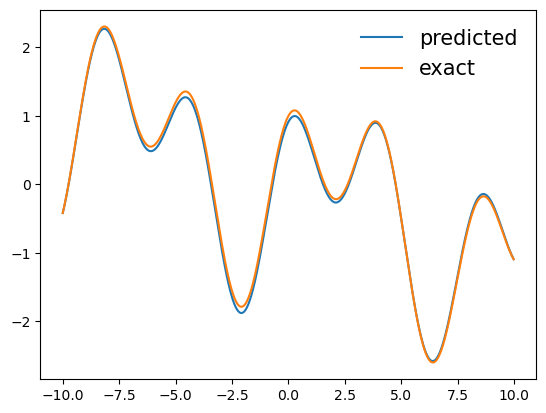

In [33]:
draw_exact()

In [34]:
def draw_error():
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_error,'r',label='Training error')

    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

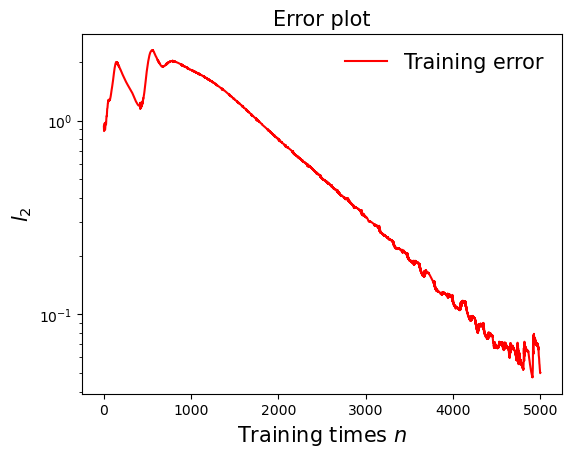

In [35]:
draw_error()    

In [39]:
def draw_epoch_w():
    s_collect = np.array(model.s_collect)
#     np.savetxt('s_WAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), np.exp(-s_collect[:, 0]), 'b-', label='e^{-s_{r}}')
    plt.plot(np.array(model.Step), np.exp(-s_collect[:, 1]), 'r-', label='e^{-s_{b}}')
    plt.xlabel('$Iters$')
    plt.ylabel('$\lambda$')
    plt.legend()
#     plt.savefig('2dpossion_S_WAM-AW.pdf')
    plt.show()

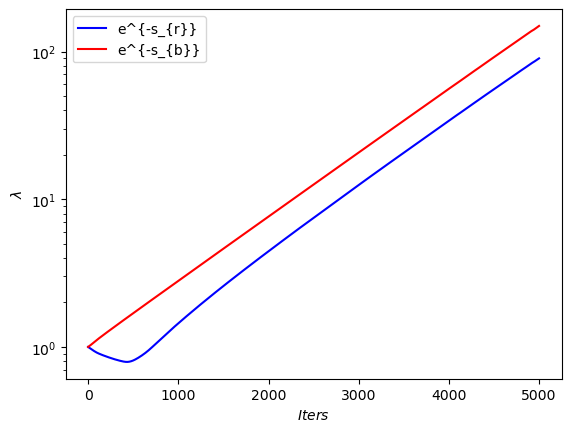

In [40]:
draw_epoch_w()

In [37]:
### (2) Model
layers = [1, 50, 50, 50, 1]
net = Net(layers)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
def evaluate(pred, exact):
    return np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)

In [38]:
### (3) Training / Fitting
iterations = 5000*2
# previous_validation_loss = 99999999.0
T_error1=[]
T_BC1=[]
T_PDE1=[]
Step=[]
for epoch in range(500):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    
    l2_loss = evaluate(net_bc_out.detach().cpu().numpy(), pt_u_bc.detach().cpu().numpy())

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, l2_loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.cpu().numpy())
            Step.append(epoch)
    

TypeError: expected np.ndarray (got Tensor)

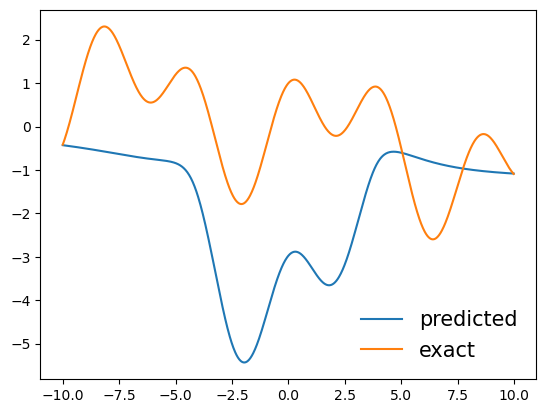

In [11]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

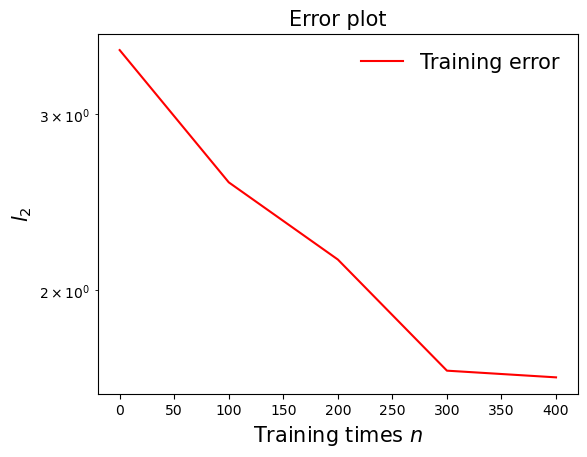

In [12]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [13]:
for epoch in range(500,1000):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    l2_loss = evaluate(net_bc_out.detach().cpu().numpy(), pt_u_bc.detach().cpu().numpy())

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, l2_loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.cpu().numpy())
            Step.append(epoch)

[500]-th step loss: 0.0193,  BC: 0.00026, residual: 1.22155
[600]-th step loss: 0.0142,  BC: 0.00014, residual: 0.73452
[700]-th step loss: 0.0266,  BC: 0.00049, residual: 0.50667
[800]-th step loss: 0.0322,  BC: 0.00072, residual: 0.28625
[900]-th step loss: 0.0436,  BC: 0.00132, residual: 0.12761


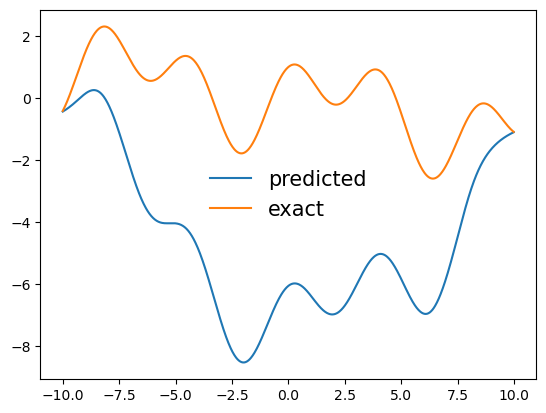

In [14]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

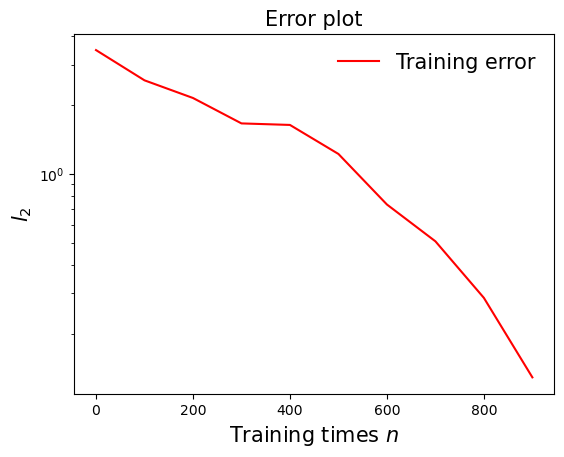

In [15]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [16]:
for epoch in range(1000,5000):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    l2_loss = evaluate(net_bc_out.detach().cpu().numpy(), pt_u_bc.detach().cpu().numpy())

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, l2_loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.cpu().numpy())
            Step.append(epoch)

[1000]-th step loss: 0.0180,  BC: 0.00023, residual: 0.08950
[1100]-th step loss: 0.0147,  BC: 0.00015, residual: 0.07318
[1200]-th step loss: 0.0277,  BC: 0.00053, residual: 0.05439
[1300]-th step loss: 0.0027,  BC: 0.00001, residual: 0.05272
[1400]-th step loss: 0.0181,  BC: 0.00023, residual: 0.03334
[1500]-th step loss: 0.0350,  BC: 0.00085, residual: 0.02371
[1600]-th step loss: 0.0175,  BC: 0.00021, residual: 0.03481
[1700]-th step loss: 0.0117,  BC: 0.00010, residual: 0.02614
[1800]-th step loss: 0.0068,  BC: 0.00003, residual: 0.02634
[1900]-th step loss: 0.0078,  BC: 0.00004, residual: 0.01162
[2000]-th step loss: 0.0129,  BC: 0.00012, residual: 0.01655
[2100]-th step loss: 0.0113,  BC: 0.00009, residual: 0.00319
[2200]-th step loss: 0.0078,  BC: 0.00004, residual: 0.00276
[2300]-th step loss: 0.0008,  BC: 0.00000, residual: 0.00356
[2400]-th step loss: 0.0051,  BC: 0.00002, residual: 0.00216
[2500]-th step loss: 0.0196,  BC: 0.00027, residual: 0.00132
[2600]-th step loss: 0.0

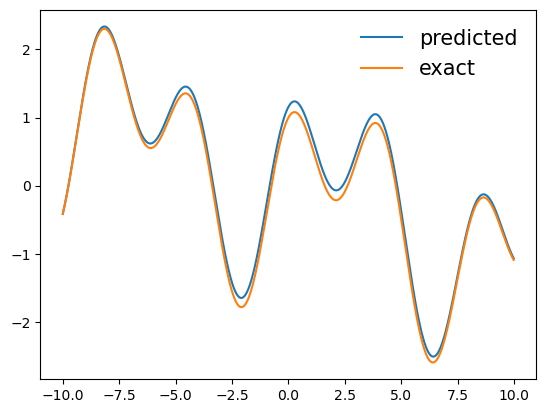

In [17]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

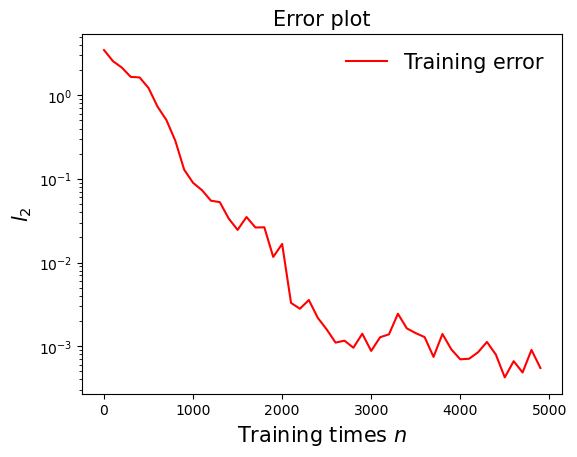

In [18]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [19]:
for epoch in range(5000,iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    l2_loss = evaluate(net_bc_out.detach().cpu().numpy(), pt_u_bc.detach().cpu().numpy())

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f, %.4f, BC: %.5f, residual: %.5f' % (epoch,loss, l2_loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.cpu().numpy())
            Step.append(epoch)

[5000]-th step loss: 0.0008, 0.0194, BC: 0.00026, residual: 0.00054
[5100]-th step loss: 0.0007, 0.0146, BC: 0.00015, residual: 0.00050
[5200]-th step loss: 0.0008, 0.0196, BC: 0.00027, residual: 0.00052
[5300]-th step loss: 0.0006, 0.0130, BC: 0.00012, residual: 0.00052
[5400]-th step loss: 0.0004, 0.0086, BC: 0.00005, residual: 0.00033
[5500]-th step loss: 0.0006, 0.0125, BC: 0.00011, residual: 0.00051
[5600]-th step loss: 0.0003, 0.0052, BC: 0.00002, residual: 0.00023
[5700]-th step loss: 0.0004, 0.0080, BC: 0.00004, residual: 0.00033
[5800]-th step loss: 0.0003, 0.0023, BC: 0.00000, residual: 0.00034
[5900]-th step loss: 0.0005, 0.0127, BC: 0.00011, residual: 0.00037
[6000]-th step loss: 0.0004, 0.0128, BC: 0.00011, residual: 0.00029
[6100]-th step loss: 0.0005, 0.0082, BC: 0.00005, residual: 0.00047
[6200]-th step loss: 0.0001, 0.0006, BC: 0.00000, residual: 0.00011
[6300]-th step loss: 0.0002, 0.0014, BC: 0.00000, residual: 0.00020
[6400]-th step loss: 0.0004, 0.0099, BC: 0.00007

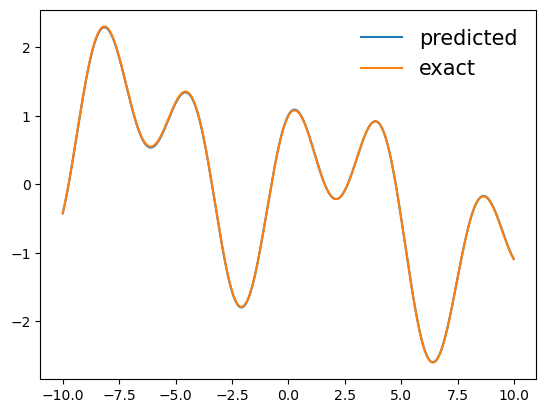

In [20]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

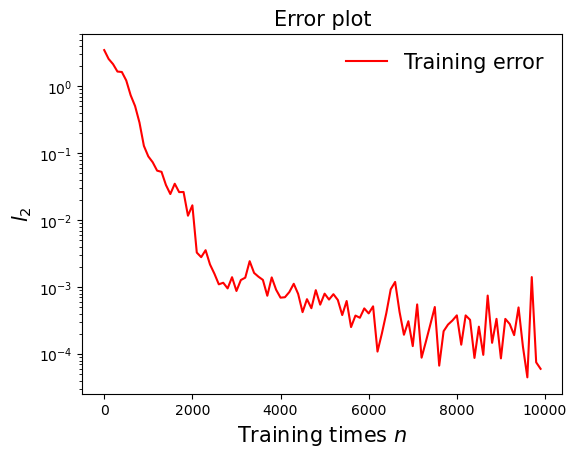

In [21]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

## lbPINN

In [10]:
class Model:
    def __init__(self, net, iterations):

        self.x_bc_s = None
        self.x_f_s = None
         
        self.net = net
        self.iterations = iterations
        self.Step = []
        self.T_error=[]
        self.T_BC=[]
        self.T_PDE=[]
    

    def likelihood_loss(self, loss_f, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_f.detach() + self.x_f_s \
               + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss

    def true_loss(self, loss_f, loss_bc):
        return torch.exp(-self.x_f_s.detach()) * loss_f + torch.exp(-self.x_bc_s.detach()) * loss_bc
    
    def run_AW(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)

        optimizer_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)

        for i in range(self.iterations):
            optimizer.zero_grad()
            
                
            # Loss based on boundary conditions
            pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
            pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
                
            net_bc_out = net(pt_x_bc) # output of u(x,t)
            mse_b = mse_cost_function(net_bc_out, pt_u_bc)
            
            # Loss based on PDE
            x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
            all_zeros = np.zeros((400,1))
    
    
            pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
            pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
            f_out = f(pt_x_collocation, net) # output of f(x,t)
            mse_f = mse_cost_function(f_out, pt_all_zeros)
    
            
            loss = self.true_loss(mse_f,mse_b)
            loss.backward()
            optimizer.step()
            
            optimizer_weight.zero_grad()
            loss = self.likelihood_loss(mse_f,mse_b)
            loss.backward() 
            optimizer_weight.step()
            
            loss_sum = mse_f+mse_b
    
            l2_loss = evaluate(net_bc_out.detach().cpu().numpy(), pt_u_bc.detach().cpu().numpy())
            if i % 100 == 0: 
                with torch.autograd.no_grad():
                    print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (i, l2_loss, mse_b,mse_f))
                    print('s_f:%.4f, s_{bc}:%.4f' %(self.x_f_s, self.x_bc_s))
                    self.T_BC.append(mse_b.detach().cpu().numpy())
                    self.T_PDE.append(mse_f.detach().cpu().numpy())
                    self.T_error.append(loss_sum.cpu().numpy())
                    self.Step.append(i)
    
    def train(self):

        self.x_f_s = torch.tensor(0.)
        self.x_bc_s = torch.tensor(0.)
        self.run_AW()

In [11]:
net = Net(layers)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
model = Model(
    net=net, iterations = 500)

In [12]:
model.train()

[0]-th step loss: 1.2930,  BC: 1.16159, residual: 2.52376
s_f:0.0010, s_{bc}:0.0010
[100]-th step loss: 0.0109,  BC: 0.00008, residual: 2.21557
s_f:0.0946, s_{bc}:-0.1101
[200]-th step loss: 0.0085,  BC: 0.00005, residual: 1.83717
s_f:0.1629, s_{bc}:-0.2167
[300]-th step loss: 0.0087,  BC: 0.00005, residual: 1.72035
s_f:0.2148, s_{bc}:-0.3201
[400]-th step loss: 0.0086,  BC: 0.00005, residual: 1.61455
s_f:0.2537, s_{bc}:-0.4224


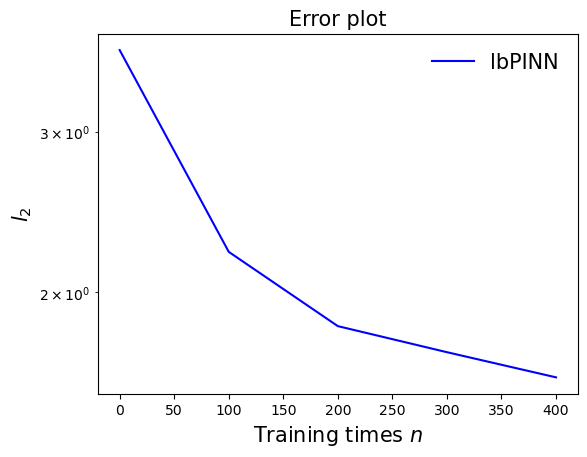

In [15]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
# plt.semilogy(model.Step, T_error1[:len(model.Step)],'r',label='PINN')
plt.semilogy(model.Step, model.T_error,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

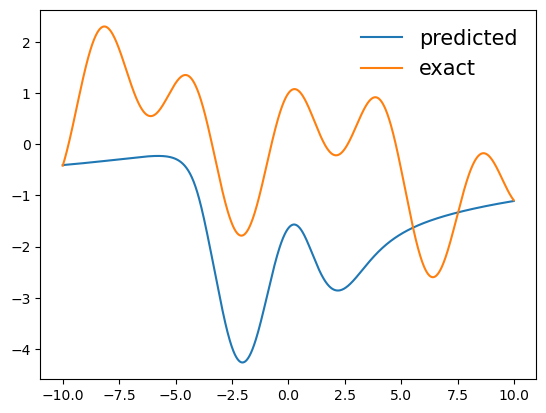

In [16]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [17]:
net = Net(layers)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
model = Model(
    net=net, iterations = 1000)

In [18]:
model.train()

[0]-th step loss: 1.3171,  BC: 1.20529, residual: 2.48772
s_f:0.0010, s_{bc}:0.0010
[100]-th step loss: 0.0067,  BC: 0.00003, residual: 2.47248
s_f:0.0964, s_{bc}:-0.1096
[200]-th step loss: 0.0051,  BC: 0.00002, residual: 1.91714
s_f:0.1673, s_{bc}:-0.2160
[300]-th step loss: 0.0117,  BC: 0.00010, residual: 1.59857
s_f:0.2166, s_{bc}:-0.3194
[400]-th step loss: 0.0028,  BC: 0.00001, residual: 1.53780
s_f:0.2482, s_{bc}:-0.4216
[500]-th step loss: 0.0103,  BC: 0.00007, residual: 1.26884
s_f:0.2570, s_{bc}:-0.5233
[600]-th step loss: 0.0042,  BC: 0.00001, residual: 1.12056
s_f:0.2507, s_{bc}:-0.6245
[700]-th step loss: 0.0130,  BC: 0.00012, residual: 0.79280
s_f:0.2154, s_{bc}:-0.7255
[800]-th step loss: 0.0309,  BC: 0.00066, residual: 0.49444
s_f:0.1416, s_{bc}:-0.8262
[900]-th step loss: 0.0119,  BC: 0.00010, residual: 0.39250
s_f:0.0384, s_{bc}:-0.9268


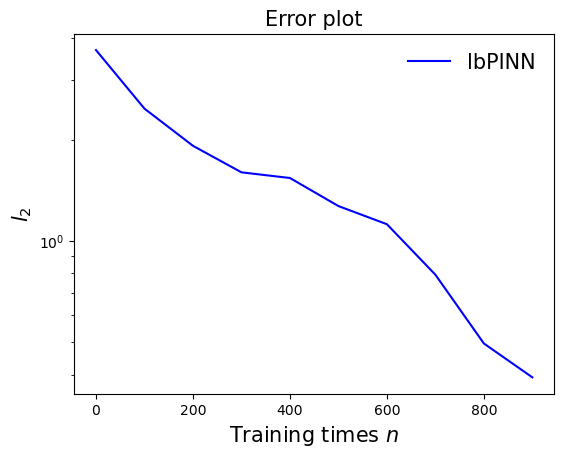

In [19]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
# plt.semilogy(model.Step, T_error1[:len(model.Step)],'r',label='PINN')
plt.semilogy(model.Step, model.T_error,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

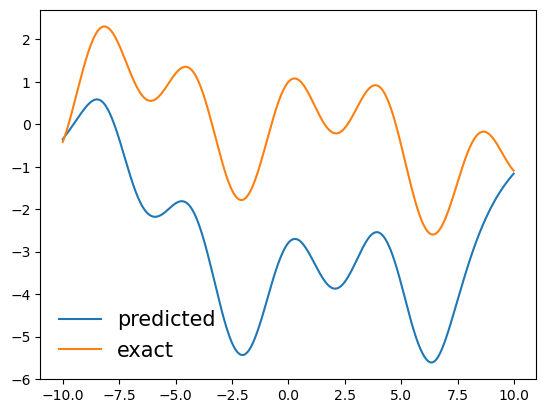

In [20]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [21]:
net = Net(layers)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
model = Model(
    net=net, iterations = 5000)

In [22]:
model.train()

[0]-th step loss: 1.3218,  BC: 1.21388, residual: 2.78550
s_f:0.0010, s_{bc}:0.0010
[100]-th step loss: 0.0043,  BC: 0.00001, residual: 2.50661
s_f:0.0972, s_{bc}:-0.1099
[200]-th step loss: 0.0082,  BC: 0.00005, residual: 2.02935
s_f:0.1723, s_{bc}:-0.2166
[300]-th step loss: 0.0127,  BC: 0.00011, residual: 1.83692
s_f:0.2221, s_{bc}:-0.3202
[400]-th step loss: 0.0052,  BC: 0.00002, residual: 1.46959
s_f:0.2555, s_{bc}:-0.4225
[500]-th step loss: 0.0012,  BC: 0.00000, residual: 1.14586
s_f:0.2751, s_{bc}:-0.5243
[600]-th step loss: 0.0056,  BC: 0.00002, residual: 1.11077
s_f:0.2685, s_{bc}:-0.6256
[700]-th step loss: 0.0174,  BC: 0.00021, residual: 0.54742
s_f:0.2147, s_{bc}:-0.7266
[800]-th step loss: 0.0055,  BC: 0.00002, residual: 0.46808
s_f:0.1252, s_{bc}:-0.8274
[900]-th step loss: 0.0228,  BC: 0.00036, residual: 0.27157
s_f:0.0229, s_{bc}:-0.9281
[1000]-th step loss: 0.0087,  BC: 0.00005, residual: 0.11671
s_f:-0.1023, s_{bc}:-1.0286
[1100]-th step loss: 0.0254,  BC: 0.00045, r

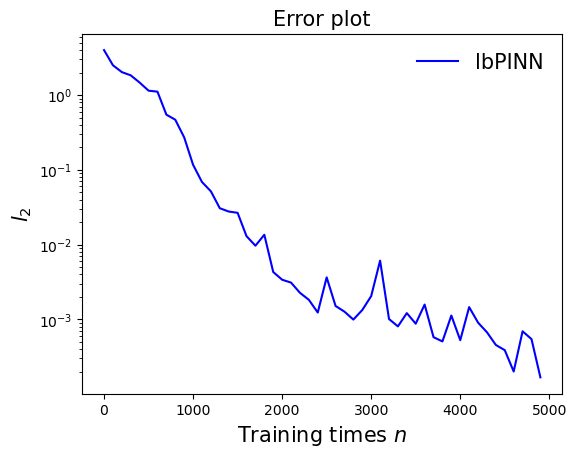

In [24]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
# plt.semilogy(model.Step, T_error1[:len(model.Step)],'r',label='PINN')
plt.semilogy(model.Step, model.T_error,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

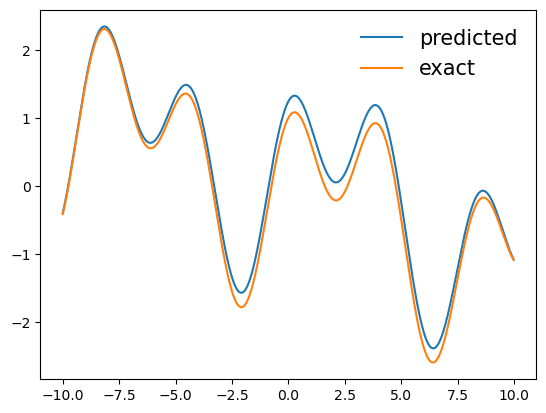

In [51]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [52]:
net = Net(layers)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
model = Model(
    net=net, iterations = 10000)

In [53]:
model.train()

[0]-th step loss: 1.7209,  BC: 2.05753, residual: 2.53663
s_f:0.0010, s_{bc}:0.0010
[100]-th step loss: 0.0207,  BC: 0.00030, residual: 2.49423
s_f:0.0970, s_{bc}:-0.0999
[200]-th step loss: 0.0067,  BC: 0.00003, residual: 1.95933
s_f:0.1714, s_{bc}:-0.2073
[300]-th step loss: 0.0129,  BC: 0.00012, residual: 1.88453
s_f:0.2268, s_{bc}:-0.3111
[400]-th step loss: 0.0068,  BC: 0.00003, residual: 1.70808
s_f:0.2665, s_{bc}:-0.4137
[500]-th step loss: 0.0048,  BC: 0.00002, residual: 1.65890
s_f:0.2971, s_{bc}:-0.5156
[600]-th step loss: 0.0022,  BC: 0.00000, residual: 1.43271
s_f:0.3195, s_{bc}:-0.6170
[700]-th step loss: 0.0053,  BC: 0.00002, residual: 1.49871
s_f:0.3279, s_{bc}:-0.7182
[800]-th step loss: 0.0091,  BC: 0.00006, residual: 1.09018
s_f:0.3163, s_{bc}:-0.8191
[900]-th step loss: 0.0179,  BC: 0.00022, residual: 0.62020
s_f:0.2505, s_{bc}:-0.9198
[1000]-th step loss: 0.0165,  BC: 0.00019, residual: 0.54335
s_f:0.1527, s_{bc}:-1.0204
[1100]-th step loss: 0.0122,  BC: 0.00010, re

[9300]-th step loss: 0.0145,  BC: 0.00015, residual: 0.00048
s_f:-7.0683, s_{bc}:-8.0133
[9400]-th step loss: 0.0161,  BC: 0.00018, residual: 0.00120
s_f:-7.0515, s_{bc}:-8.0177
[9500]-th step loss: 0.0059,  BC: 0.00002, residual: 0.00020
s_f:-7.0569, s_{bc}:-8.0884
[9600]-th step loss: 0.0324,  BC: 0.00073, residual: 0.00184
s_f:-7.1218, s_{bc}:-8.1180
[9700]-th step loss: 0.0222,  BC: 0.00034, residual: 0.00030
s_f:-7.1547, s_{bc}:-8.1235
[9800]-th step loss: 0.0143,  BC: 0.00014, residual: 0.00058
s_f:-7.1873, s_{bc}:-8.1512
[9900]-th step loss: 0.0080,  BC: 0.00004, residual: 0.00025
s_f:-7.2072, s_{bc}:-8.1712


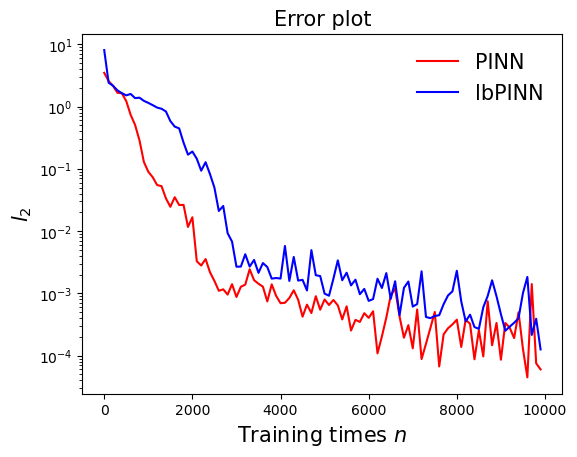

In [37]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(model.Step, T_error1[:len(model.Step)],'r',label='PINN')
plt.semilogy(model.Step, model.T_error,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

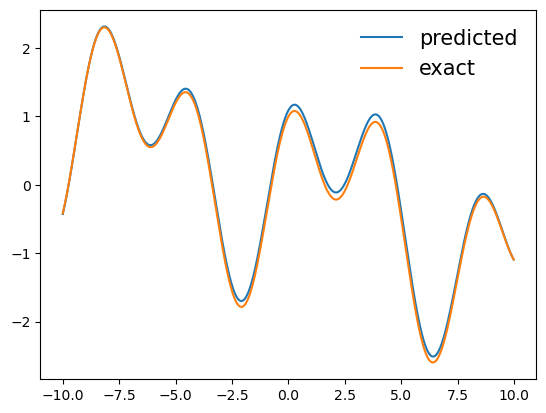

In [38]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)